<IPython.core.display.Javascript object>


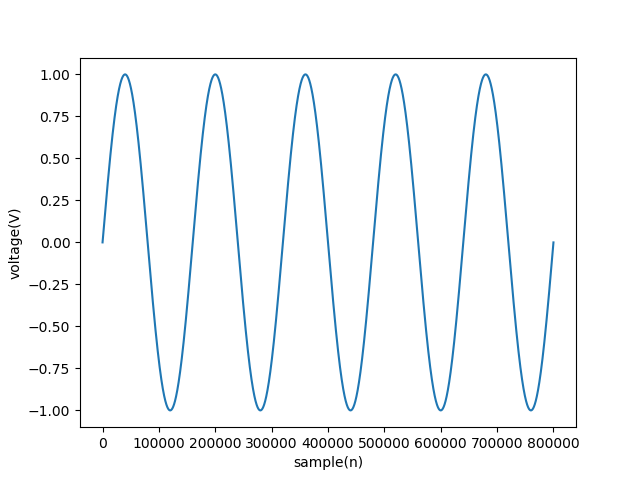

In [8]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import seaborn
Fs = 800000
f = 5
sample = 800000
x = np.arange(sample)
y = np.sin(2 * np.pi * f * x / Fs)
plt.plot(x, y)
plt.xlabel('sample(n)')
plt.ylabel('voltage(V)')
plt.show()

In [ ]:
# %load .\3_creating_model.ipynb
{
 "cells": [
  {
   "cell_type": "code",
   "execution_count": 16,
   "metadata": {},
   "outputs": [],
   "source": [
    "# %%capture\n",
    "import os\n",
    "import numpy as np\n",
    "from enum import Enum\n",
    "import time\n",
    "import datetime\n",
    "import keras.layers as keras_layers\n",
    "\n",
    "from vqa_logger import logger"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": 17,
   "metadata": {},
   "outputs": [],
   "source": [
    "from common.os_utils import File\n",
    "from common.settings import classify_strategy, embedded_sentence_length, get_stratagy_str\n",
    "from common.classes import ClassifyStrategies, VqaSpecs\n",
    "from common.model_utils import save_model\n",
    "from common.constatns import vqa_models_folder, vqa_specs_location"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": 18,
   "metadata": {},
   "outputs": [],
   "source": [
    "DEFAULT_IMAGE_WIEGHTS = 'imagenet'\n",
    "#  Since VGG was trained as a image of 224x224, every new image\n",
    "# is required to go through the same transformation\n",
    "image_size_by_base_models = {'imagenet': (224, 224)}"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": 19,
   "metadata": {},
   "outputs": [],
   "source": [
    "# categorial_column = 'ix_to_ans'\n",
    "categorial_column = 'ix_to_img_device'"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": 20,
   "metadata": {},
   "outputs": [],
   "source": [
    "#Available merge strategies:\n",
    "# keras_layers.multiply, keras_layers.add, keras_layers.concatenate, \n",
    "# keras_layers.average, keras_layers.co, keras_layers.dot, keras_layers.maximum\n",
    "            \n",
    "merge_strategy = keras_layers.concatenate"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": 21,
   "metadata": {},
   "outputs": [],
   "source": [
    "vqa_specs = File.load_pickle(vqa_specs_location)\n",
    "meta_data = vqa_specs.meta_data\n"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": 22,
   "metadata": {},
   "outputs": [
    {
     "name": "stdout",
     "output_type": "stream",
     "text": [
      "C:\\Users\\avitu\\Documents\\GitHub\\VQA-MED\\VQA-MED\\Cognitive-LUIS-Windows-master\\Sample\\VQA.Python\\data\\vqa_specs.pkl\n"
     ]
    },
    {
     "data": {
      "text/plain": [
       "dict_keys(['ix_to_word', 'ix_to_ans', 'ans_to_ix', 'img_device_to_ix', 'ix_to_img_device'])"
      ]
     },
     "execution_count": 22,
     "metadata": {},
     "output_type": "execute_result"
    }
   ],
   "source": [
    "print(vqa_specs_location)\n",
    "meta_data.keys()"
   ]
  },
  {
   "cell_type": "markdown",
   "metadata": {},
   "source": [
    "Before we start, just for making sure, lets clear the session:"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": 23,
   "metadata": {
    "collapsed": false
   },
   "outputs": [],
   "source": [
    "from keras import backend as keras_backend\n",
    "keras_backend.clear_session()"
   ]
  },
  {
   "cell_type": "markdown",
   "metadata": {},
   "source": [
    "### Creating the model"
   ]
  },
  {
   "cell_type": "markdown",
   "metadata": {},
   "source": [
    "#### The functions the gets the model:"
   ]
  },
  {
   "cell_type": "markdown",
   "metadata": {},
   "source": [
    "Define how to build the word-to vector branch:"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": 24,
   "metadata": {
    "collapsed": false
   },
   "outputs": [],
   "source": [
    "#  Input 0 is incompatible with layer lstm_1: expected ndim=3, found ndim=2\n",
    "# Input 0 is incompatible with layer embbeding_LSTM_1: expected ndim=3, found ndim=2\n",
    "def word_2_vec_model(input_tensor):\n",
    "        #print(dir(input_tensor))\n",
    "        print('---------------------------------------------')\n",
    "        print(input_tensor.get_shape())\n",
    "        print('---------------------------------------------')\n",
    "        print(input_tensor.shape)\n",
    "        print('---------------------------------------------')\n",
    "        print(embedded_sentence_length)\n",
    "        print('---------------------------------------------')\n",
    "        # return\n",
    "        # notes:\n",
    "        # num works: scalar represents size of original corpus\n",
    "        # embedding_dim : dim reduction. every input string will be encoded in a binary fashion using a vector of this length\n",
    "        # embedding_matrix (AKA embedding_initializers): represents a pre trained network\n",
    "\n",
    "        LSTM_UNITS = 512\n",
    "        DENSE_UNITS = 1024\n",
    "        DENSE_ACTIVATION = 'relu'\n",
    "        \n",
    "        logger.debug(\"Creating Embedding model\")\n",
    "        x= input_tensor # Since using spacy\n",
    "        \n",
    "        # x = Embedding(num_words, embedding_dim, weights=[embedding_matrix], input_length=seq_length,trainable=False)(input_tensor)\n",
    "        # x = LSTM(units=LSTM_UNITS, return_sequences=True, input_shape=(seq_length, embedding_dim))(x)\n",
    "        \n",
    "        x = LSTM(units=LSTM_UNITS, return_sequences=False, name='embbeding_LSTM_CATEGORIAL_test',  input_shape=(1,embedded_sentence_length))(x)\n",
    "        x = BatchNormalization(name='embbeding_batch_normalization_CATEGORIAL_test')(x)\n",
    "        \n",
    "#         x = LSTM(units=LSTM_UNITS, return_sequences=True, name='embbeding_LSTM_1',  input_shape=(1,embedded_sentence_length))(x)\n",
    "#         x = BatchNormalization(name='embbeding_batch_normalization_1')(x)\n",
    "#         x = LSTM(units=LSTM_UNITS, return_sequences=False, name='embbeding_LSTM_2')(x)\n",
    "#         x = BatchNormalization(name='embbeding_batch_normalization_2')(x)\n",
    "        \n",
    "        x = Dense(units=DENSE_UNITS, activation=DENSE_ACTIVATION)(x)\n",
    "        model = x\n",
    "        logger.debug(\"Done Creating Embedding model\")\n",
    "        return model"
   ]
  },
  {
   "cell_type": "markdown",
   "metadata": {},
   "source": [
    "In the same manner, define how to build the image representation branch:"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": 25,
   "metadata": {
    "collapsed": false
   },
   "outputs": [],
   "source": [
    "from keras.applications.vgg19 import VGG19\n",
    "from keras.layers import Dense, GlobalAveragePooling2D#, Input, Dropout\n",
    "def get_image_model(base_model_weights=DEFAULT_IMAGE_WIEGHTS, out_put_dim=1024):\n",
    "    base_model_weights = base_model_weights\n",
    "\n",
    "    # base_model = VGG19(weights=base_model_weights,include_top=False)\n",
    "    base_model = VGG19(weights=base_model_weights, include_top=False)\n",
    "    base_model.trainable = False\n",
    "    for layer in base_model.layers:\n",
    "        layer.trainable = False\n",
    "\n",
    "    x = base_model.output\n",
    "    # add a global spatial average pooling layer\n",
    "    x = GlobalAveragePooling2D(name=\"image_model_average_pool\")(x)\n",
    "    # let's add a fully-connected layer\n",
    "    x = Dense(out_put_dim, activation='relu',name=\"image_model_dense\")(x)\n",
    "    # and a logistic layer -- let's say we have 200 classes\n",
    "    # predictions = Dense(200, activation='softmax')(x)\n",
    "    model = x\n",
    "    \n",
    "    return base_model.input , model"
   ]
  },
  {
   "cell_type": "markdown",
   "metadata": {},
   "source": [
    "And finally, building the model itself:"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": 26,
   "metadata": {},
   "outputs": [
    {
     "name": "stdout",
     "output_type": "stream",
     "text": [
      "[09:29:49][DEBUG] Model will have 4 output units (Strategy: ClassifyStrategies.CATEGORIAL)\n"
     ]
    }
   ],
   "source": [
    "model_output_num_units = None\n",
    "if classify_strategy == ClassifyStrategies.CATEGORIAL:    \n",
    "    model_output_num_units = len(list(meta_data[categorial_column].keys()) )\n",
    "elif classify_strategy == ClassifyStrategies.NLP:\n",
    "    model_output_num_units = embedded_sentence_length    \n",
    "else:\n",
    "    raise Exception(f'Unfamilier strategy: {strat}')\n",
    "\n",
    "logger.debug(f'Model will have {model_output_num_units} output units (Strategy: {classify_strategy})')"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": 27,
   "metadata": {},
   "outputs": [
    {
     "name": "stdout",
     "output_type": "stream",
     "text": [
      "[09:29:49][DEBUG] Getting embedding (lstm model)\n",
      "---------------------------------------------\n",
      "(?, 12288, 1)\n",
      "---------------------------------------------\n",
      "(?, 12288, 1)\n",
      "---------------------------------------------\n",
      "12288\n",
      "---------------------------------------------\n",
      "[09:29:49][DEBUG] Creating Embedding model\n",
      "[09:29:50][DEBUG] Done Creating Embedding model\n",
      "[09:29:50][DEBUG] Getting image model\n",
      "[09:29:52][DEBUG] merging final model\n"
     ]
    },
    {
     "name": "stderr",
     "output_type": "stream",
     "text": [
      "c:\\local\\Anaconda3-4.1.1-Windows-x86_64\\envs\\conda_env\\lib\\site-packages\\ipykernel_launcher.py:40: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor(\"mo...)`\n"
     ]
    },
    {
     "data": {
      "text/plain": [
       "<keras.engine.training.Model at 0x1a98361fda0>"
      ]
     },
     "execution_count": 27,
     "metadata": {},
     "output_type": "execute_result"
    }
   ],
   "source": [
    "from keras import Model, models, Input, callbacks\n",
    "from keras.utils import plot_model, to_categorical\n",
    "from keras.layers import Dense, Embedding, LSTM, BatchNormalization#, GlobalAveragePooling2D, Merge, Flatten\n",
    "\n",
    "def get_vqa_model(meta):\n",
    "#     import tensorflow as tf\n",
    "#     g = tf.Graph()\n",
    "#     with g.as_default():\n",
    "    DENSE_UNITS = 1000\n",
    "    DENSE_ACTIVATION = 'relu'\n",
    "\n",
    "    OPTIMIZER = 'rmsprop'\n",
    "    LOSS = 'categorical_crossentropy'\n",
    "    METRICS = 'accuracy'\n",
    "    num_classes = len(meta['ix_to_ans'].keys())\n",
    "    image_model, lstm_model, fc_model = None, None, None\n",
    "    try:     \n",
    "        # ATTN:\n",
    "        lstm_input_tensor = Input(shape=(embedded_sentence_length,1), name='embedding_input')\n",
    "        #lstm_input_tensor = Input(shape=(embedding_dim,), name='embedding_input')\n",
    "\n",
    "        logger.debug(\"Getting embedding (lstm model)\")\n",
    "        lstm_model = word_2_vec_model(input_tensor=lstm_input_tensor)\n",
    "\n",
    "        logger.debug(\"Getting image model\")\n",
    "        out_put_dim = lstm_model.shape[-1].value\n",
    "        image_input_tensor, image_model = get_image_model(out_put_dim=out_put_dim)\n",
    "\n",
    "\n",
    "        logger.debug(\"merging final model\")\n",
    "        fc_tensors = merge_strategy(inputs=[image_model, lstm_model])\n",
    "        fc_tensors = BatchNormalization()(fc_tensors)\n",
    "        fc_tensors = Dense(units=DENSE_UNITS, activation=DENSE_ACTIVATION)(fc_tensors)\n",
    "        fc_tensors = BatchNormalization()(fc_tensors)\n",
    "\n",
    "        #ATTN:\n",
    "        fc_tensors = Dense(units=model_output_num_units, activation='softmax', name='model_output_sofmax_dense')(fc_tensors)\n",
    "        #fc_tensors = Dense(units=num_classes, activation='softmax', name='model_output_sofmax_dense')(fc_tensors)\n",
    "\n",
    "        fc_model = Model(inputs=[lstm_input_tensor, image_input_tensor], output=fc_tensors)\n",
    "        fc_model.compile(optimizer=OPTIMIZER, loss=LOSS, metrics=[METRICS])\n",
    "    except Exception as ex:\n",
    "        logger.error(\"Got an error while building vqa model:\\n{0}\".format(ex))\n",
    "        models = [(image_model, 'image_model'), (lstm_model, 'lstm_model'), (fc_model, 'lstm_model')]\n",
    "        for m, name in models:\n",
    "            if m is not None:\n",
    "                logger.error(\"######################### {0} model details: ######################### \".format(name))\n",
    "                try:\n",
    "                    m.summary(print_fn=logger.error)\n",
    "                except Exception as ex2:\n",
    "                    logger.warning(\"Failed to print summary for {0}:\\n{1}\".format(name, ex2))\n",
    "        raise\n",
    "\n",
    "    return fc_model\n",
    "\n",
    "model = get_vqa_model(meta_data)\n",
    "model\n"
   ]
  },
  {
   "cell_type": "markdown",
   "metadata": {},
   "source": [
    "##### We better save it:"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": 28,
   "metadata": {
    "collapsed": false
   },
   "outputs": [
    {
     "name": "stdout",
     "output_type": "stream",
     "text": [
      "[09:29:52][DEBUG] saving model to: 'C:\\Users\\Public\\Documents\\Data\\2018\\vqa_models\\20180727_0929_52\\vqa_model_CATEGORIAL.h5'\n",
      "[09:29:52][DEBUG] saving model image to C:\\Users\\Public\\Documents\\Data\\2018\\vqa_models\\20180727_0929_52\\model.png\n",
      "[09:29:52][DEBUG] model saved\n",
      "[09:29:52][DEBUG] Writing Symmary\n",
      "[09:29:52][DEBUG] Done Writing Summary\n",
      "[09:29:52][DEBUG] Saving image\n",
      "[09:29:53][DEBUG] Image saved ('C:\\Users\\Public\\Documents\\Data\\2018\\vqa_models\\20180727_0929_52\\model.png')\n",
      "Summary: C:\\Users\\Public\\Documents\\Data\\2018\\vqa_models\\20180727_0929_52\\model_summary.txt\n",
      "Image: C:\\Users\\Public\\Documents\\Data\\2018\\vqa_models\\20180727_0929_52\\model.png\n",
      "\n",
      "model_location = 'C:\\Users\\Public\\Documents\\Data\\2018\\vqa_models\\20180727_0929_52\\vqa_model_CATEGORIAL.h5'\n"
     ]
    }
   ],
   "source": [
    "strategy_str = get_stratagy_str()\n",
    "\n",
    "model_fn, summary_fn, fn_image = save_model(model, vqa_models_folder, name_suffix=strategy_str)\n",
    "\n",
    "msg = f\"Summary: {summary_fn}\\n\"\n",
    "msg += f\"Image: {fn_image}\\n\"\n",
    "location_message = f\"model_location = '{model_fn}'\"\n",
    "\n",
    "\n",
    "print(msg)\n",
    "print (location_message)"
   ]
  },
  {
   "cell_type": "markdown",
   "metadata": {},
   "source": [
    "Display a plot + summary:"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": 29,
   "metadata": {
    "collapsed": false
   },
   "outputs": [
    {
     "data": {
      "image/png": "iVBORw0KGgoAAAANSUhEUgAABBsAAArhCAYAAAAtdOLmAAAABmJLR0QA/wD/AP+gvaeTAAAgAElEQVR4nOzdf4hd5Z0/8M81P7ZL6ar9kRRrdVesrnbptAhuYruKqd0vq5wou0bnh9EiMUwwLnbjHzXcwZZYZCGhwgoJM4UiMpmh2ULJRWXBpDRQc/cPZeYPWSLFOtO17L0UOoNdWBvt+f6R3tv5cWfmzuS5c8bx9YLBuec+59zP89w7wfO+z3lOKc/zPAAAAADS2H9J0RUAAAAA64uwAQAAAEhK2AAAAAAkJWwAAAAAktpYdAGsbQcPHoxf/OIXRZcBLW3YsCG+//3vx2c/+9miSwEAAGYws4FFPfPMM3HixImiy4CWRkdH4/Tp00WXAQAAzGFmA0saHh6O3t7eosuAeUqlUtElAAAALZjZAAAAACQlbAAAAACSEjYAAAAASQkbAAAAgKSEDQAAAEBSwgYAAAAgKWEDAAAAkJSwAQAAAEhK2AAAAAAkJWwAAAAAkhI2AAAAAEkJGwAAAICkhA0AAABAUsIGAAAAIClhA0kNDAzEwMBA0WUAAABQIGED68r09HSUSqUV71utVmNoaCh27ty5omOUSqWWP0WYOxZrqTYAAGB921h0Aawvhw4dKvT1z5w5s+J9Dx8+HBERTz/99IqPked5TE9Px2WXXRYREVNTU3HppZeu+HgXY+5Y5Hke9Xo9tm7dGhHF1gYAAKxvwgbWjenp6RgaGlrx/o2g5GLChoiYdQJf1Mn8QmOxZcuW5u+CBgAAoFNcRkEy9Xo9RkdHm5cgzH1cqVSiVCrFzp07Y3JystmmUqk02wwNDUWpVIp9+/bFm2++2Tx2q2n/c7cdPnw4KpXKrOdSW+maFB/GsWgEFo39BwYGol6vx5EjR2a93pEjR5r7zHxuZr8a23fu3BmnT5+e19/p6enYt2+f9T4AAGC9yGEREZEPDw+31TbLsjwi8sbHaubjs2fP5nme5xMTE3lE5P39/c3jz20zNTWV9/f35xGRnzt3Ls/zPK/VarOOPfNYM7fNfbzSPi90jHK5nJfL5WUfYy2NRbtj1HjdWq02r9azZ8/OejxTlmV5rVZr1pplWT4yMpLneZ6fOnUqj4h8bGxs3piMjY21PN5ilvP5BAAAVs2jpTzP804FGXz4lUqlGB4ejt7e3rbbR1xYH6DV43bbjI+Px5e//OU4fPhwHDhw4KKOtVydOsZaGYt2+zcwMBC/+c1v4ujRoy33O3LkSDzxxBMxMTERV111VbPW//qv/4ru7u6IiBgdHY2enp55dZbL5Th06FDzmCtdP2K5n08AAGBV7HcZBWtSV1dXREQ88cQTBVdSvKLG4tChQ3H06NGYnJycdalEwx133BEREf/xH//R3PbKK6/ELbfc0nx8/PjxiJh/mcfcdTGsHwEAAOuLsAFY0NDQUOzfvz+yLJv3XFdXV/T398fevXtjeno6pqen4xe/+EVzlkNENNeNyPN83g8AALB+CRtY0/r7+4suYc1YrbHYt29fRFy4BGLv3r3x3HPPxXXXXbdoTS+//HKcOXMmHnrooZbtZi5wCQAArH/CBtakxsnpnXfeWXAlxVvNsahWq3HbbbdFRERPT09ExKyZCnM1Zjf09PTE0NBQbNu2bdbzg4ODERHxwgsvxPT0dET86e4UAADA+iVsIJl6vT7r95mPGyeajf/ObR9x4Zv0RpsXXnghsiybNX2/8S164+S7Wq02n2t8G99ov9IT2pn1zfy9oZ1bX7Y6xloZi7mvM1O1Wo3t27fHDTfcMGv/ycnJWTMT5h6jMZuh1aUWd999d0RcWKPhsssui1KpFFu3bo1du3YtWgsAAPDhJmwgma1bt876febjyy67bNZ/57aPiLjhhhti586dcdlll8VVV10VL7zwwqznn3zyyciyLK6//vqoVCqxbdu2yLIsRkZG4rvf/W5EXFjUMCLi3/7t32L37t3Lqr9UKs2qr3FynOIYa2Es5tYxc9HGUqkU27dvj4iIv/zLv5y1/9DQUFx22WVRLpejv78//u///m9WLY3XbsyImGnLli0xMTER5XI5Ii6EJI27V8ysZefOnQuOKQAA8OHj1pcsajVuLZjiVpPrxYdxLKanp+Pb3/528xaZq8mtLwEAYE1y60vg4vzoRz+KXbt2FV0GAACwhggbKNTcdR4+yj5MYzEwMNC8/GJycjJ27NhRdEkAAMAasrHoAvhom7vOQ+rLB9pdc2EtXLbQ6bFIqXGHisHBwXjkkUcKrgYAAFhrhA0UqtMn1Gv5hH2uD1OtjzzyiJABAABYkMsoAAAAgKSEDQAAAEBSwgYAAAAgKWEDAAAAkJSwAQAAAEhK2AAAAAAkJWwAAAAAkhI2AAAAAEkJGwAAAICkhA0AAABAUsIGAAAAIClhAwAAAJCUsAEAAABIamPRBbD29fX1xU9+8pOiywAAAOBDQtjAop588sn4xS9+UXQZ68aZM2fir//6r2PLli1Fl7IudHd3x44dO4ouAwAAmKOU53ledBHwUVEqlWJ4eDh6e3uLLgUAAKBT9luzAQAAAEhK2AAAAAAkJWwAAAAAkhI2AAAAAEkJGwAAAICkhA0AAABAUsIGAAAAIClhAwAAAJCUsAEAAABIStgAAAAAJCVsAAAAAJISNgAAAABJCRsAAACApIQNAAAAQFLCBgAAACApYQMAAACQlLABAAAASErYAAAAACQlbAAAAACSEjYAAAAASQkbAAAAgKSEDQAAAEBSwgYAAAAgKWEDAAAAkJSwAQAAAEhK2AAAAAAkJWwAAAAAkhI2AAAAAEkJGwAAAICkhA0AAABAUsIGAAAAIClhAwAAAJCUsAEAAABIqpTneV50EbAe/fjHP44nn3wyrrjiiua2n//853H99dfHpz/96YiImJqaiq997Wvx3HPPFVUmAABAavuFDdAhAwMD8fTTT7fV1p8hAACwjux3GQV0SE9Pz5JtNm3aFN/5znc6XwwAAMAqEjZAh9x4443xxS9+cdE258+fj+7u7lWqCAAAYHUIG6CDHnjggdi0aVPL50qlUnzpS1+K66+/fpWrAgAA6CxhA3RQT09PvP/++y2f27BhQzz00EOrXBEAAEDnCRugg66++uq4+eab45JL5v+pffDBB3H//fcXUBUAAEBnCRugwx566KEolUqztl1yySVxyy23xOc+97mCqgIAAOgcYQN02L333jtvW6lUigcffLCAagAAADpP2AAd9pnPfCZuv/322LBhQ3NbqVRqGUIAAACsB8IGWAUPPvhg5HkeERcWhvzGN74Rn/zkJwuuCgAAoDOEDbAK7rnnnuYtMPM8jwceeKDgigAAADpH2ACr4BOf+ETcddddERGxefPmuPvuuwuuCAAAoHM2Fl0AnfOrX/0qqtVq0WXwR9dcc03zvy+99FLB1dBw5ZVXxvbt24suAwAA1pVS3riQnHXn4Ycfjh/+8IdFlwFrnn8GAQAgqf1mNqxj7733XvT29sbw8HDRpcCadPz48ejr6yu6DAAAWHes2QAAAAAkJWwAAAAAkhI2AAAAAEkJGwAAAICkhA0AAABAUsIGAAAAIClhAwAAAJCUsAEAAABIStgAAAAAJCVsAAAAAJISNgAAAABJCRsAAACApIQNAAAAQFLCBgAAACApYQNN9Xo9RkdHY+fOnUnadbIGAAAA1i5hA01PPfVU9PT0RKVSSdJuJfbs2dPWsaenp6NarcbQ0NC6DCY60b9qtRoDAwNRKpWiVCrFwMBAjI+PR71ej1KplOQ1VmJycjL27dsXpVIp9u3bF6dPn571fKPeVj9HjhyJSqUS09PTBVUPAAC0UsrzPC+6CDqjr68vIiKGh4fb3qdx0rnUx6LddivRzrEHBgYiIuLpp5/uWB1FSt2/gYGB+M1vfhPf+ta34rrrrouIC7NI/vM//7MZZhQxhtPT03HmzJnIsiymp6fj5Zdfjp6enjh58mRkWdZsV6/XY+vWrRERMTU1FZdeemlERIyPjzfH6gc/+EFs2bJlWa9//Pjx6OvrW3efHwAAKNh+YcM6tp7DhtWoYy1I0b/GDIaTJ0+2fL5arcb27dsLGcNKpTIrVIhYuM8Lba/X67Fnz56IiHjhhReaQUQ7hA0AANAR+11GQUv1ej2OHDnSnNo+OTm55D7T09MxOjranOI+NDQU9Xq9rXaLOX369Kyp853QTk1L9W/uehOVSiVKpVLs3LkzJicno1qtzrsMoKEx1qVSqa2xjrgQIjS+1V9ItVqNp59+Og4ePLhgm23bthXW166urpY19ff3L9qvmbZs2RKPP/54VCqVOHPmTNv7AQAAnSNsoKW33norDhw4ELVaLd555524+uqrWwYHM+3evTvefffdyPM8arVaVCqV2LNnz7zr6Xfv3h1vvPFG5HkeeZ7H66+/vuhJ87XXXhuDg4NRq9U69g10OzUt1b+Z601Uq9XIsiwmJiaiUqnEM888E9u2bYtTp05FRES5XJ7VlwMHDkS5XI6xsbG46qqrkvXrxRdfjIiIa665ZtF2c8e1qL42jn/nnXcuq5833XRTRES89NJLy9oPAADokJx1q7e3N+/t7V3WPhGRz/1YnDt3Lo+IfHBwcMF2p06dyiMir9VqzW1nz57NIyIfGRlpbhsZGWnZLsuylsceGxubtX879S5XOzW1279W9czdVi6X84jIp6ammtumpqbycrmcvH8r2b+ovjZeO8uyWe3b7ctK+jo8PHzRnx8AAGCeR81sYEmNBQX37t27YJsTJ05ERMxaoO+GG26IiAvXxTc0fp/Zbtu2bS3XE6hWq3Hs2LHo7u6+iOqX1k5N7favHffee29ERLz88svNba+99lpze9GK7Ouzzz4bBw8eXNa6CwAAwNojbCCJY8eOzdvWOGGceRvL5dwu8+23345jx45FtVq9+AIX0U5N7favHV1dXZFl2awT95/+9KcLrl9wMRprHyzn1pBF9XV0dDSyLGu5hsRSGv0rl8vL3hcAAEhP2EDbFlu0r3FHgVbrOszcr9FufHx8ydfr7u6Ocrkc27dvX3K9iIvRTk3t9q9dvb29zfUOJicn4+abb172MdrRWPvg7bffbnufIvo6Pj4eb7zxRjzyyCPLPn7EhdkSERG33377ivYHAADSEjawpMZJ+G233bZgm97e3oi4sLBkQ+Pb5l27djW3NU5kjx071nx+cnIy9u3b1/K4TzzxRGRZFk899dRF9GBx7dTUbv/atWPHjoiIeP755+PVV1+NW2+9dWXFLyHLssiyrOVshYbJyck4cuRI8/Fq97Ver8crr7wShw4dam4bHx9f8DMxV71ej2effTayLGu+FgAAULCiV42gc1ayQGSWZXlE5KdOncrzPM9rtVqeZVl++PDhZptardZcjK+xiODU1FSeZVmeZVlz28jISN7f3z/r+I3jNfaPiLy/vz8/d+7cvGM3FgmcmJiYt0Bl4zXntl2JpWpqt3+tap9Z48wFF/P8T4snzhzb5fSvXC4vuNBiq/7N7VOeXxjbmX1a7b62GvvGz8mTJ5cci7GxsXm1LocFIgEAoCMe9X/Z69hKwoY8/9MdARon3Y3goWHuSWFDrVbLBwcHm9tHRkZaniTXarXmyWe5XJ51Atzq2I27I8zc1urk9GJOGherqd3+taplsfrGxsbyiGj5Wu30r92wIc8vnKyfPHky7+/vbx4ry7J8cHAwn5iYKKyvM+uZ+9Nou9DzjfDi7NmzbY1BK8IGAADoiEdLeZ7ni8994MOqr68vIiKGh4cLrgTWpuPHj0dfX1/4ZxAAAJLab80GAAAAIClhAwAAAJDUxqILgE4olUpttTN9HgAAID1hA+uSEAEAAKA4LqMAAAAAkhI2AAAAAEkJGwAAAICkhA0AAABAUsIGAAAAIClhAwAAAJCUsAEAAABIStgAAAAAJCVsAAAAAJISNgAAAABJCRsAAACApIQNAAAAQFLCBgAAACCpjUUXQGedOHEi7rnnnqLLgDXpxIkTRZcAAADrkrBhHfurv/qrOH/+fNx3331FlwJr1ubNm4suAQAA1p1Snud50UXAR0WpVIrh4eHo7e0tuhQAAIBO2W/NBgAAACApYQMAAACQlLABAAAASErYAAAAACQlbAAAAACSEjYAAAAASQkbAAAAgKSEDQAAAEBSwgYAAAAgKWEDAAAAkJSwAQAAAEhK2AAAAAAkJWwAAAAAkhI2AAAAAEkJGwAAAICkhA0AAABAUsIGAAAAIClhAwAAAJCUsAEAAABIStgAAAAAJCVsAAAAAJISNgAAAABJCRsAAACApIQNAAAAQFLCBgAAACApYQMAAACQlLABAAAASErYAAAAACQlbAAAAACSEjYAAAAASQkbAAAAgKSEDQAAAEBSwgYAAAAgqY1FFwDr1VtvvRWvvPLKvO2nT5+O3/3ud83HX/jCF+L2229fzdIAAAA6qpTneV50EbAePfbYY/Hcc8/Fpk2bmtv+8Ic/RKlUilKpFBER58+fj4gIf4YAAMA6st9lFNAhd911V0RcCBQaPx988EG8//77zcebNm2Khx9+uOBKAQAA0hI2QIfccccdcfnlly/a5vz589Hd3b1KFQEAAKwOYQN0yMaNG6Onp2fWZRRzfepTn4odO3asYlUAAACdJ2yADurp6WmuyzDX5s2b44EHHogNGzasclUAAACdJWyADvrqV78aV1xxRcvnfv/730dPT88qVwQAANB5wgbooFKpFA8++GDLSymuvPLKuPnmmwuoCgAAoLOEDdBh3d3d8y6l2LRpUzz00EPNW2ACAACsJ8IG6LCurq649tprZ207f/589Pb2FlQRAABAZwkbYBV885vfnHUpxQ033BA33nhjgRUBAAB0jrABVkFPT0+8//77EXHhEooHH3yw4IoAAAA6R9gAq+Caa66Jr3zlKxER8f7777sLBQAAsK4JG2CVNGYzdHV1xdVXX11wNQAAAJ1TyvM8L7oIOqNcLsf3vve9osuANW3z5s3x3nvvFV0GAACsJ/s3Fl0BnfPLX/4yNm3aFMPDw0WXwh/9+te/js9+9rNxySUmFa0Fx48fj5/85CdFlwEAAOuOsGGd27VrV+zatavoMmBNOn/+vLABAAA6wNerAAAAQFLCBgAAACApYQMAAACQlLABAAAASErYAAAAACQlbAAAAACSEjYAAAAASQkbAAAAgKSEDQAAAEBSwgYAAAAgKWEDAAAAkJSwAQAAAEhK2AAAAAAkJWwAAAAAkhI20FSv12N0dDR27tyZpF0nawAAAGDtEjbQ9NRTT0VPT09UKpUk7VZiz549bR17eno6qtVqDA0NrctgYnJyMvbt2xelUin27dsXp0+fvuhjVqvVGBgYiFKpFKVSKQYGBmJ8fDzq9XqUSqUEVa/MUn1t1Nvq58iRI1GpVGJ6erqg6gEAgFaEDTQdPXo0abuVOHnyZFvtDh8+HC+++GLs3bu3I6FHkaanp2N8fDyOHj0aU1NTcdttt8XXv/71i+rnwMBAPP/887F79+7I8zzyPI/HHnssJicnY+vWrQmrX552+prnedRqtebjqampZh/uuOOOGBoait27d0e9Xi+iCwAAQAulPM/zoougM/r6+iIiYnh4uO19Gt9wL/WxaLfdSizn2J2soyiVSiWyLJu17WL62ZjBsFCQU61WY/v27YWM4XL6utD2er0ee/bsiYiIF154IS699NK2X//48ePR19e3rj4/AACwBuw3s4GW6vV6HDlypDm1fXJycsl9pqenY3R0tDnFfWhoqOW3za3aLeb06dOzps53Qjs1LdW/uetNVCqVKJVKsXPnzpicnIxqtTrvMoCGxliXSqXo6upqWWN/f/+sxwMDAzEwMLBov6rVajz99NNx8ODBBdts27Ztzfd1MVu2bInHH388KpVKnDlzpu39AACAzhE20NJbb70VBw4ciFqtFu+8805cffXVS05T3717d7z77rvNae+VSiX27Nkz73r63bt3xxtvvNGcCv/6668vetJ87bXXxuDgYNRqtY59A91OTUv1b+Z6E9VqNbIsi4mJiahUKvHMM8/Etm3b4tSpUxERUS6XZ/XlwIEDUS6XY2xsLK666qpZr9s4/p133rnsfr344osREXHNNdcs2m7uuH7Y+nrTTTdFRMRLL720rP0AAIAOyVm3ent7897e3mXtExH53I/FuXPn8ojIBwcHF2x36tSpPCLyWq3W3Hb27Nk8IvKRkZHmtpGRkZbtsixreeyxsbFZ+7dT73K1U1O7/WtVz9xt5XI5j4h8amqquW1qaiovl8st6zt16lSeZdms9u1ayfis1b4u1ZeV9HV4ePiiPz8AAMA8j5rZwJKuu+66iIjYu3fvgm1OnDgRERemtDfccMMNEXHhuviGxu8z223btq3legLVajWOHTsW3d3dF1H90tqpqd3+tePee++NiIiXX365ue21115rbp/r2WefjYMHDy5rLYKL8VHqKwAA0BnCBpI4duzYvG2NE8aZdxZYzh0V3n777Th27FhUq9WLL3AR7dTUbv/a0dXVFVmWzTpx/+lPf9py/YLR0dHIsqzlugrtaKx9sJxbQ34Y+9roX7lcXva+AABAesIG2rbYon2NOwq0Wtdh5n6NduPj40u+Xnd3d5TL5di+fXtHb2vYTk3t9q9dvb29zfUOJicn4+abb57XZnx8PN5444145JFHln38hsbaB2+//Xbb+3wY+/raa69FRMTtt9++ov0BAIC0hA0sqXESftttty3Ypre3NyIuLCzZ0Pi2edeuXc1tjRPZY8eONZ+fnJyMffv2tTzuE088EVmWxVNPPXURPVhcOzW127927dixIyIinn/++Xj11Vfj1ltvnfV8vV6PV155JQ4dOtTcNj4+vuA4LSTLssiyrOVshYbJyck4cuRI8/GHra/1ej2effbZyLKs+VoAAEDBil41gs5ZyQKRWZblEZGfOnUqz/M8r9VqeZZl+eHDh5ttarVaczG+xiKCU1NTeZZleZZlzW0jIyN5f3//rOM3jtfYPyLy/v7+/Ny5c/OO3VgkcGJiYt4ClY3XnNt2JZaqqd3+tap9Zo0zF1zM8z8tnjhzbBeqp/Fz8uTJWfsvtNBiq+PN7VOeXxjbmX1aq31d6L0eGxubV+tyWCASAAA64lH/l72OrSRsyPM/3RGgcdLdCB4a5p4UNtRqtXxwcLC5fWRkpGUIUKvVmief5XJ51glwq2M37o4wc1urk9OLOWlcrKZ2+9eqlsXqGxsbyyNi3mv19/cv2L+ZbdsNG/L8wsn6yZMnZx07y7J8cHAwn5iYWNN9Xej5Rnhx9uzZtsagFWEDAAB0xKOlPM/zRSY+8CHW19cXERHDw8MFVwJr0/Hjx6Ovry/8MwgAAEntt2YDAAAAkJSwAQAAAEhqY9EFQCeUSqW22pk+DwAAkJ6wgXVJiAAAAFAcl1EAAAAASQkbAAAAgKSEDQAAAEBSwgYAAAAgKWEDAAAAkJSwAQAAAEhK2AAAAAAkJWwAAAAAkhI2AAAAAEkJGwAAAICkhA0AAABAUsIGAAAAIClhAwAAAJDUxqILoHP+7M/+LH74wx/G8ePHiy4FAACAj5BSnud50UXQGb/61a+iWq0WXQYz3HffffHP//zP8bWvfa3oUvijK6+8MrZv3150GQAAsJ7sN7NhHfv85z8fn//854sugzn+9m//Nnbt2lV0GQAAAB1jzQYAAAAgKWEDAAAAkJSwAQAAAEhK2AAAAAAkJWwAAAAAkhI2AAAAAEkJGwAAAICkhA0AAABAUsIGAAAAIClhAwAAAJCUsAEAAABIStgAAAAAJCVsAAAAAJISNgAAAABJCRsAAACApIQNAAAAQFLCBgAAACApYQMAAACQlLABAAAASErYAAAAACQlbAAAAACSEjYAAAAASQkbAAAAgKSEDQAAAEBSwgYAAAAgKWEDAAAAkJSwAQAAAEhK2AAAAAAkJWwAAAAAkhI2AAAAAEkJGwAAAICkhA0AAABAUhuLLgDWs9/+9rfztv3v//7vrO0f//jHY/PmzatZFgAAQEeV8jzPiy4C1qNvf/vb8a//+q9Lttu8eXO89957q1ARAADAqtjvMgrokGuuuaatdl/4whc6XAkAAMDqEjZAh9x7772xcePiVypt2LAh/uVf/mWVKgIAAFgdwgbokE9+8pPxjW98IzZs2LBgm0suuST+8R//cRWrAgAA6DxhA3TQAw88EAsti7Jx48b4h3/4h7jssstWuSoAAIDOEjZAB919990L3mnigw8+iN27d69yRQAAAJ0nbIAO+vjHPx733HNPbNq0ad5zH/vYx+Kuu+4qoCoAAIDOEjZAh/X19cX58+dnbdu0aVP80z/9U/z5n/95QVUBAAB0jrABOuzv//7v4y/+4i9mbTt//nz09fUVVBEAAEBnCRugwzZv3hz333//rEspLr/88rjjjjsKrAoAAKBzhA2wCmZeSrFp06bo7u6OjRs3FlwVAABAZwgbYBX83d/9XWzdujUiLlxC0dvbW3BFAAAAnSNsgFVwySWXNNdouOKKK+KrX/1qwRUBAAB0jnnca8z//M//xLe+9a344IMPii6FxH77299GRMQf/vCHuP/++wuuhk7YvXt3ZFlWdBkAAFA4MxvWmNOnT8fo6GjRZdABl19+efzN3/xNdHV1FV0KHXDixAl/uwAA8EdmNqxRP/rRj4ouAVgGtzIFAIA/MbMBAAAASErYAAAAACQlbAAAAACSEjYAAAAASQkbAAAAgKSEDQAAAEBSwgYAAAAgKWEDAAAAkJSwAQAAAEhK2AAAAAAkJWwAAAAAkhI2AAAAAEkJGwAAAICkhA0AAABAUsKGD7l6vR6jo6Oxc+fOJO06WcOH3Uelnym1GrOBgYEYGBgosCoAAKDThA0fck899VT09PREpVJJ0m4l9uzZ09axp6eno1qtxtDQ0IfyhH0lY1gqlWb9VKvVBdtWq9V57VOYe8zGz86dO2NoaCjq9XqS12mlk5+7uSYnJ2Pfvn1RKpVi3/mgkTgAACAASURBVL59cfr06VnPLzQOpVIpjhw5EpVKJaanpzteJwAAfBQIGz7kjh49mrTdSpw8ebKtdocPH44XX3wx9u7duyonn6mtZAzzPI+JiYnm4+eff37BtjOfq9Vqkef5sl9voRpqtdqsx3mex3PPPReTk5OxdevWePPNN5O81lytxuzQoUNx6NChpK8zPT0d4+PjcfTo0Ziamorbbrstvv71r8/6nM0dh6mpqeZY3HHHHTE0NBS7d+/uaPgCAAAfFcIGVk0nTjI/DK666qqIuBC2HDt2LCYnJ+e1mZycjGuvvbb5eMuWLUlraHW8q666Kh577LGIiPj+97+f9PVW25kzZyLLsoiIuPTSS6O7uzsiYt4MmpnjcOmllzZ/7+rqih/84AcRcWGmjhkOAABwcYQN60i9Xo8jR440p5G3Oqmda3p6OkZHR5vTyReaVt+q3WJOnz6d/HKAhnq9HpVKpXkiOTQ01Oxzq2/oL6aPS33LvZz1B+64446IiHj11VfnPffqq682n29VV6OPpVIpBgYGmnW1uuxiOZdiNE6+jx07Nu81OzFmc9dwmPu4Uqk0L/GY+/k9ffp07Ny5s3nZw8zXaQQNc/X39y/a/5m2bNkSjz/+eFQqlThz5kzb+wEAAPMJG9aRt956Kw4cOBC1Wi3eeeeduPrqq5c8Wd69e3e8++67zSnmlUql5Te7u3fvjjfeeKM57fz1119f9CT72muvjcHBwaSXAzRs3bo1du7cGZVKJarVajzyyCMxNTUVERHXX3/9vMBhOX1sp91KdXV1RX9/f/T09Mx77mc/+1l0dXW13O/b3/527N27N2q1WkxMTMTTTz8dTz31VERcuDRgcHAwIqJ5iUCtVossy2JsbGzJsW/0be5JeafGbO76HjMfV6vVyLIsJiYmolKpxDPPPNPcr1KpxNe//vU4ePBg5Hken/vc52Lr1q0LBiqN17/zzjsX7f9cN910U0REvPTSS8vaDwAAmCNnTRkeHs6X+7ZExLx9zp07l0dEPjg4uGC7U6dO5RGR12q15razZ8/mEZGPjIw0t42MjLRsl2VZy2OPjY3N2r+deper1THGxsbyiMgPHz7c3NZuH9ttt9LaG/s0Xufs2bOz6j516tSCxy+Xy3l/f/+iNfT39zfrP3z48Kx+zN1vbGwsz/M8n5qaysvl8rx6Oj1mSz1eTpuZ7/VMp06dyrMsy6emphYch4Ws9D3u7e3Ne3t7l70fAACsQ4+a2bBOXXfddRERsXfv3gXbnDhxIiJmX8d+ww03RETE8ePHm9sav89st23btpYLQ1ar1Th27FjzmvnV1JgZ8MQTTzS3tdvHdttdrB07dkTE7MUg//3f/725vZVDhw7F0aNHY3JyMo4cOdKyzXe/+92IuDBTIMuyRdd8+PKXvxylUikuu+yyiIgYGxuLbdu2NZ9fa2MWsfDlEDPf65meffbZOHjw4Kx1GQAAgNVTyvPEc9y5KMePH4++vr5lXXrQmEY+d5+525d63O5+i9UwMjISPT09cfbs2VknsO3UuxwXW3snx2Khehv7jI6ORk9PT0xMTMTHPvaxOH36dDOcWej4Q0NDUalU4vDhw3H99de3bNM47kJj327tnR6zdo4zd9v4+Hh8+ctfjpGRkeju7m4+Pnz4cBw4cGDeOLz77rvxyCOPLKt/ERcuv7jsssuiXC4vezHTvr6+iIgYHh5e1n4AALAO7TezYZ1bbIG8xqJ6rdZ1mLlfo934+PiSr9fd3R3lcjm2b99e2C0EW9Xebh+XapfCLbfcEhEXFoU8ffp08/FCRkdHY+/evfHcc881Z6zMVa/X45133onDhw9f9NivxTHr6uqKkydPxjvvvNNcJHNkZGRe0DA+Ph5vvPHGgkHDUl577bWIiLj99tsvumYAAPgoEzasU41g4LbbbluwTW9vb0RcWFiyobGw3q5du5rbGieVx44daz4/OTkZ+/bta3ncJ554IrIsay5iuFoaC0POXBSw3T622y6Fq666KsrlcvT09MQ777zTvDXmQhoLSi7W7oUXXogDBw40L6O4mLFfi2NWqVTi1ltvjQMHDkSe53Hy5Ml5l+rU6/V45ZVXZs1IGB8fX/BzOle9Xo9nn302sixb9LIWAACgDauwMATLsJIFIrMsyyOiuchgrVbLsyybtXherVZrLnzXWNBvamoqz7Isz7KsuW1kZGTWYoQzj9fYPyLy/v7+/Ny5c/OO3ViQb2JiYt4ClY3XnNt2JRrHaCxE2FjscOailcvpYzvtWo1huVzOy+XyorU29pu5kGJjMcvGYo0LHT/P//T+TkxMNBf+bLRp9HvmWDbGeGZdM8e91eKRqzVmiz1u9KFVrTM/e3M/h43jzP2MNn5OnjzZchxmjtnY2Ni8viyXBSIBAKDpUWHDGrOSsCHP/7T6fuMErBE8NMw9AWuo1Wr54ODgrJP3ViFArVZr3rmgXC43g4aFjt24U8HMbQudMK5EY9/GSWIj2Fio9nb7uFi7VnUvFTYs1t9Wd5ho1bYRTJTL5eb70N/f3wx05h53oWMtZ9w7NWbt1LTQGCwUJvT39zfvxtHqp/FZXex1Dx8+POuOHCshbAAAgKZHLRC5xqxkgciPohSLTPLh8eabb8bHPvaxeZeSvPnmm3H99devic+BBSIBAKDJApHA2jY6OhrXXXddyzUrtm7dGiMjIwVUBQAALGZj0QXAcs28+0G9Xo8tW7YUWA2ddvz48Xj33Xfj//2//zcrcHjzzTfjZz/72YrvPAEAAHSOmQ2sGaVSqa2frVu3NveZ+Tvr0wsvvBCf+MQn4plnnml+BgYGBuK///u/BQ0AALBGmdnAmrEWrrtn7bn00kuju7s7uru74+jRo0WXAwAAtMHMBgAAACApYQMAAACQlLABAAAASErYAAAAACQlbAAAAACSEjYAAAAASQkbAAAAgKSEDQAAAEBSwgYAAAAgKWEDAAAAkJSwAQAAAEhK2AAAAAAkJWwAAAAAktpYdAG0dt999xVdArAMJ06ciN7e3qLLAACANcHMhjVmx44d0d3dXXQZdMiZM2eiXq8XXQYdsGvXLn+7AADwR6U8z/Oii4CPilKpFMPDw74BBwAA1rP9ZjYAAAAASQkbAAAAgKSEDQAAAEBSwgYAAAAgKWEDAAAAkJSwAQAAAEhK2AAAAAAkJWwAAAAAkhI2AAAAAEkJGwAAAICkhA0AAABAUsIGAAAAIClhAwAAAJCUsAEAAABIStgAAAAAJCVsAAAAAJISNgAAAABJCRsAAACApIQNAAAAQFLCBgAAACApYQMAAACQlLABAAAASErYAAAAACQlbAAAAACSEjYAAAAASQkbAAAAgKSEDQAAAEBSwgYAAAAgKWEDAAAAkJSwAQAAAEhK2AAAAAAkJWwAAAAAkhI2AAAAAEmV8jzPiy4C1qMf//jH8eSTT8YVV1zR3Pbzn/88rr/++vj0pz8dERFTU1Pxta99LZ577rmiygQAAEhtv7ABOmRgYCCefvrpttr6MwQAANaR/S6jgA7p6elZss2mTZviO9/5TueLAQAAWEXCBuiQG2+8Mb74xS8u2ub8+fPR3d29ShUBAACsDmEDdNADDzwQmzZtavlcqVSKL33pS3H99devclUAAACdJWyADurp6Yn333+/5XMbNmyIhx56aJUrAgAA6DxhA3TQ1VdfHTfffHNccsn8P7UPPvgg7r///gKqAgAA6CxhA3TYQw89FKVSada2Sy65JG655Zb43Oc+V1BVAAAAnSNsgA679957520rlUrx4IMPFlANAABA5wkboMM+85nPxO233x4bNmxobiuVSi1DCAAAgPVA2ACr4MEHH4w8zyPiwsKQ3/jGN+KTn/xkwVUBAAB0hrABVsE999zTvAVmnufxwAMPFFwRAABA5wgbYBV84hOfiLvuuisiIjZv3hx33313wRUBAAB0zsaiC6BzfvWrX0W1Wi26DP7ommuuaf73pZdeKrgaGq688srYvn170WUAAMC6UsobF5Kz7jz88MPxwx/+sOgyYM3zzyAAACS138yGdey9996L3t7eGB4eLroUWJOOHz8efX19RZcBAADrjjUbAAAAgKSEDQAAAEBSwgYAAAAgKWEDAAAAkJSwAQAAAEhK2AAAAAAkJWwAAAAAkhI2AAAAAEkJGwAAAICkhA0AAABAUsIGAAAAIClhAwAAAJCUsAEAAABIStgAAAAAJCVsoKler8fo6Gjs3LkzSbtO1gAAAMDaJWyg6amnnoqenp6oVCpJ2q3Enj172jr25ORk7Nu3L0qlUuzbty9Onz6dvJYiTU9PR7VajaGhoWTBS7VajYGBgSiVSlEqlWJgYCDGx8ejXq9HqVRK8horsdR72ai31c+RI0eiUqnE9PR0QdUDAACtCBtoOnr0aNJ2K3Hy5Mkl20xPT8f4+HgcPXo0pqam4rbbbouvf/3rHQk/inL48OF48cUXY+/evUn6NTAwEM8//3zs3r078jyPPM/jsccei8nJydi6dWuCilemnfcyz/Oo1WrNx1NTU80+3HHHHTE0NBS7d++Oer1eRBcAAIAWSnme50UXQWf09fVFRMTw8HDb+zS+4V7qY9Fuu5VY6tiVSiWyLFu1eoqUol+NGQwLBTnVajW2b99eyNgt571caHu9Xo89e/ZERMQLL7wQl156aduvf/z48ejr61t3nxsAACjYfjMbaKler8eRI0eaU9snJyeX3Gd6ejpGR0ebU9yHhoZaftvcqt1iTp8+PWvq/NyT04b+/v72Otdm7e20mdm/uetNVCqVKJVKsXPnzpicnIxqtTrvMoCGxliXSqW2xjriQogwMDCwaJtqtRpPP/10HDx4cME227ZtK6yvXV1dLWtaznu5ZcuWePzxx6NSqcSZM2fa3g8AAOgcYQMtvfXWW3HgwIGo1WrxzjvvxNVXX73kNPXdu3fHu+++25z2XqlUYs+ePfOup9+9e3e88cYbzanwr7/++qInzddee20MDg5GrVZr+Q104/h33nnnCnrafk1L9W/mehPVajWyLIuJiYmoVCrxzDPPxLZt2+LUqVMREVEul2f15cCBA1Eul2NsbCyuuuqqFfdjrhdffDEiIq655ppF280d16L6utL38qabboqIiJdeemlZ+wEAAB2Ss2719vbmvb29y9onIvK5H4tz587lEZEPDg4u2O7UqVN5ROS1Wq257ezZs3lE5CMjI81tIyMjLdtlWdby2GNjY7P2b+XUqVN5lmX51NTUsvq6nJra7V+r8Zu7rVwu5xExq96pqam8XC7Pq63V8ZZjJfsX1dfGay/0Xi7Vl5X0dXh4+KLGFwAAaOlRMxtY0nXXXRcREXv37l2wzYkTJyLiwpT2hhtuuCEiLlwX39D4fWa7bdu2tVxPoFqtxrFjx6K7u3vR+p599tk4ePDgsq7Vn6mdmtrtXzvuvffeiIh4+eWXm9tee+215vaiFdnXi30vAQCAtUHYQBLHjh2bt61xwjjzzgLLubPC22+/HceOHYtqtbpgm9HR0ciyrOW6A+1qp6Z2+9eOrq6uyLJs1on7T3/60wXXL7gYjbUPlnNryKL6ejHvZaN/5XJ52fsCAADpCRto22KL9jUWbWy1rsPM/RrtxsfHl3y97u7uKJfLsX379pbHHR8fjzfeeCMeeeSRJY+1mHZqard/7ert7W2udzA5ORk333zzso/RjsbaB2+//Xbb+xTR14t9L1977bWIiLj99ttXtD8AAJCWsIElNU7Cb7vttgXb9Pb2RsSFhSUbGt8279q1q7mtcSJ77Nix5vOTk5Oxb9++lsd94oknIsuyeOqpp2Ztr9fr8corr8ShQ4dm1bnQcRbTTk3t9q9dO3bsiIiI559/Pl599dW49dZbl32MdmRZFlmWtZyt0DA5ORlHjhxpPl7tvl7se1mv1+PZZ5+NLMuarwUAABSs6FUj6JyVLBCZZVkeEfmpU6fyPM/zWq2WZ1mWHz58uNmmVqs1F+NrLCI4NTWVZ1mWZ1nW3DYyMpL39/fPOn7jeI39IyLv7+/Pz507N+/YjUUCJyYmZi1Q2eoYjZ+TJ08ue5yWqqnd/rWqfWpqat5YNTQWT5w5tjPN3LfVgonlcnnBhRZb9W9un/L8wtjO7NNq97Xd93KhsRgbG5tX63JYIBIAADriUf+XvY6tJGzI8z/dEaBx0t0IHhrmnhQ21Gq1fHBwsLl9ZGSk5UlyrVZrnnyWy+VZJ8Ctjt24O8LMIKDVyWlEzDuZbtdiNbXbv1a1LzRWeX7hRHmhmhfq30zthg15fuFk/eTJk7PGLsuyfHBwMJ+YmCisr+28lws93wgvzp4929YYtCJsAACAjni0lOd5vsjEBz7E+vr6IiJieHi44EpgbTp+/Hj09fWFfwYBACCp/dZsAAAAAJISNgAAAABJbSy6AOiEUqnUVjvT5wEAANITNrAuCREAAACK4zIKAAAAIClhAwAAAJCUsAEAAABIStgAAAAAJCVsAAAAAJISNgAAAABJCRsAAACApIQNAAAAQFLCBgAAACApYQMAAACQlLABAAAASErYAAAAACQlbAAAAACS2lh0AXTWiRMn4p577im6DFiTTpw4UXQJAACwLgkb1rG/+qu/ivPnz8d9991XdCmwZm3evLnoEgAAYN0p5XmeF10EfFSUSqUYHh6O3t7eoksBAADolP3WbAAAAACSEjYAAAAASQkbAAAAgKSEDQAAAEBSwgYAAAAgKWEDAAAAkJSwAQAAAEhK2AAAAAAkJWwAAAAAkhI2AAAAAEkJGwAAAICkhA0AAABAUsIGAAAAIClhAwAAAJCUsAEAAABIStgAAAAAJCVsAAAAAJISNgAAAABJCRsAAACApIQNAAAAQFLCBgAAACApYQMAAACQlLABAAAASErYAAAAACQlbAAAAACSEjYAAAAASQkbAAAAgKSEDQAAAEBSwgYAAAAgKWEDAAAAkJSwAQAAAEhK2AAAAAAkJWwAAAAAktpYdAGwXr311lvxyiuvzNt++vTp+N3vftd8/IUvfCFuv/321SwNAACgo0p5nudFFwHr0WOPPRbPPfdcbNq0qbntD3/4Q5RKpSiVShERcf78+YiI8GcIAACsI/tdRgEdctddd0XEhUCh8fPBBx/E+++/33y8adOmePjhhwuuFAAAIC1hA3TIHXfcEZdffvmibc6fPx/d3d2rVBEAAMDqEDZAh2zcuDF6enpmXUYx16c+9anYsWPHKlYFAADQecIG6KCenp7mugxzbd68OR544IHYsGHDKlcFAADQWcIG6KCvfvWrccUVV7R87ve//3309PSsckUAAACdJ2yADiqVSvHggw+2vJTiyiuvjJtvvrmAqgAAADpL2AAd1t3dPe9Sik2bNsVDDz3UvAUmAADAeiJsgA7r6uqKa6+9dta28+fPR29vb0EVAQAAdJawAVbBN7/5zVmXUtxwww1x4403FlgRAABA5wgbYBX09PTE+++/HxEXLqF48MEHC64IAACgc4QNsAquueaa+MpXvhIREe+//767UAAAAOuasAFWSWM2Q1dXV1x99dUFVwMAANA5pTzP86KLoDPK5XJ873vfK7oMWNM2b94c7733XtFlAADAerJ/Y9EV0Dm//OUvY9OmTTE8PFx0KfzRr3/96/jsZz8bl1xiUtFacPz48fjJT35SdBkAALDuCBvWuV27dsWuXbuKLgPWpPPnzwsbAACgA3y9CgAAACQlbAAAAACSEjYAAAAASQkbAAAAgKSEDQAAAEBSwgYAAAAgKWEDAAAAkJSwAQAAAEhK2AAAAAAkJWwAAAAAkhI2AAAAAEkJGwAAAICkhA0A8P/Zu7vYuOozf+DPkJdSVS2025IVpUEbpbC0q6YrJJr0hQhI+1dBJ0UtAb9gWFUBOQIqtslFG42VrsIuqmRrc4EUy1mpipBftNlKq4ygNzhVkUrmBmRfRKtwkcXTZbUzNx2L7QUb6PlfpGfql7E9Nmc8xnw+kkXmzO+ceZ7jScT5zu/8BgCAXAkbAAAAgFwJG2io1WoxMTERBw8ezGVcO2sAAABg4xI20HDixIno7u6OUqmUy7i1OHz4cEvHrlQqceTIkSgUCnHkyJG4cOFC7rV0Ujv6K5fLMTAwEIVCIQqFQgwMDMT09HTUarUoFAo5VL02K/Wa1dvsZ2hoKEqlUszOznaoegAAoBlhAw2nT5/OddxanD9/fsUxs7OzMT09HadPn456vR779++P++67ry3hRye0o7+BgYE4e/Zs9PX1RZqmkaZpPPPMM1GpVGLHjh05Vr86rfSapmlUq9XG43q93ujhwIEDcebMmejr64tardaJFgAAgCYKaZqmnS6C9ujt7Y2IiNHR0Zb3yT7hXult0eq4tVjp2KVSKZIkWbd61lve/WUzGJYKcsrlcuzbt68j5241vS61vVarxeHDhyMi4sUXX4wbbrih5dcfGxuL3t7eTfG+AQCADeRpMxtoqlarxdDQUGNqe6VSWXGf2dnZmJiYaExxP3PmTNNPm5uNW86FCxfmTZ1feHGa6e/vb625FmtvZczc/hauN1EqlaJQKMTBgwejUqlEuVxedBtAJjvXhUIh9uzZ01J/AwMDMTAwsGxf5XI5nnvuuTh+/PiSY/bu3bvhe13OTTfdFM8++2yUSqV49dVXW94PAABoH2EDTV25ciWOHj0a1Wo13n777bj11ltXnKbe19cX77zzTmPae6lUisOHDy+6n76vry8uXbrUmAr/xhtvLHvRvHv37hgZGYlqtdr0E+js+Pfff/8aOm29ppX6m7veRLlcjiRJYmZmJkqlUjz//POxd+/emJycjIiIYrE4r5ejR49GsViMqamp2LlzZ279vfTSSxERsWvXrmXHLTyvH7Ze77zzzoiIePnll1e1HwAA0CYpm1ZPT0/a09Ozqn0iIl34trh8+XIaEenIyMiS4yYnJ9OISKvVamPbxYsX04hIx8fHG9vGx8ebjkuSpOmxp6am5u3fzOTkZJokSVqv11fV62pqarW/Zudv4bZisZhGxLx66/V6WiwWc++vWT0r2ai9rtTLWnodHR1d9T4AAMCKnjKzgRXddtttERHx5JNPLjnm3LlzEXFtSnvmjjvuiIhr98Vnsj/PHbd3796m6wmUy+UYHh6Orq6uZes7depUHD9+fFX36s/VSk2t9teKhx56KCIifvWrXzW2vf76643tC33Q/lbro9QrAADQHsIGcjE8PLxoW3bBOPebBVbzjQpvvfVWDA8PR7lcXnLMxMREJEnSdN2BVrVSU6v9tWLPnj2RJMm8C/df//rXTdcv+KD9ZWsfrOarIT+MvWb9FYvFVe8LAADkT9hAy5ZbtC9btLHZug5z98vGTU9Pr/h6XV1dUSwWY9++fU2POz09HZcuXYonnnhixWMtp5WaWu2vVT09PY31DiqVStx1112LxuTRX7b2wVtvvdXyPh/GXl9//fWIiLjnnnvWtD8AAJAvYQMryi7C9+/fv+SYnp6eiLi2sGQm+7T50KFDjW3Zhezw8HDj+UqlEkeOHGl63GPHjkWSJHHixIl522u1Wrzyyitx8uTJeXUudZzltFJTq/216t57742IiLNnz8Zrr70Wd99997zn8+ovSZJIkqTpbIVMpVKJoaGhxuMPW6+1Wi1OnToVSZI0XgsAAOiwTq8aQfusZYHIJEnSiEgnJyfTNE3TarWaJkmSDg4ONsZUq9XGYnzZIoL1ej1NkiRNkqSxbXx8PO3v7593/Ox42f4Rkfb396eXL19edOxskcCZmZl5C1Q2O0b2c/78+VWfp5VqarW/ZrXX6/VF5yqTLZ4499yupr9isbjkQovNjrewpzS9dm7n9rRRe5177LmLR05NTS2qdTUsEAkAAG3xlP/L3sTWEjak6Z+/ESC76M6Ch8zCi8JMtVpNR0ZGGtvHx8ebfqtAtVptXHwWi8V5F8DNjp19O8LcIKDZxWlELLqYbtVyNbXaX7PalzpXaXrtQrlZza3212rYkKbXLtbPnz8/79hJkqQjIyPpzMzMhu51qeez8OLixYstnYNmhA0AANAWTxXSNE2XmvXAh1tvb29ERIyOjna4EtiYxsbGore3N/wzCAAAuXramg0AAABAroQNAAAAQK62droAaIdCodDSONPnAQAA8idsYFMSIgAAAHSO2ygAAACAXAkbAAAAgFwJGwAAAIBcCRsAAACAXAkbAAAAgFwJGwAAAIBcCRsAAACAXAkbAAAAgFwJGwAAAIBcCRsAAACAXAkbAAAAgFwJGwAAAIBcCRsAAACAXG3tdAG0z8c+9rH4xS9+EWNjY50uBQAAgI+QQpqmaaeLoD1+97vfRblc7nQZzPHwww/Hj370o/jmN7/Z6VL4k1tuuSX27dvX6TIAAGAzedrMhk3sC1/4QnzhC1/odBks8LWvfS0OHTrU6TIAAADaxpoNAAAAQK6EDQAAAECuhA0AAABAroQNAAAAQK6EDQAAAECuhA0AAABAroQNAAAAQK6EDQAAAECuhA0AAABAroQNAAAAQK6EDQAAAECuhA0AAABAroQNAAAAQK6EDQAAAECuhA0AAABAroQNAAAAQK6EDQAAAECuhA0AAABAroQNAAAAQK6EDQAAAECuhA0AAABAroQNAAAAQK6EDQAAAECuhA0AAABAroQNAAAAQK6EDQAAAECuhA0AAABAroQNAAAAQK6EDQAAAECuhA0AAABAroQNAAAAQK6EDQAAAECutna6ANjMfv/73y/a9oc//GHe9k984hOxffv29SwLAACgrQppmqadLgI2o5/85Cfx85//fMVx27dvj3fffXcdKgIAAFgXT7uNAtpk165dLY374he/2OZKAAAA1pewAdrkoYceiq1bl79TacuWLfHjH/94nSoCAABYH8IGaJPPfOYz8e1vfzu2bNmy5Jjrrrsuvv/9769jVQAAAO0nbIA2evTRR2OpZVG2bt0a3/3uk3mwlgAAIABJREFUd+PGG29c56oAAADaS9gAbfS9731vyW+aeP/996Ovr2+dKwIAAGg/YQO00Sc+8Yl48MEHY9u2bYueu/766+OBBx7oQFUAAADtJWyANuvt7Y2rV6/O27Zt27b4wQ9+EB//+Mc7VBUAAED7CBugzb7zne/Epz71qXnbrl69Gr29vR2qCAAAoL2EDdBm27dvj0ceeWTerRSf/vSn48CBAx2sCgAAoH2EDbAO5t5KsW3btujq6oqtW7d2uCoAAID2EDbAOvjWt74VO3bsiIhrt1D09PR0uCIAAID2ETbAOrjuuusaazTcfPPN8Y1vfKPDFQEAALSPedwbzP/8z//E3//938f777/f6VLI2e9///uIiPjjH/8YjzzySIeroR36+voiSZJOlwEAAB1nZsMGc+HChZiYmOh0GbTBpz/96fibv/mb2LNnT6dLoQ3OnTvn7y4AAPyJmQ0b1L/+6792ugRgFXyVKQAA/JmZDQAAAECuhA0AAABAroQNAAAAQK6EDQAAAECuhA0AAABAroQNAAAAQK6EDQAAAECuhA0AAABAroQNAAAAQK6EDQAAAECuhA0AAABAroQNAAAAQK6EDQAAAECuhA0AAABAroQNH3K1Wi0mJibi4MGDuYxrZw0fdh+VPvPU7JwNDAzEwMBAB6sCAADaTdjwIXfixIno7u6OUqmUy7i1OHz4cEvHrlQqceTIkSgUCnHkyJG4cOFC7rW001rOYaFQmPdTLpeXHFsulxeNz8PCY2Y/Bw8ejDNnzkStVsvldZpp5/tuoZXeX0udh0KhEENDQ1EqlWJ2drbtdQIAwEeBsOFD7vTp07mOW4vz58+vOGZ2djamp6fj9OnTUa/XY//+/XHfffety0VoXtZyDtM0jZmZmcbjs2fPLjl27nPVajXSNF316y1VQ7Vanfc4TdN44YUXolKpxI4dO+LNN9/M5bUWanbOTp48GSdPnsz1dVp5fy08D/V6vXEuDhw4EGfOnIm+vr62hi8AAPBRIWxgXbz66quRJElERNxwww3R1dUVEfGRuCVh586dERExODgYw8PDUalUFo2pVCqxe/fuxuObbrop1xqaHW/nzp3xzDPPRETEP//zP+f6euut1ffX3PNwww03NP68Z8+e+Jd/+ZeIuDZTxwwHAAD4YIQNm0itVouhoaHGNPJmF7ULzc7OxsTERGM6+VLT6puNW86FCxfmTVPPLgQX6u/vb625OWq1WpRKpcaF5JkzZxo9N/uE/oP0uNKn3KtZf+DAgQMREfHaa68teu61115rPN+srqzHQqEQAwMDjbqa3Xaxmlsxsovv4eHhRa/ZjnO2cA2HhY9LpVLjFo+F798LFy7EwYMHG7c9zH2dPN5fN910Uzz77LNRKpXi1VdfbXk/AABgMWHDJnLlypU4evRoVKvVePvtt+PWW29d8WK5r68v3nnnncYU81Kp1PST3b6+vrh06VJj2vkbb7yx7EX27t27Y2RkZMnbAbLj33///avuc8eOHXHw4MEolUpRLpfjiSeeiHq9HhERt99++6LAYTU9tjJurfbs2RP9/f3R3d296Lnf/OY3sWfPnqb7/eQnP4knn3wyqtVqzMzMxHPPPRcnTpyIiGu3BoyMjERENG4RqFarkSRJTE1NrXgrRtbbwovydp2zhet7zH1cLpcjSZKYmZmJUqkUzz//fGO/UqkU9913Xxw/fjzSNI3Pf/7zsWPHjiUDlbW+v+68886IiHj55ZdXtR8AALBAyoYyOjqarvbXEhGL9rl8+XIaEenIyMiS4yYnJ9OISKvVamPbxYsX04hIx8fHG9vGx8ebjkuSpOmxp6am5u3fzOTkZJokSVqv11fV61K9ZK8bEeng4OCqe2x1XLPXbbXeua9z8eLFeXVPTk4uefxisZj29/cvW0N/f3+j/sHBwXl9LNxvamoqTdM0rdfrabFYXFRPu8/ZSo9XM2bu73qu5d5fK/0O1/o77unpSXt6ela9HwAAbEJPmdmwSd12220REfHkk08uOebcuXMRMf8+9jvuuCMiIsbGxhrbsj/PHbd3796mC0OWy+UYHh5u3DO/lFOnTsXx48fn3Tf/QWUzA44dO9bY1mqPrY77oO69996ImL8Y5L/92781tjdz8uTJOH36dFQqlRgaGmo65h/+4R8i4tpMgSRJll3z4atf/WoUCoW48cYbIyJiamoq9u7d23h+o52ziKVvh5j7u56rHe8vAACgdYU0zWnJe3IxNjYWvb29q/omgmwa+cJ9Fm5f6XGr+y1Xw/j4eHR3d8fFixfnXcDONTExEe+880488cQTrbS37OuttfZ2noul6s32mZiYiO7u7piZmYnrr78+Lly40Ahnljr+mTNnolQqxeDgYNx+++1Nx2THXerct1p7u89ZK8dZuG16ejq++tWvxvj4eHR1dTUeDw4OxtGjRxedh+XeX8udh9nZ2bjxxhujWCyu+hszent7IyJidHR0VfsBAMAm9LSZDZvccgvkZYvqNVvXYe5+2bjp6ekVX6+rqyuKxWLs27ev6XGnp6fj0qVLHyhoWEmz2lvtcaVxefj6178eEdcWhbxw4ULj8VImJibiySefjBdeeKExY2WhWq0Wb7/9dgwODi557lu1Ec/Znj174vz58/H22283FskcHx9fFDR80PfX66+/HhER99xzzweuGQAAPsqEDZtUFgzs379/yTE9PT0RcW1hyUy2sN6hQ4ca27KLyuHh4cbzlUoljhw50vS4x44diyRJGosYZmq1WrzyyivzPjGenp5e8jirlS0MOXdRwFZ7bHVcHnbu3BnFYjG6u7vj7bffbnw15lKyBSWXG/fiiy/G0aNHG7dRLDz3q7ERz1mpVIq77747jh49Gmmaxvnz5xfdqvNB31+1Wi1OnToVSZIse1sLAADQgvVYGYLWrWWByCRJ0ohoLDJYrVbTJEnmLZ5XrVYbC99lC/rV6/U0SZI0SZLGtvHx8XmLEc49XrZ/RKT9/f3p5cuXFx07W5BvZmZm3gKVzY6R/Zw/f37V5ynbN1uIMFvscO6ilavpsZVxzc5hsVhMi8XisrVm+81dSDFbzDJbrHGp46fpn3+/MzMzjYU/szFZ33MXQqzX62lEzKsr27bw2M2085wt9zjroVmtzd432fswO04r76+5x557zqamphb1sloWiAQAgIanhA0bzFrChjT98+r72QVYFjxkFl6AZarVajoyMjLv4r3ZCv7VarXxzQXFYrERNCx17OybCuZeFC51wTj3WK3K9s0uErNgY6naW+1xuXHN+lwpbGjWb6bZN0w0G5sFE8VisfF76O/vbwQ6C4+71LGWqqOZdp2zVmpa6hwsFSb09/e39P5a7nUHBwfnfSPHWggbAACg4SkLRG4wa1kg8qNorQs18uH05ptvxvXXX7/oVpI333wzbr/99g3xPrBAJAAANFggEtjYJiYm4rbbbmu6ZsWOHTtifHy8A1UBAADL2drpAmC15n77Qa1Wi5tuuqmD1dBuY2Nj8c4778T/+3//b17g8Oabb8ZvfvObtn6zCQAAsDZmNrBhFAqFln527NjR2Gfun9mcXnzxxfjkJz8Zzz//fOM9MDAwEP/1X/8laAAAgA3KzAY2jI1w3z0bzw033BBdXV3R1dUVp0+f7nQ5AABAC8xsAAAAAHIlbAAAAAByJWwAAAAAciVsAAAAAHIlbAAAAAByJWwAAAAAciVsAAAAAHIlbAAAAAByJWwAAAAAciVsAAAAAHIlbAAAAAByJWwAAAAAciVsAAAAAHK1tdMF0NzDDz/c6RKAVTh37lz09PR0ugwAANgQzGzYYO69997o6urqdBm0yauvvhq1Wq3TZdAGhw4d8ncXAAD+pJCmadrpIuCjolAoxOjoqE/AAQCAzexpMxsAAACAXAkbAAAAgFwJGwAAAIBcCRsAAACAXAkbAAAAgFwJGwAAAIBcCRsAAACAXAkbAAAAgFwJGwAAAIBcCRsAAACAXAkbAAAAgFwJGwAAAIBcCRsAAACAXAkbAAAAgFwJGwAAAIBcCRsAAACAXAkbAAAAgFwJGwAAAIBcCRsAAACAXAkbAAAAgFwJGwAAAIBcCRsAAACAXAkbAAAAgFwJGwAAAIBcCRsAAACAXAkbAAAAgFwJGwAAAIBcCRsAAACAXAkbAAAAgFwJGwAAAIBcCRsAAACAXAkbAAAAgFwJGwAAAIBcFdI0TTtdBGxGv/zlL+OnP/1p3HzzzY1tv/3tb+P222+Pz372sxERUa/X45vf/Ga88MILnSoTAAAgb08LG6BNBgYG4rnnnmtprL+GAADAJvK02yigTbq7u1ccs23btvjZz37W/mIAAADWkbAB2uRLX/pSfPnLX152zNWrV6Orq2udKgIAAFgfwgZoo0cffTS2bdvW9LlCoRBf+cpX4vbbb1/nqgAAANpL2ABt1N3dHe+9917T57Zs2RKPP/74OlcEAADQfsIGaKNbb7017rrrrrjuusV/1d5///145JFHOlAVAABAewkboM0ef/zxKBQK87Zdd9118fWvfz0+//nPd6gqAACA9hE2QJs99NBDi7YVCoV47LHHOlANAABA+wkboM0+97nPxT333BNbtmxpbCsUCk1DCAAAgM1A2ADr4LHHHos0TSPi2sKQ3/72t+Mzn/lMh6sCAABoD2EDrIMHH3yw8RWYaZrGo48+2uGKAAAA2kfYAOvgk5/8ZDzwwAMREbF9+/b43ve+1+GKAAAA2mdrpwugfX73u99FuVzudBn8ya5duxr/ffnllztcDZlbbrkl9u3b1+kyAABgUymk2Y3kbDo//OEP4xe/+EWny4ANzz+DAACQq6fNbNjE3n333ejp6YnR0dFOlwIb0tjYWPT29na6DAAA2HSs2QAAAADkStgAAAAA5ErYAAAAAORK2AAAAADkStgAAAAA5ErYAAAAAORK2AAAAADkStgAAAAA5ErYAAAAAORK2AAAAADkStgAAAAA5ErYAAAAAORK2AAAAADkStgAAAAA5ErYQEOtVouJiYk4ePBgLuPaWQMAAAAbl7CBhhMnTkR3d3eUSqVcxq3F4cOHWzp2rVaLgYGBKBQKUSgUYmJiIvdaOml2djbK5XKcOXMmt+ClXC7PO2cDAwMxPT0dtVotCoVCLq+xFpVKJY4cORKFQiGOHDkSFy5cmPd8Vm+zn6GhoSiVSjE7O9uh6gEAgGaEDTScPn0613Frcf78+RXH1Gq1uHLlSpw8eTLSNI3x8fHo7u6OoaGhttW13gYHB+Oll16KJ598MpdQZ2BgIM6ePRt9fX2RpmmkaRrPPPNMVCqV2LFjRw4Vr83s7GxMT0/H6dOno16vx/79++O+++6b13OaplGtVhuP6/V6o4cDBw7EmTNnoq+vL2q1WidaAAAAmiikaZp2ugjao7e3NyIiRkdHW94n+4R7pbdFq+PWYqVjl8vl2Lt377rV00l59JXNYFgqyCmXy7Fv376OnLtSqRRJkszbtlTPS22v1Wpx+PDhiIh48cUX44Ybbmj59cfGxqK3t3fTvW8AAKDDnjazgaZqtVoMDQ01prZXKpUV95mdnY2JiYnGFPczZ840/bS52bjlXLhwYd7U+YVBQzaFvlgsrqLD1de0Un8L15solUpRKBTi4MGDUalUolwuL7oNIJOd60Kh0NK5jrgWIgwMDCw7plwux3PPPRfHjx9fcszC87meve7Zs6dpTf39/cv2NddNN90Uzz77bJRKpXj11Vdb3g8AAGgfYQNNXblyJY4ePRrVajXefvvtuPXWW1ecpt7X1xfvvPNOY9p7qVSKw4cPL7qfvq+vLy5dutSYCv/GG28se9G8e/fuGBkZiWq1uugT6EqlEoODg43jrlUrNa3U39z1JsrlciRJEjMzM1EqleL555+PvXv3xuTkZERcC0bm9nL06NEoFosxNTUVO3fuXHMfC7300ksREbFr165lxy08r53qNTv+/fffv6o+77zzzoiIePnll1e1HwAA0CYpm1ZPT0/a09Ozqn0iIl34trh8+XIaEenIyMiS4yYnJ9OISKvVamPbxYsX04hIx8fHG9vGx8ebjkuSpOmxp6am5u0/18zMTGNsRKSDg4Or6nU1NbXaX7Pzt3BbsVhMIyKt1+uNbfV6PS0Wi4tqa3a81VjL/p3qNXvtJEnmjW+1l7X0Ojo6+oHOLwAA0NRTZjawottuuy0iIp588sklx5w7dy4irk1pz9xxxx0Rce2++Ez257nj9u7d23Q9gXK5HMPDw9HV1dX0NXfu3BlpmsbU1FQUi8U4duzYirdkNNNKTa3214qHHnooIiJ+9atfNba9/vrrje2d1sleT506FcePH1/VugsAAMDGI2wgF8PDw4u2ZReMc79ZYDXfrPDWW2/F8PBwlMvlZcft2bOncQvFcoHIUlqpqdX+WrFnz55IkmTehfuvf/3rJdcv+CCytQ9W89WQnep1YmIikiRpuobESvJYtwMAAMiPsIGWLbdoX/aNAs3WdZi7XzZuenp6xdfr6uqKYrEY+/btW3G9iGz2xVq0UlOr/bWqp6ensd5BpVKJu+66a9XHaEW29sFbb73V8j6d6HV6ejouXboUTzzxxKqPH3FttkRExD333LOm/QEAgHwJG1hRdhG+f//+Jcf09PRExLWFJTPZp82HDh1qbMsuZIeHhxvPVyqVOHLkSNPjHjt2LJIkiRMnTixbY3as8fHxZcc100pNrfbXqnvvvTciIs6ePRuvvfZa3H333as+RiuSJIkkSZrOVshUKpUYGhpqPF7vXmu1Wrzyyitx8uTJxrbp6ekl3xML1Wq1OHXqVCRJ0ngtAACgwzq9agTts5YFIpMkSSMinZycTNM0TavVapokybzFF6vVamMxvmwRwXq9niZJkiZJ0tg2Pj6e9vf3zzt+dryYs7Bjf39/evny5UXHzhYJzBaCzBaozOqZmZlpvHaxWFxy0cGVrFRTq/01q71ery86V5ls8cSlFracu2+zBRNb7Tnrb2FPaXrt3M7tab17bXbus5/z58+veC6mpqYW1boaFogEAIC2eMr/ZW9iawkb0vTP3wiQXXRnwUNm4UVhplqtpiMjI43t4+PjTS+Sq9Vq4+KzWCzOuwBuduzs2xHmXoTOfTw4OJhevHhx1X22WlOr/TWrfalzlabXLpQjoulrNbv4Xrj/agKWer2enj9/Pu3v728cK0mSdGRkpBHadKLXufUs/MnGLvV8Hr97YQMAALTFU4U0TdMWJkDwIdTb2xsREaOjox2uBDamsbGx6O3tDf8MAgBArp62ZgMAAACQK2EDAAAAkKutnS4A2qFQKLQ0zvR5AACA/Akb2JSECAAAAJ3jNgoAAAAgV8IGAAAAIFfCBgAAACBXwgYAAAAgV8IGAAAAIFfCBgAAACBXwgYAAAAgV8IGAAAAIFfCBgAAACBXwgYAAAAgV8IGAAAAIFfCBgAAACBXwgYAAAAgV1s7XQDtde7cuXjwwQc7XQZsSOfOnet0CQAAsCkJGzaxv/qrv4qrV6/Gww8/3OlSYMPavn17p0sAAIBNp5CmadrpIuCjolAoxOjoaPT09HS6FAAAgHZ52poNAAAAQK6EDQAAAECuhA0AAABAroQNAAAAQK6EDQAAAECuhA0AAABAroQNAAAAQK6EDQAAAECuhA0AAABAroQNAAAAQK6EDQAAAECuhA0AAABAroQNAAAAQK6EDQAAAECuhA0AAABAroQNAAAAQK6EDQAAAECuhA0AAABAroQNAAAAQK6EDQAAAECuhA0AAABAroQNAAAAQK6EDQAAAECuhA0AAABAroQNAAAAQK6EDQAAAECuhA0AAABAroQNAAAAQK6EDQAAAECuhA0AAABAroQNAAAAQK6EDQAAAECuhA0AAABArrZ2ugDYrK5cuRKvvPLKou0XLlyI//3f/208/uIXvxj33HPPepYGAADQVoU0TdNOFwGb0TPPPBMvvPBCbNu2rbHtj3/8YxQKhSgUChERcfXq1YiI8NcQAADYRJ52GwW0yQMPPBAR1wKF7Of999+P9957r/F427Zt8cMf/rDDlQIAAORL2ABtcuDAgfj0pz+97JirV69GV1fXOlUEAACwPoQN0CZbt26N7u7uebdRLPQXf/EXce+9965jVQAAAO0nbIA26u7ubqzLsND27dvj0UcfjS1btqxzVQAAAO0lbIA2+sY3vhE333xz0+f+7//+L7q7u9e5IgAAgPYTNkAbFQqFeOyxx5reSnHLLbfEXXfd1YGqAAAA2kvYAG3W1dW16FaKbdu2xeOPP974CkwAAIDNRNgAbbZnz57YvXv3vG1Xr16Nnp6eDlUEAADQXsIGWAd/93d/N+9WijvuuCO+9KUvdbAiAACA9hE2wDro7u6O9957LyKu3ULx2GOPdbgiAACA9hE2wDrYtWtX/O3f/m1ERLz33nu+hQIAANjUhA2wTrLZDHv27Ilbb721w9UAAAC0TyFN07TTRdAexWIx/vEf/7HTZcCGtn379nj33Xc7XQYAAGwmT2/tdAW0z3/+53/Gtm3bYnR0tNOl8Cf//d//HX/5l38Z111nUtFGMDY2Fv/+7//e6TIAAGDTETZscocOHYpDhw51ugzYkK5evSpsAACANvDxKgAAAJArYQMAAACQK2EDAAAAkCthAwAAAJArYQMAAACQK2EDAAAAkCthAwAAAJArYQMAAACQK2EDAAAAkCthAwAAAJArYQMAAACQK2EDAAAAkCthAwAAAJArYQMAAACQK2EDDbVaLSYmJuLgwYO5jGtnDQAAAGxcwgYaTpw4Ed3d3VEqlXIZtxaHDx9u6di1Wi0GBgaiUChEoVCIiYmJ3GvppEqlEkeOHIlCoRBHjhyJCxcufOBjlsvleedsYGAgpqeno1arRaFQyKHqtVmp16zeZj9DQ0NRKpVidna2Q9UDAADNCBtoOH36dK7j1uL8+fMrjqnVanHlypU4efJkpGka4+Pj0d3dHUNDQ22raz3Nzs7G9PR0nD59Our1euzfvz/uu+++DxTuDAwMxNmzZ6Ovry/SNI00TeOZZ56JSqUSO3bsyLH61Wml1zRNo1qtNh7X6/VGDwcOHIgzZ85EX19f1Gq1TrQAAAA0UUjTNO10EbRHb29vRESMjo62vE/2CfdKb4tWx63FSscul8uxd+/edatnvZVKpUiSZN62D9JfNoNhqSCnXC7Hvn37OnLuVtPrUttrtVocPnw4IiJefPHFuOGGG1p+/bGxsejt7d0U7xsAANhAnjazgaZqtVoMDQ01prZXKpUV95mdnY2JiYnGFPczZ840/bS52bjlXLhwYd7U+YVBQzaFvlgsrqLD1de0Un8L15solUpRKBTi4MGDUalUolwuL7oNIJOd60KhEHv27GlaY39//7zHAwMDMTAwsGxf5XI5nnvuuTh+/PiSYxaez43Y63JuuummePbZZ6NUKsWrr77a8n4AAED7CBto6sqVK3H06NGoVqvx9ttvx6233rriNPW+vr545513GtPeS6VSHD58eNH99H19fXHp0qXGVPg33nhj2Yvm3bt3x8jISFSr1UWfQFcqlRgcHGwcd61aqWml/uauN1EulyNJkpiZmYlSqRTPP/987N27NyYnJyPiWjAyt5ejR49GsViMqamp2Llz57zXzY5///33r7qvl156KSIidu3atey4hef1w9brnXfeGRERL7/88qr2AwAA2iRl0+rp6Ul7enpWtU9EpAvfFpcvX04jIh0ZGVly3OTkZBoRabVabWy7ePFiGhHp+Ph4Y9v4+HjTcUmSND321NTUvP3nmpmZaYyNiHRwcHBVva6mplb7a3b+Fm4rFotpRKT1er2xrV6vp8VisWl9k5OTaZIk88a3qlk9K9mova7Uy1p6HR0dXfU+AADAip4ys4EV3XbbbRER8eSTTy455ty5cxFxbUp75o477oiIa/fFZ7I/zx23d+/epusJlMvlGB4ejq6urqavuXPnzkjTNKampqJYLMaxY8dWvCWjmVZqarW/Vjz00EMREfGrX/2qse31119vbF/o1KlTcfz48VWtRfBBfJR6BQAA2kPYQC6Gh4cXbcsuGOd+s8BqvlHhrbfeiuHh4SiXy8uO27NnT+MWiuUCkaW0UlOr/bViz549kSTJvAv3X//6103XL5iYmIgkSZquq9CKbO2D1Xw15Iex1zzW7QAAAPIjbKBlyy3al32jQLN1Hebul42bnp5e8fW6urqiWCzGvn37VlwvIpt9sRat1NRqf63q6elprHdQqVTirrvuWjRmeno6Ll26FE888cSqj5/J1j546623Wt7nw9jr66+/HhER99xzz5r2BwAA8iVsYEXZRfj+/fuXHNPT0xMR1xaWzGSfNh86dKixLbuQHR4ebjxfqVTiyJEjTY977NixSJIkTpw4sWyN2bHGx8eXHddMKzW12l+r7r333oiIOHv2bLz22mtx9913z3u+VqvFK6+8EidPnmxsm56eXvI8LSVJkkiSpOlshUylUomhoaHG4w9br7VaLU6dOhVJkjReCwAA6LBOrxpB+6xlgcgkSdKISCcnJ9M0TdNqtZomSTJv8cVqtdpYjC9bRLBer6dJkqRJkjS2jY+Pp/39/fOOnx0v5izs2N/fn16+fHnRsbNFArOFILMFKrN6ZmZmGq9dLBaXXHRwJSvV1Gp/zWqv1+uLzlUmWzxx4cKWzerJfs6fPz9v/1Z6zo63sKc0vXZu5/a0UXude+y5i0dOTU0tqnU1LBAJAABt8ZT/y97E1hI2pOmfvxEgu+jOgofMwovCTLVaTUdGRhrbx8fHm36rQLVabVx8FovFeRfAzY6dfTvC3IvQuY8HBwfTixcvrrrPVmtqtb9mtS91rtL02oVyRCx6rf7+/qYX3wvHriZgqdfr6fnz5+cdO0mSdGRkpBHabNRel3o+j9+9sAEAANriqUKapulKsx/4cOrt7Y2IiNHR0Q4iDK4HAAAgAElEQVRXAhvT2NhY9Pb2hn8GAQAgV09bswEAAADIlbABAAAAyNXWThcA7VAoFFoaZ/o8AABA/oQNbEpCBAAAgM5xGwUAAACQK2EDAAAAkCthAwAAAJArYQMAAACQK2EDAAAAkCthAwAAAJArYQMAAACQK2EDAAAAkCthAwAAAJArYQMAAACQK2EDAAAAkCthAwAAAJArYQMAAACQq62dLoD2+djHPha/+MUvYmxsrNOlAAAA8BFSSNM07XQRtMfvfve7KJfLnS6DOR5++OH40Y9+FN/85jc7XQp/csstt8S+ffs6XQYAAGwmT5vZsIl94QtfiC984QudLoMFvva1r8WhQ4c6XQYAAEDbWLMBAAAAyJWwAQAAAMiVsAEAAADIlbABAAAAyJWwAQAAAMiVsAEAAADIlbABAAAAyJWwAQAAAMiVsAEAAADIlbABAAAAyJWwAQAAAMiVsAEAAADIlbABAAAAyJWwAQAAAMiVsAEAAADIlbABAAAAyJWwAQAAAMiVsAEAAADIlbABAAAAyJWwAQAAAMiVsAEAAADIlbABAAAAyJWwAQAAAMiVsAEAAADIlbABAAAAyJWwAQAAAMiVsAEAAADIlbABAAAAyJWwAQAAAMiVsAEAAADIlbABAAAAyJWwAQAAAMjV1k4XAJvZ73//+0Xb/vCHP8zb/olPfCK2b9++nmUBAAC0VSFN07TTRcBm9JOf/CR+/vOfrzhu+/bt8e67765DRQAAAOviabdRQJvs2rWrpXFf/OIX21wJAADA+hI2QJs89NBDsXXr8ncqbdmyJX784x+vU0UAAADrQ9gAbfKZz3wmvv3tb8eWLVuWHHPdddfF97///XWsCgAAoP2EDdBGjz76aCy1LMrWrVvju9/9btx4443rXBUAAEB7CRugjb73ve8t+U0T77//fvT19a1zRQAAAO0nbIA2+sQnPhEPPvhgbNu2bdFz119/fTzwwAMdqAoAAKC9hA3QZr29vXH16tV527Zt2xY/+MEP4uMf/3iHqgIAAGgfYQO02Xe+85341Kc+NW/b1atXo7e3t0MVAQAAtJewAdps+/bt8cgjj8y7leLTn/50HDhwoINVAQAAtI+wAdbB3Fsptm3bFl1dXbF169YOVwUAANAewgZYB9/61rdix44dEXHtFoqenp4OVwQAANA+wgZYB9ddd11jjYabb745vvGNb3S4IgAAgPYxj3sTK5VK8eKLL3a6DP7k97//fURE/PGPf4xHHnmkw9WQ2b17d/zTP/1Tp8sAAIBNpZCmadrpImiP3t7eGBsbi0OHDnW6FP7kP/7jP+Lzn//8om+noDPOnTsXERH+GQQAgFw9bWbDJtfT0xOjo6OdLgM2pLGxMV9BCgAAbWDNBgAAACBXwgYAAAAgV8IGAAAAIFfCBgAAACBXwgYAAAAgV8IGAAAAIFfCBgAAACBXwgYAAAAgV8IGAAAAIFfCBgAAACBXwgYAAAAgV8IGAAAAIFfCBgAAACBXwgYAAAAgV8IGGmq1WkxMTMTBgwdzGdfOGgAAANi4hA00nDhxIrq7u6NUKuUybi0OHz7c0rFrtVoMDAxEoVCIQqEQExMTudfSSe3or1wuzzvmwMBATE9PR61Wi0KhkEPVa1OpVOLIkSNRKBTiyJEjceHChXnPZ/U2+xkaGopSqRSzs7Mdqh4AAGhG2EDD6dOncx23FufPn19xTK1WiytXrsTJkycjTdMYHx+P7u7uGBoaaltd66kd/Q0MDMTZs2ejr68v0jSNNE3jmWeeiUqlEjt27Mix+tWZnZ2N6enpOH36dNTr9di/f3/cd99988KmNE2jWq02Htfr9UYPBw4ciDNnzkRfX1/UarVOtAAAADRRSNM07XQRtEdvb29ERIyOjra8T/YJ90pvi1bHrcVKxy6Xy7F37951q2e95d1fNoNhqSCnXC7Hvn37OnLuSqVSJEkyb9tSvS61vVarxeHDhyMi4sUXX4wbbrih5dcfGxuL3t7eTfG+AQCADeRpMxtoqlarxdDQUGNqe6VSWXGf2dnZmJiYaExxP3PmTNNPm5uNW86FCxfmTZ1feCGeTaEvFour6HD1Na3U38L1JkqlUhQKhTh48GBUKpUol8uLbgPIZOe6UCjEzTff3FJ/AwMDMTAwsGxf5XI5nnvuuTh+/PiSYxaez/Xsdc+ePU1r6u/vX7avuW666aZ49tlno1QqxauvvtryfgAAQPsIG2jqypUrcfTo0ahWq/H222/HrbfeuuI09b6+vnjnnXca095LpVIcPnx40f30fX19cenSpcZU+DfeeGPZi+bdu3fHyMhIVKvVRZ9AVyqVGBwcbBx3rVqpaaX+5q43US6XI0mSmJmZiVKpFM8//3zs3bs3JicnI+JacDC3l6NHj0axWIypqanYuXNnbv299NJLERGxa9euZcctPK+d6DXiz8HK/fffv6o+77zzzoiIePnll1e1HwAA0CYpm1ZPT0/a09Ozqn0iIl34trh8+XIaEenIyMiS4yYnJ9OISKvVamPbxYsX04hIx8fHG9vGx8ebjkuSpOmxp6am5u0/18zMTGNsRKSDg4Or6nU1NbXaX7Pzt3BbsVhMIyKt1+uNbfV6PS0Wi7n316yelXSi17mvnSTJvPGt9rKWXkdHR1e9DwAAsKKnzGxgRbfddltERDz55JNLjjl37lxEXJvSnrnjjjsi4tp98Znsz3PH7d27t+l6AuVyOYaHh6Orq6vpa+7cuTPSNI2pqakoFotx7NixFW/JaKaVmlrtrxUPPfRQRET86le/amx7/fXXG9szefW3Wp3oNXPq1Kk4fvz4qtZdAAAANh4LRG5ieS4QuXD7So9b3W+5GrJvYbh48WLTdQXmevPNN+P2229f8djLvV4rNa2lv2bbsrUOskBjYGAgTp48ueTrr7W/I0eOxPDwcNTr9ZYv4DvV68TERLzzzjvxxBNPrKquiGu3X9x4441RLBaXPY8LWSASAADawgKRtG65RfuybxRotq7D3P2ycdPT0yu+XldXVxSLxdi3b9+K60Vksy/WopWaWu2vVT09PY31DiqVStx1113Ljl9rf9naB2+99VbL+3Si1+np6bh06dKSQcNKXn/99YiIuOeee9a0PwAAkC9hAyvKLsL379+/5Jienp6IuLawZCZb7O/QoUONbdmF7PDwcOP5SqUSR44caXrcY8eORZIkceLEiWVrzI41Pj6+7LhmWqmp1f5ade+990ZExNmzZ+O1116Lu+++e9nxa+0vSZJIkiSGh4eXHFOpVGJoaKjxeL17rdVq8corr8ybkTA9Pb3ke2KhWq0Wp06diiRJGq8FAAB02DouEME6W8sCkUmSpBGRTk5OpmmaptVqNU2SZN7ihNVqtbEYX7aIYL1eT5MkSZMkaWwbHx9P+/v75x0/O162f0Sk/f396eXLlxcdO1skMFsoMVugMqtnZmam8drFYnHJRQdXslJNrfbXrPZ6vb7oXGWyxRMXLvzYan+t9pz1t7CnNL12buf2tN69Njv32c/58+fn1bTw9dL02gKiC2tdDQtEAgBAWzzl/7I3sbWEDWn6528EyC66s+Ahs/CiMFOtVtORkZHG9vHx8abfKlCtVhsXn8Vicd4FcLNjZ9+OMPcidO7jwcHB9OLFi6vus9WaWu2vWe1Lnas0vXahHBGLXqvV/lYTsNTr9fT8+fNpf39/47hJkqQjIyONUKMTvc6tZ+FPNnap5/P43QsbAACgLZ6yQOQmtpYFIuGjxAKRAADQFhaIBAAAAPIlbAAAAABytbXTBUA7FAqFlsaZPg8AAJA/YQObkhABAACgc9xGAQAAAORK2AAAAADkStgAAAAA5ErYAAAAAORK2AAAAADkStgAAAAA5ErYAAAAAORK2AAAAADkStgAAAAA5ErYAAAAAORK2AAAAADkStgAAAAA5ErYAAAAAORqa6cLoL3Gxsbi6tWrnS4DNqRz5851ugQAANiUhA2bWFdXl6Bhg3n11Vfjr//6r+Omm27qdClExKFDh2L37t2dLgMAADadQpqmaaeLgI+KQqEQo6Oj0dPT0+lSAAAA2uVpazYAAAAAuRI2AAAAALkSNgAAAAC5EjYAAAAAuRI2AAAAALkSNgAAAAC5EjYAAAAAuRI2AAAAALkSNgAAAAC5EjYAAAAAuRI2AAAAALkSNgAAAAC5EjYAAAAAuRI2AAAAALkSNgAAAAC5EjYAAAAAuRI2AAAAALkSNgAAAAC5EjYAAAAAuRI2AAAAALkSNgAAAAC5EjYAAAAAuRI2AAAAALkSNgAAAAC5EjYAAAAAuRI2AAAAALkSNgAAAAC5EjYAAAAAuRI2AAAAALkSNgAAAAC5EjYAAAAAuRI2AAAAALkSNgAAAAC5KqRpmna6CNiMfvnLX8ZPf/rTuPnmmxvbfvvb38btt98en/3sZyMiol6vxze/+c144YUXOlUmAABA3p4WNkCbDAwMxHPPPdfSWH8NAQCATeRpt1FAm3R3d684Ztu2bfGzn/2s/cUAAACsI2EDtMmXvvSl+PKXv7zsmKtXr0ZXV9c6VQQAALA+hA3QRo8++mhs27at6XOFQiG+8pWvxO23377OVQEAALSXsAHaqLu7O957772mz23ZsiUef/zxda4IAACg/YQN0Ea33npr3HXXXXHddYv/qr3//vvxyCOPdKAqAACA9hI2QJs9/vjjUSgU5m277rrr4utf/3p8/vOf71BVAAAA7SNsgDZ76KGHFm0rFArx2GOPdaAaAACA9hM2QJt97nOfi3vuuSe2bNnS2FYoFJqGEAAAAJuBsAHWwWOPPRZpmkbEtYUhv/3tb8dnPvOZDlcFAADQHsIGWAcPPvhg4ysw0zSNRx99tMMVAQAAtI+wAdbBJz/5yXjggQciImL79u3xve99r8MVAQAAtM/WThdA+/zud7+Lcrnc6TL4k127djX++/LLL3e4GjK33HJL7Nu3r9NlAADAplJIsxvJ2XR++MMfxi9+8YtOlwEbnn8GAQAgV0+b2bCJvfvuu9HT0xOjo6OdLgU2pLGxsejt7e10GQAAsOlYswEAAADIlbABAAAAyJWwAQAAAMiVsAEAAADIlbABAAAAyJWwAQAAAMiVsAEAAADIlbABAAAAyJWwAQAAAMiVsAEAAADIlbABAAAAyJWwAQDg/7N3v7Fx3OedwJ+1JV3aoFWStlLhJBIqKM45BxyvMODKdWrBtlKjNkYxWivmH9PpBbZBwVZhVHqR0y2hA+SrUYDE6YUBEaKBQjD4B1UOaLiw88ZiUAFnEQfIIF8IhYKDam7rArtvQsLti1R25l4oM+GSS3JJzXJl5vMBiHB/+5vZ5zdeB54vZ54BAAolbAAAAAAKJWwAAAAACiVsIFev12NycjKOHj1ayLx21gAAAMDdS9hA7syZM9HT0xOVSqWQeZvx4osvtrTver0eg4ODUSqVolQqxeTkZOG13E1GR0ejVCrd0T5mZmYajtng4GDMzc1FvV6/433fiWq1GsePH49SqRTHjx+P6enphvezepv9DA8PR6VSicXFxQ5VDwAANCNsIHf+/PlC523G1NTUunPq9XrcvHkzzp49G2maxsTERPT09MTw8HDb6uqkubm5ePnll+9oH4ODg3Hx4sXo7++PNE0jTdM4ceJEVKvV2Lt3b0GVbtzi4mLMzc3F+fPnY2FhIQ4fPhxPPPFEQ9iUpmnUarX89cLCQr6GI0eOxOjoaPT390e9Xu/EEgAAgCaEDXzm3Lx5Mw4dOpS/7u7ujoiIU6dOdaqktllcXIwf/OAHd7SP7AqG8+fPx/3335+P79mzJ5IkiatXr95pmZt25cqVSJIkIiJ2796d/7NcfhvNnj178t93796d/97V1RVvvfVWRNy+KsYVDgAAcHcQNtBUvV6P4eHh/NL2arW67jaLi4sxOTmZX+I+Ojra9K/NzeatZXp6uuHS+aVBQ7a/iIhyubyBFW68pvXWt7zfRKVSiVKpFEePHo1qtRozMzMrbgPIZMe6VCo1HOu33norTpw40bTmwcHBGBwcXHNdMzMz8frrr8fp06dXnbP8eG7lWru6uprWNDAwsOa6ltqzZ0+89tprUalU4sqVKy1vBwAAtI+wgaZu3rwZJ0+ejFqtFh999FHs379/3cvU+/v74+OPP84ve69UKk3/2tzf3x/Xr1/PL4X/4IMP1jxpPnjwYFy4cCFqtVqkadrwXrVajaGhoXy/m9VKTeutb2m/iZmZmUiSJObn56NSqcQbb7wRhw4disuXL0fE7WBk6VpOnjwZ5XI5ZmdnY9++fRFxO2R55JFHGv6qv1HvvPNOREQcOHBgzXnLj+tWrzWT7f+pp57a0DoffPDBiIh49913N7QdAADQJinbVm9vb9rb27uhbSIiXf61uHHjRhoR6YULF1add/ny5TQi0lqtlo9dvXo1jYh0YmIiH5uYmGg6L0mSpvuenZ1t2H6p+fn5fG5EpENDQxta60ZqanV9zY7f8rFyuZxGRLqwsJCPLSwspOVyOX9dq9XWPN6t2sx2W73W5Z+dJEnD/FbXspm1jo2Nbeq4AgAAa3rFlQ2sK7vPf60mhZcuXYqIxnvrH3jggYiIGB8fz8ey35fOO3ToUNPGkDMzMzEyMpLfx7/cvn37Ik3TmJ2djXK5HKdOnVr3loxmWqmp1fW14tlnn42IiB/96Ef52LVr1/LxiIgf/vCH8dJLL21ov0XZ6rUude7cuTh9+nRDXwYAAOCzR9hAIUZGRlaMZSeMS58ssJHHZX744YcxMjISMzMza87r6urKb6HYzFMbWqmp1fW1oqurK5IkaThx//GPf5z3L6hUKvHkk09uaJ+ryXofbKRx4laudanJyclIkqRpD4n1FNG3AwAAKI6wgZat1bQve6JAs74OS7fL5s3Nza37ed3d3VEul+Phhx9et1/E0qcsbFQrNbW6vlb19vbm/Q6q1Wo89NBD+XtHjx6N/fv3N22uuPT3VmS9Dz788MOWt9nKtWbm5ubi+vXrm76a49q1axER8dhjj21qewAAoFjCBtaVnYQfPnx41Tm9vb0RcbuxZCb7a/OxY8fysexEdmRkJH+/Wq3G8ePHm+731KlTkSRJnDlzZs0as31NTEysOa+ZVmpqdX2tevzxxyMi4uLFi/H+++/Ho48+mr+X/qJJ5dKfpe9tRJIkkSRJ06sVMtVqNYaHh/PXW7nWiNuhxnvvvRdnz57Nx+bm5lb9TixXr9fj3LlzkSRJ/lkAAECHdbBhBG22mQaRSZKkEZFevnw5TdPbjQqTJGlovlir1fJmfFkTwYWFhTRJkjRJknxsYmIiHRgYaNh/tr9s+4hIBwYG0hs3bqzYd9YkMGsEmTVMzOqZn5/PP7tcLq/adHA969XU6vqa1b6wsLDiWGWy5omtNLaMJs0PW11ztr7la0rT28d26Zq2eq3Njn32MzU11VDT8s9L09sNRJfXuhEaRAIAQFu84r+yt7HNhA1p+ssnAmQn3VnwkFl+UpjJnqCQjU9MTDR9qkCtVstPPsvlcsMJcLN9Z09HWHoSuvT10NBQevXq1Q2vs9WaWl1fs9pXO1ZpevtEOSKaftZydxI2pOntk/Wpqal0YGAg31eSJOmFCxfy0KYTa11az/KfbO5q7xfxz17YAAAAbfFKKU03eF02nxl9fX0RETE2NtbhSuDuND4+Hn19fRu+PQUAAFjTq3o2AAAAAIUSNgAAAACF2tHpAqAdWn1EpMvnAQAAiidsYFsSIgAAAHSO2ygAAACAQgkbAAAAgEIJGwAAAIBCCRsAAACAQgkbAAAAgEIJGwAAAIBCCRsAAACAQgkbAAAAgEIJGwAAAIBCCRsAAACAQgkbAAAAgEIJGwAAAIBCCRsAAACAQu3odAG016VLl+KZZ57pdBlwV7p06VKnSwAAgG1J2LCN/d7v/V7cunUrvvOd73S6FLhr7dq1q9MlAADAtlNK0zTtdBHwq6JUKsXY2Fj09vZ2uhQAAIB2eVXPBgAAAKBQwgYAAACgUMIGAAAAoFDCBgAAAKBQwgYAAACgUMIGAAAAoFDCBgAAAKBQwgYAAACgUMIGAAAAoFDCBgAAAKBQwgYAAACgUMIGAAAAoFDCBgAAAKBQwgYAAACgUMIGAAAAoFDCBgAAAKBQwgYAAACgUMIGAAAAoFDCBgAAAKBQwgYAAACgUMIGAAAAoFDCBgAAAKBQwgYAAACgUMIGAAAAoFDCBgAAAKBQwgYAAACgUMIGAAAAoFDCBgAAAKBQwgYAAACgUMIGAAAAoFDCBgAAAKBQwgYAAACgUMIGAAAAoFA7Ol0AbFc3b96M9957b8X49PR0/Ou//mv++mtf+1o89thjW1kaAABAW5XSNE07XQRsRydOnIg333wzdu7cmY/9/Oc/j1KpFKVSKSIibt26FRER/jUEAAC2kVfdRgFt8vTTT0fE7UAh+/n000/jk08+yV/v3Lkzvve973W4UgAAgGIJG6BNjhw5El/84hfXnHPr1q3o7u7eoooAAAC2hrAB2mTHjh3R09PTcBvFcr/1W78Vjz/++BZWBQAA0H7CBmijnp6evC/Dcrt27Yrnn38+7r333i2uCgAAoL2EDdBGjzzySNx3331N3/v3f//36Onp2eKKAAAA2k/YAG1UKpXihRdeaHorxVe+8pV46KGHOlAVAABAewkboM26u7tX3Eqxc+fO+O53v5s/AhMAAGA7ETZAm3V1dcXBgwcbxm7duhW9vb0dqggAAKC9hA2wBf78z/+84VaKBx54IL7xjW90sCIAAID2ETbAFujp6YlPPvkkIm7fQvHCCy90uCIAAID2ETbAFjhw4ED8/u//fkREfPLJJ55CAQAAbGvCBtgi2dUMXV1dsX///g5XAwAA0D6lNE3TThfBL/3f//t/4w/+4A86XQawCf/9v//3eP311ztdBgAAdNqrOzpdAY3+3//7fxER8bd/+7cdroR2+Jd/+Zf43d/93bjnHhcVbTd9fX3xj//4j50uAwAA7grChrvUsWPHOl0CsAF/93d/1+kSAADgruHPqwAAAEChhA0AAABAoYQNAAAAQKGEDQAAAEChhA0AAABAoYQNAAAAQKGEDQAAAEChhA0AAABAoYQNAAAAQKGEDQAAAEChhA0AAABAoYQNAAAAQKGEDQAAAEChhA0AAABAoYQNn3H1ej0mJyfj6NGjhcxrZw2fdb8q6yxSs2M2ODgYg4ODHawKAABoN2HDZ9yZM2eip6cnKpVKIfM248UXX2xp3/V6PQYHB6NUKkWpVIrJycnCa2mnzRzDbK3Zz8zMzKpzZ2ZmVswvwvJ9Zj9Hjx6N0dHRqNfrhXxOM+383i1XrVbj+PHjUSqV4vjx4zE9Pd3w/mrHoVQqxfDwcFQqlVhcXGx7nQAA8KtA2PAZd/78+ULnbcbU1NS6c+r1ety8eTPOnj0baZrGxMRE9PT0xPDwcNvqKtpmjmGapjE/P5+/vnjx4qpzl75Xq9UiTdMNf95qNdRqtYbXaZrGm2++GdVqNfbu3Rs/+clPCvms5Zods7Nnz8bZs2cL/ZzFxcWYm5uL8+fPx8LCQhw+fDieeOKJhpBj+XFYWFjIj8WRI0didHQ0+vv72xq+AADArwphA1vi5s2bcejQofx1d3d3REScOnWqUyVtmX379kVExNDQUIyMjES1Wl0xp1qtxsGDB/PXe/bsKbSGZvvbt29fnDhxIiIi/tf/+l+Fft5Wu3LlSiRJEhERu3fvzr9fy295WXocdu/enf/e1dUVb731VkTcvlLHFQ4AAHBnhA3bSL1ej+Hh4fwy8mYntcstLi7G5ORkfjn5apfVN5u3lunp6YbL1JcGDdn+IiLK5fIGVnhbvV6PSqWSn0iOjo7ma272F/o7WeN6f+XeSP+BI0eORETE+++/v+K9999/P3+/WV3ZGkulUgwODuZ1NbvtYiO3YmQn3yMjIys+sx3HbHkPh+WvK5VKfovH8u/v9PR0HD16NL/tYennZEHDcgMDA2uuf6k9e/bEa6+9FpVKJa5cudLydgAAwErChm3k5s2bcfLkyajVavHRRx/F/v371z1Z7u/vj48//ji/xLxSqTT9y25/f39cv349v+z8gw8+WPMk++DBg3HhwoWmtwNUq9UYGhrK97tRe/fujaNHj0alUomZmZl46aWXYmFhISIivv71r68IHDayxlbmbVZXV1cMDAxET0/Pivf+/u//Prq6uppu9/3vfz9efvnlqNVqMT8/H6+//nqcOXMmIm7fGnDhwoWIiPwWgVqtFkmSxOzs7Lq3YmRrW35S3q5jtry/x9LXMzMzkSRJzM/PR6VSiTfeeCPfrlKpxBNPPBGnT5+ONE3jy1/+cuzdu3fVQCX7/KeeemrN9S/34IMPRkTEu+++u6HtAACAZVLuKmNjY+lG/7FExIptbty4kUZEeuHChVXnXb58OY2ItFar5WNXr15NIyKdmJjIxyYmJprOS5Kk6b5nZ2cbtl9qfn4+nxsR6dDQ0IbWutaaZ2dnV+yz1TW2Oq/Z57Za79LPuXr1akPdly9fXnX/5XI5HRgYWLOGgYGBvP6hoaGGdSzfbnZ2Nk3TNF1YWEjL5fKKetp9zNZ7vZE5q31/Ll++nCZJki4sLKx6HFaz2X/Gvb29aW9v74a3AwCAbegVYcNdpqiwodn48tfZCepSCwsLaUQ0BAlJkqxbU7bvq1evNpwYr2Z2djY/0V0aiLSq1TW3usZW591p2JD9vvQYlcvllvY/Pz+fDg0NNZ1Tq9XyWm/cuLFqDct/yuVyHj5k2n3MNhM2NPustY5VkiQNAUqr27Xy/mqEDQAAkHullKYFtbynEOPj49HX17ehJxFkl5Ev32b5+HqvW91urRqyp0xcvXp1RZ+G5X7yk5/E17/+9XX3vdbnbbb2dh6L1erNtpmcnIyenp6Yn5+Pz33uczE9PZ03NFxt/6Ojo1GpVGJoaGjVY5btdxAWuiEAACAASURBVLVj32rt7T5mrexn+djc3Fz8l//yX2JiYiK6u7vz10NDQ3Hy5MkVx+Hjjz+Ol156aUPri7h9+8UXvvCFKJfLG35iRl9fX0REjI2NbWg7AADYhl7Vs2GbW6tBXtZUr1lfh6XbZfPm5ubW/bzu7u4ol8vx8MMPr9sv4v777193f5vRrPZW17jevCL84R/+YUTcbgo5PT2dv17N5ORkvPzyy/Hmm2+ueszq9Xp89NFHMTQ01NKxX8vdeMy6urpiamoqPvroo7xJ5sTExIqgYW5uLq5fv75q0LCea9euRUTEY489dsc1AwDArzJhwzaVBQOHDx9edU5vb29E3G4smcka6x07diwfy04qR0ZG8ver1WocP3686X5PnToVSZLkTQxXk+1rYmJizXmtyhpDLm0K2OoaW51XhH379kW5XI6enp746KOP8kdjriZrKLnWvLfffjtOnjwZL774YkvHfi134zGrVCrx6KOPxsmTJyNN05iamsqvBsnU6/V47733Gq5ImJubW/V7uly9Xo9z585FkiTx+OOPF1o/AAD8ytmCezXYgM30bMh6KmRNBmu1WpokSUPzvOye/ljS0G9hYSFNkiRNkiQfm5iYWNFzIdtftn38oudA1htg6b6zhnxZI8isH0NWz/z8fP7Z5XK5oV/BRmSflzUizPa3tFfARtbYyrxmx7CVNWTbLW2kmDWzXNovodn+0/SX/3zn5+fzxp/ZnGzdSxshZn0TltaVjS3fdzPtPGZrvc7W0KzWpd+95d/DbD/Lv6PZz9TUVNPjsPSYzc7OrljLRunZAAAAOQ0i7zabCRvS9Jfd97MTsCx4yCw/AcvUarX0woULDSfvzTr412q1vKFjuVxuaELYbN/ZkwqWnvAtfT00NLRqA79WZPvJThKzYGO12ltd41rzmq1zvbCh2clvptkTJprNzYKJcrmc/3MYGBhY8WSP9fa1Wh3NtOuYtVLTasdgtTBhYGAgbyDZ7Cf7rq71uXf6fUxTYQMAACyhQeTdZjMNIn8VbbZRI59NP/nJT+Jzn/vciltJsiajd8P3QINIAADIaRAJ3N0mJyfj/vvvb9qzYu/evYX1/AAAAIqzo9MFwEYtffpBvV6PPXv2dLAa2m18fDw+/vjjePLJJxsCh5/85Cfx93//95t+8gQAANA+rmzgrlEqlVr62bt3b77N0t/Znt5+++34jd/4jXjjjTfy78Dg4GD88z//s6ABAADuUq5s4K5xN9x3z91n9+7d0d3dHd3d3XH+/PlOlwMAALTAlQ0AAABAoYQNAAAAQKGEDQAAAEChhA0AAABAoYQNAAAAQKGEDQAAAEChhA0AAABAoYQNAAAAQKGEDQAAAEChhA0AAABAoYQNAAAAQKGEDQAAAEChhA0AAABAoXZ0ugAa/fqv/3pERJRKpQ5XAmzUf/2v/7XTJQAAwF2hlKZp2uki+KVPPvkkpqam4tNPP+10KbTBd77znfiLv/iL+OY3v9npUmiDQ4cOxVe/+tVOlwEAAJ32qrABtlCpVIqxsbHo7e3tdCkAAADt8qqeDQAAAEChhA0AAABAoYQNAAAAQKGEDQAAAEChhA0AAABAoYQNAAAAQKGEDQAAAEChhA0AAABAoYQNAAAAQKGEDQAAAEChhA0AAABAoYQNAAAAQKGEDQAAAEChhA0AAABAoYQNAAAAQKGEDQAAAEChhA0AAABAoYQNAAAAQKGEDQAAAEChhA0AAABAoYQNAAAAQKGEDQAAAEChhA0AAABAoYQNAAAAQKGEDQAAAEChhA0AAABAoYQNAAAAQKGEDQAAAEChhA0AAABAoYQNAAAAQKGEDQAAAEChhA0AAABAoXZ0ugDYzn7605+uGPu3f/u3hvHPf/7zsWvXrq0sCwAAoK1KaZqmnS4CtqPvf//78dd//dfrztu1a1f87Gc/24KKAAAAtsSrbqOANjlw4EBL8772ta+1uRIAAICtJWyANnn22Wdjx46171S699574y//8i+3qCIAAICtIWyANvnSl74U3/rWt+Lee+9ddc4999wTf/qnf7qFVQEAALSfsAHa6Pnnn4/V2qLs2LEj/uRP/iS+8IUvbHFVAAAA7SVsgDb69re/veqTJj799NPo7+/f4ooAAADaT9gAbfT5z38+nnnmmdi5c+eK9z73uc/F008/3YGqAAAA2kvYAG3W19cXt27dahjbuXNn/Nmf/Vn82q/9WoeqAgAAaB9hA7TZH//xH8dv/uZvNozdunUr+vr6OlQRAABAewkboM127doVzz33XMOtFF/84hfjyJEjHawKAACgfYQNsAWW3kqxc+fO6O7ujh07dnS4KgAAgPYQNsAW+KM/+qPYu3dvRNy+haK3t7fDFQEAALSPsAG2wD333JP3aLjvvvvikUce6XBFAAAA7eM67m2sUqnE22+/3eky+IWf/vSnERHx85//PJ577rkOV0Pm4MGD8Vd/9VedLgMAALaVUpqmaaeLoD36+vpifHw8jh071ulS+IV/+Id/iC9/+csrnk5BZ1y6dCkiIvzfIAAAFOpVVzZsc729vTE2NtbpMuCuND4+7hGkAADQBno2AAAAAIUSNgAAAACFEjYAAAAAhRI2AAAAAIUSNgAAAACFEjYAAAAAhRI2AAAAAIUSNgAAAACFEjYAAAAAhRI2AAAAAIUSNgAAAACFEjYAAAAAhRI2AAAAAIUSNgAAAACFEjaQq9frMTk5GUePHi1kXjtrAAAA4O4lbCB35syZ6OnpiUqlUsi8zXjxxRc3te/R0dEolUqF19Mpi4uLMTMzE6Ojo4UFLzMzMzE4OBilUilKpVIMDg7G3Nxc1Ov1jh67arUax48fj1KpFMePH4/p6emG97N6m/0MDw9HpVKJxcXFDlUPAAA0I2wgd/78+ULnbcbU1NSGt5mbm4uXX365DdV0ztDQULzzzjvx8ssvFxLqDA4OxsWLF6O/vz/SNI00TePEiRNRrVZj7969BVS8OYuLizE3Nxfnz5+PhYWFOHz4cDzxxBMNa07TNGq1Wv56YWEhX8ORI0didHQ0+vv7o16vd2IJAABAE6U0TdNOF0F79PX1RUTE2NhYy9tkf+Fe72vR6rzN2Mi+FxcXY2hoKF5//fW21dNJRRzn7AqG1YKcmZmZePjhhzty7CqVSiRJ0jC22ppXG6/X6/Hiiy9GRMTbb78du3fvbvnzx8fHo6+vb9t9bwAAoMNedWUDTdXr9RgeHs4vba9Wq+tus7i4GJOTk/kl7qOjo03/2txs3lqmp6cbLp1f6q233ooTJ05sbHEt1t7KnKXrW95volKpRKlUiqNHj0a1Wo2ZmZkVtwFksmNdKpVaOtYRt0OEwcHBNefMzMzE66+/HqdPn151zqFDhzq21q6urqY1DQwMrLmupfbs2ROvvfZaVCqVuHLlSsvbAQAA7SNsoKmbN2/GyZMno1arxUcffRT79+9f9zL1/v7++Pjjj/PL3iuVSrz44osr7qfv7++P69ev55fCf/DBB2ueNB88eDAuXLgQtVqt4S/Q09PT8cgjj8SePXvubLEt1rTe+pb2m5iZmYkkSWJ+fj4qlUq88cYbcejQobh8+XJERJTL5Ya1nDx5MsrlcszOzsa+ffvueD2Zd955JyIiDhw4sOa85X/Z79Ras/0/9dRTG1rngw8+GBER77777oa2AwAA2iRl2+rt7U17e3s3tE1EpMu/Fjdu3EgjIr1w4cKq8y5fvpxGRFqr1fKxq1evphGRTkxM5GMTExNN5yVJ0nTfs7OzDdtnarXamvVsRCs1tbq+ZnUsHyuXy2lEpAsLC/nYwsJCWi6XV9R2J+va7PadWmv22UmSNMxvdS2bWevY2NgdHV8AAKCpV1zZwLruv//+iIg1mzBeunQpIqLhKoMHHnggIm7fF5/Jfl8679ChQ037CczMzMTIyEh0d3eveO+HP/xhvPTSSxtZxqpaqanV9bXi2WefjYiIH/3oR/nYtWvX8vFO6+Raz507F6dPn95Q3wUAAODuI2ygECMjIyvGshPGpU8W2MiTFT788MMYGRmJmZmZhvFKpRJPPvnkJitdqZWaWl1fK7q6uiJJkoYT9x//+Mer9i+4E1nvg408GrJTa52cnIwkSZr2kFhPtr5yubzhbQEAgOIJG2jZWk37sicKNOvrsHS7bN7c3Ny6n9fd3R3lcjkefvjhhv0ePXo09u/f37T54PIGkq1opaZW19eq3t7evN9BtVqNhx56aMP7aEXW++DDDz9seZtOrHVubi6uX7++6atVrl27FhERjz322Ka2BwAAiiVsYF3ZSfjhw4dXndPb2xsRtxtLZrK/Nh87diwfy05kR0ZG8ver1WocP3686X5PnToVSZLEmTNn8rH0F00cl/4sfW+jWqmp1fW16vHHH4+IiIsXL8b7778fjz766Ib30YokSSJJkqZXK2Sq1WoMDw/nr7d6rfV6Pd577704e/ZsPjY3N7fqd2K5er0e586diyRJ8s8CAAA6rJMdI2ivzTSITJIkjYj08uXLaZrebsSYJEk6NDSUz6nVankzvqyJ4MLCQpokSZokST42MTGRDgwMNOw/21+2fUSkAwMD6Y0bN1bsO2sSOD8/v6JB5XJxB40U16up1fU1q31hYWHFscpkzROXHtullm7brGFiuVxetdFis/UtX1Oa3j62S9e01Wttduyzn6mpqXWPxezs7IpaN0KDSAAAaItX/Ff2NraZsCFNf/lEgOykOwseMstPCjPZEyKy8YmJiaYnybVaLT/5LJfLDSfAzfadPR1hrUDhTsKG9WpqdX3Nal/tWKXp7RPliGj6Wc1Ovpdv32rYkKa3T9anpqbSgYGBfF9JkqQXLlxI5+fnO7bWpfUs/8nmrvZ+Fl5cvXq1pWPQjLABAADa4pVSmm7iunM+E/r6+iIiYmxsrMOVwN1pfHw8+vr6NnX7DQAAsKpX9WwAAAAACiVsAAAAAAq1o9MFQDu0+ghMl88DAAAUT9jAtiREAAAA6By3UQAAAACFEjYAAAAAhRI2AAAAAIUSNgAAAACFEjYAAAAAhRI2AAAAAIUSNgAAAACFEjYAAAAAhRI2AAAAAIUSNgAAAACFEjYAAAAAhRI2AAAAAIUSNgAAAACF2tHpAmiv8fHxuHXrVqfLgLvSpUuXOl0CAABsS8KGbay7u1vQcJe5cuVK/Mf/+B9jz549nS6FiDh27FgcPHiw02UAAMC2U0rTNO10EfCrolQqxdjYWPT29na6FAAAgHZ5Vc8GAAAAoFDCBgAAAKBQwgYAAACgUMIGAAAAoFDCBgAAAKBQwgYAAACgUMIGAAAAoFDCBgAAAKBQwgYAAACgUMIGAAAAoFDCBgAAAKBQwgYAAACgUMIGAAAAoFDCBgAAAKBQwgYAAACgUMIGAAAAoFDCBgAAAKBQwgYAAACgUMIGAAAAoFDCBgAAAKBQwgYAAACgUMIGAAAAoFDCBgAAAKBQwgYAAACgUMIGAAAAoFDCBgAAAKBQwgYAAACgUMIGAAAAoFDCBgAAAKBQwgYAAACgUMIGAAAAoFDCBgAAAKBQwgYAAACgUKU0TdNOFwHb0f/+3/87/tt/+29x33335WP/5//8n/j6178ev/3bvx0REQsLC/HNb34z3nzzzU6VCQAAULRXhQ3QJoODg/H666+3NNe/hgAAwDbyqtsooE16enrWnbNz5874H//jf7S/GAAAgC0kbIA2+cY3vhH/6T/9pzXn3Lp1K7q7u7eoIgAAgK0hbIA2ev7552Pnzp1N3yuVSvGf//N/jq9//etbXBUAAEB7CRugjXp6euKTTz5p+t69994b3/3ud7e4IgAAgPYTNkAb7d+/Px566KG4556V/6p9+umn8dxzz3WgKgAAgPYSNkCbffe7341SqdQwds8998Qf/uEfxpe//OUOVQUAANA+wgZos2effXbFWKlUihdeeKED1QAAALSfsAHa7Hd+53fisccei3vvvTcfK5VKTUMIAACA7UDYAFvghRdeiDRNI+J2Y8hvfetb8aUvfanDVQEAALSHsAG2wDPPPJM/AjNN03j++ec7XBEAAED7CBtgC/zGb/xGPP300xERsWvXrvj2t7/d4YoAAADaZ0enC6B9/umf/ilmZmY6XQa/cODAgfx/33333Q5XQ+YrX/lKPPzww50uAwAAtpVSmt1Izrbzve99L/7mb/6m02XAXc//DQIAQKFedWXDNvazn/0sent7Y2xsrNOlwF1pfHw8+vr6Ol0GAABsO3o2AAAAAIUSNgAAAACFEjYAAAAAhRI2AAAAAIUSNgAAAACFEjYAAAAAhRI2AAAAAIUSNgAAAACFEjYAAAAAhRI2AAAAAIUSNgAAAACFEjYAAAAAhRI2AAAAAIUSNgAAAACFEjaQq9frMTk5GUePHi1kXjtrAAAA4O4lbCB35syZ6OnpiUqlUsi8zXjxxRc3te/R0dEolUqF19Mp1Wo1jh8/HqVSKY4fPx7T09N3vM+ZmZkYHByMUqkUpVIpBgcHY25uLur1ekeP3Xprzept9jM8PByVSiUWFxc7VD0AANCMsIHc+fPnC523GVNTUxveZm5uLl5++eU2VNMZi4uLMTc3F+fPn4+FhYU4fPhwPPHEE3cU7gwODsbFixejv78/0jSNNE3jxIkTUa1WY+/evQVWvzGtrDVN06jVavnrhYWFfA1HjhyJ0dHR6O/vj3q93oklAAAATQgb+ExbXFyMH/zgB50uo1BXrlyJJEkiImL37t3R3d0dEbHpW0uyKxjOnz8f999/fz6+Z8+eSJIkrl69eudFb1Kra92zZ0/+++7du/Pfu7q64q233oqI21fFuMIBAADuDsIGmqrX6zE8PJxf2l6tVtfdZnFxMSYnJ/NL3EdHR5v+tbnZvLVMT083XDq/1FtvvRUnTpzY2OJarL2VOUvXt7zfRKVSiVKpFEePHo1qtRozMzMrbgPIZMe6VCpFV1dX0xoHBgYaXg8ODsbg4OCa65qZmYnXX389Tp8+veqcQ4cO3fVrXcuePXvitddei0qlEleuXGl5OwAAoH2EDTR18+bNOHnyZNRqtfjoo49i//79616m3t/fHx9//HF+2XulUmn61+b+/v64fv16fin8Bx98sOZJ88GDB+PChQtRq9UiTdN8fHp6Oh555JGGv3pvVis1rbe+pf0mZmZmIkmSmJ+fj0qlEm+88UYcOnQoLl++HBER5XK5YS0nT56Mcrkcs7OzsW/fvobPzfb/1FNPbXhd77zzTkREHDhwYM15S2v5LK71wQcfjIiId999d0PbAQAAbZKybfX29qa9vb0b2iYi0uVfixs3bqQRkV64cGHVeZcvX04jIq3VavnY1atX04hIJyYm8rGJiYmm85Ikabrv2dnZhu0ztVptzXo2opWaWl1fszqWj5XL5TQi0oWFhXxsYWEhLZfLTeu7fPlymiRJw/xWbea43K1rXW8tm1nr2NjYpr83AADAql5xZQPryu7zX6sJ46VLlyKi8d76Bx54ICIixsfH87Hs96XzDh061LQx5MzMTIyMjOT38S/1wx/+MF566aWNLGNVrdTU6vpa8eyzz0ZExI9+9KN87Nq1a/n4cufOnYvTp0839Cpop1+ltQIAAO0hbKAQIyMjK8ayE8alTxbYyBMVPvzwwxgZGYmZmZmG8UqlEk8++eQmK12plZpaXV8rurq6IkmShhP3H//4x037F0xOTkaSJE37KrQi632wkcaJn8W1Zusrl8sb3hYAACiesIGWrdW0L3uiQLO+Dku3y+bNzc2t+3nd3d1RLpfj4Ycfbtjv0aNHY//+/U2bDy5vINmKVmpqdX2t6u3tzfsdVKvVeOihh1bMmZubi+vXr9/RFRxZ74MPP/yw5W0+i2u9du1aREQ89thjm9oeAAAolrCBdWUn4YcPH151Tm9vb0TcbiyZyf7afOzYsXwsO5EdGRnJ369Wq3H8+PGm+z116lQkSRJnzpzJx9JfNHFc+rP0vY1qpaZW19eqxx9/PCIiLl68GO+//348+uijDe/X6/V477334uzZs/nY3NzcqsdpNUmSRJIkTa9WyFSr1RgeHs5ff9bWWq/X49y5c5EkSf5ZAABAh3WyYwTttZkGkUmSpBGRXr58OU3T240YkyRJh4aG8jm1Wi1vxpc1EVxYWEiTJEmTJMnHJiYm0oGBgYb9Z/vLto+IdGBgIL1x48aKfWdNAufn51c0qFwuNtEcsNWaWl1fs9oXFhZWHKtM1jxx6bFdrZ7sZ2pqqmH71RotNtvf8jWl6e1ju3RNd+tal+57afPI2dnZFbVuhAaRAADQFq/4r+xtbDNhQ5r+8okA2Ul3Fjxklp8UZrInRGTjExMTTZ8qUKvV8pPPcrnccALcbN/Z0xHWChTuJGxYr6ZW19es9tWOVZrePlGOiBWfNTAw0PTke/ncVsOGNL19sj41NdWw7yRJ0gsXLqTz8/N39VpXez8LL65evdrSMWhG2AAAAG3xSilNN3HdOZ8JfX19ERExNjbW4Urg7jQ+Ph59fX2buv0GAABY1at6NgAAAACFEjYAAAAAhdrR6QKgHVp9BKbL5wEAAIonbGBbEiIAAAB0jtsoAAAAgEIJGwAAAIBCCRsAAACAQgkbAAAAgEIJGwAAAIBCCRsAAACAQgkbAAAAgEIJGwAAAIBCCRsAAACAQgkbAAAAgEIJGwAAAIBCCRsAAACAQgkbAAAAgELt6HQBtNelS5fimWee6XQZcFe6dOlSp0sAAIBtSdiwjf3e7/1e3Lp1K77zne90uhS4a+3atavTJQAAwLZTStM07XQR8KuiVCrF2NhY9Pb2droUAACAdnlVzwYAAACgUMIGAAAAoFDCBgAAAKBQwgYAAACgUMIGAAAAoFDCBgAAAKBQwgYAAACgUMIGAAAAoFDCBgAAAKBQwgYAAACgUMIGAAAAoFDCBgAAAKBQwgYAAACgUMIGAAAAoFDCBgAAAKBQwgYAAACgUMIGAAAAoFDCBgAAAKBQwgYAAACgUMIGAAAAoFDCBgAAAKBQwgYAAACgUMIGAAAAoFDCBgAAAKBQwgYAAACgUMIGAAAAoFDCBgAAAKBQwgYAAACgUMIGAAAAoFDCBgAAAKBQwgYAAACgUMIGAAAAoFDCBgAAAKBQOzpdAGxXN2/ejPfee2/F+PT0dPzrv/5r/vprX/taPPbYY1tZGgAAQFuV0jRNO10EbEcnTpyIN998M3bu3JmP/fznP49SqRSlUikiIm7duhUREf41BAAAtpFX3UYBbfL0009HxO1AIfv59NNP45NPPslf79y5M773ve91uFIAAIBiCRugTY4cORJf/OIX15xz69at6O7u3qKKAAAAtoawAdpkx44d0dPT03AbxXK/9Vu/FY8//vgWVgUAANB+wgZoo56enrwvw3K7du2K559/Pu69994trgoAAKC9hA3QRo888kjcd999Td/793//9+jp6dniigAAANpP2ABtVCqV4oUXXmh6K8VXvvKVeOihhzpQFQAAQHsJG6DNuru7V9xKsXPnzvjud7+bPwITAABgOxE2QJt1dXXFwYMHG8Zu3boVvb29HaoIAACgvYQNsAX+/M//vOFWigceeCC+8Y1vdLAiAACA9hE2wBbo6emJTz75JCJu30LxwgsvdLgiAACA9hE2wBY4cOBA/P7v/35ERHzyySeeQgEAAGxrwgbYItnVDF1dXbF///4OVwMAANA+pTRN004XQXuUy+X4n//zf3a6DLir7dq1K372s591ugwAANhOXt3R6Qpon3/8x3+MnTt3xtjYWKdL4Rf+5V/+JX73d3837rnHRUV3g/Hx8fi7v/u7TpcBAADbjrBhmzt27FgcO3as02XAXenWrVvCBgAAaAN/XgUAAAAKJWwAAAAACiVsAAAAAAolbAAAAAAKJWwAAAAACiVsAAAAAAolbAAAAAAKJWwAAAAACiVsAAAAAAolbAAAAAAKJWwAAAAACiVsAAAAAAolbAAAAAAKJWwAAAAACiVsIFev12NycjKOHj1ayLx21gAAAMDdS9hA7syZM9HT0xOVSqWQeZvx4osvbmrfo6OjUSqVCq+nU+r1egwODkapVIpSqRSTk5N3vM+ZmZmGfQ4ODsbc3FzU6/WOHrtqtRrHjx+PUqkUx48fj+np6Yb3s3qb/QwPD0elUonFxcUOVQ8AADQjbCB3/vz5QudtxtTU1Ia3mZubi5dffrkN1XRGvV6PmzdvxtmzZyNN05iYmIienp4YHh7e9D4HBwfj4sWL0d/fH2maRpqmceLEiahWq7F3794Cq9+YxcXFmJubi/Pnz8fCwkIcPnw4nnjiiYawKU3TqNVq+euFhYV8DUeOHInR0dHo7++Per3eiSUAAABNCBv4TFtcXIwf/OAHnS6jUDdv3oxDhw7lr7u7uyMi4tSpU5vaX3YFw/nz5+P+++/Px/fs2RNJksTVq1fvrOA7cOXKlUiSJCIidu/ena91+W00e/bsyX/fvXt3/ntXV1e89dZbEXH7qhhXOAAAwN1B2EBT9Xo9hoeH80vbq9XqutssLi7G5ORkfon76Oho0782N5u3lunp6YZL55d666234sSJExtbXIu1tzJn6fqW95uoVCpRKpXi6NGjUa1WY2ZmZsVtAJnsWJdKpbjvvvtWfG5ERLlcbhgfHByMwcHBNdc1MzMTr7/+epw+fXrVOUuDja1ea1dXV9OaBgYG1lzXUnv27InXXnstKpVKXLlypeXtAACA9hE20NTNmzfj5MmTUavV4qOPPor9+/eve5l6f39/fPzxx/ll75VKpelfm/v7++P69ev5pfAffPDBmifNBw8ejAsXLkStVos0TfPx6enpeOSRRxr+6r1ZrdS03vqW9puYmZmJJElifn4+KpVKvPHGG3Ho0KG4fPlyRNwODpau5eTJk1Eul2N2djb27duXj1er1RgaGso/f6PeeeediIg4cODAmvOW1tKpiUYJqgAAIABJREFUtUb8Mlh56qmnNrTOBx98MCIi3n333Q1tBwAAtEnKttXb25v29vZuaJuISJd/LW7cuJFGRHrhwoVV512+fDmNiLRWq+VjV69eTSMinZiYyMcmJiaazkuSpOm+Z2dnG7bP1Gq1NevZiFZqanV9zepYPlYul9OISBcWFvKxhYWFtFwuN2w3Pz+fbxsR6dDQ0IbXtpnj0om1Lv3sJEka5re6ls2sdWxsbNPfGwAAYFWvuLKBdWX3+a/VhPHSpUsR0Xhv/QMPPBAREePj4/lY9vvSeYcOHWraGHJmZiZGRkby+/iX+uEPfxgvvfTSRpaxqlZqanV9rXj22WcjIuJHP/pRPnbt2rV8PLNv375I0zRmZ2ejXC7HqVOn1r3lpAidWGvm3Llzcfr06Ya+DAAAwGePsIFCjIyMrBjLThiXPllgI4+0/PDDD2NkZCRmZmYaxiuVSjz55JObrHSlVmpqdX2t6OrqiiRJGk7cf/zjH6/av6Crqyu/hWKjT93Ieh9spHFip9Y6OTkZSZI07SGxntX6WgAAAJ0hbKBlazXty54o0Kyvw9Ltsnlzc3Prfl53d3eUy+V4+OGHG/Z79OjR2L9/f9Pmg8sbSLailZpaXV+rent7834H1Wo1HnrooTXnL32KxEZkvQ8+/PDDlrfpxFrn5ubi+vXrm75a5dq1axER8dhjj21qewAAoFjCBtaVnYQfPnx41Tm9vb0RcbuxZCb7a/OxY8fysexEdmRkJH+/Wq3G8ePHm+731KlTkSRJnDlzJh9Lf9HEcenP0vc2qpWaWl1fqx5//PGIiLh48WK8//778eijj645P/usiYmJDX1OkiSRJEnTqxUy1Wo1hoeH89dbvdZ6vR7vvfdenD17Nh+bm5tb9TuxXL1ej3PnzkWSJPlnAQAAHdbBhhG02WYaRCZJkkZEevny5TRNbzdiTJKkoTlhrVbLm/FlTQQXFhbSJEnSJEnysYmJiXRgYKBh/9n+Yknjw4GBgfTGjRsr9p01CcwaJS5tCLlcbKI5YKs1tbq+ZrUvLCysOFaZrHni8saP2fGen5/P91Eul1c0VWw2ttb6lq8pTW8f26Vr2uq1Njv22c/U1FRDTcs/L01vNxBdXutGaBAJAABt8Yr/yt7GNhM2pOkvnwiQnXRnwUNm+UlhJntCRDY+MTHR9KkCtVotP/ksl8sNJ8DN9p09HWGtQOFOwob1amp1fc1qX+1YpentE+WIWPFZU1NTK55CcfXq1RX1tBo2pOntk/Wpqal0YGAg32+SJOmFCxfyUKMTa11az/KfbO5q7691bFolbAAAgLZ4pZSmm7junM+Evr6+iIgYGxvrcCVwdxofH4++vr5N3X4DAACs6lU9GwAAAIBCCRsAAACAQu3odAHQDq0+AtPl8wAAAMUTNrAtCREAAAA6x20UAAAAQKGEDQAAAEChhA0AAABAoYQNAAAAQKGEDQAAAEChhA0AAABAoYQNAAAAQKGEDQAAAEChhA0AAABAoYQNAAAAQKGEDQAAAEChhA0AAABAoYQNAAAAQKF2dLoA2uc//If/EH/zN38T4+PjnS4FAACAXyGlNE3TThdBe/zTP/1TzMzMdLoMlvjOd74Tf/EXfxHf/OY3O10Kv/CVr3wlHn744U6XAQAA28mrrmzYxr761a/GV7/61U6XwTJ/8Ad/EMeOHet0GQAAAG2jZwMAAABQKGEDAAAAUChhAwAAAFAoYQMAAABQKGEDAAAAUChhAwAAAFAoYQMAAABQKGEDAAAAUChhAwAAAFAoYQMAAABQKGEDAAAAUChhAwAAAFAoYQMAAABQKGEDAAAAUChhAwAAAFAoYQMAAABQKGEDAAAAUChhAwAAAFAoYQMAAABQKGEDAAAAUChhAwAAAFAoYQMAAABQKGEDAAAAUChhAwAAAFAoYQMAAABQKGEDAAAAUChhAwAAAFAoYQMAAABQKGEDAAAAUChhAwAAAFAoYQMAAABQKGEDAAAAUKgdnS4AtrOf/vSnK8b+7d/+rWH885//fOzatWsrywIAAGirUpqmaaeLgO3o+9//fvz1X//1uvN27doVP/vZz7agIgAAgC3xqtsooE0OHDjQ0ryvfe1rba4EAABgawkboE2effbZ2LFj7TuV7r333vjLv/zLLaoIAABgawgboE2+9KUvxbe+9a249957V51zzz33xJ/+6Z9uYVUAAADtJ2yANnr++edjtbYoO3bsiD/5kz+JL3zhC1tcFQAAQHsJG6CNvv3tb6/6pIlPP/00+vv7t7giAACA9hM2QBt9/vOfj2eeeSZ27ty54r3Pfe5z8fTTT3egKgAAgPYSNkCb9fX1xa1btxrGdu7cGX/2Z38Wv/Zrv9ahqgAAANpH2ABt9sd//Mfxm7/5mw1jt27dir6+vg5VBAAA0F7CBmizXbt2xXPPPddwK8UXv/jFOHLkSAerAgAAaB9hA2yBpbdS7Ny5M7q7u2PHjh0drgoAAKA9hA2wBf7oj/4o9u7dGxG3b6Ho7e3tcEUAAADtI2yALXDPPffkPRruu+++eOSRRzpcEQAAQPu4jnsbq1Qq8fbbb3e6DH7hpz/9aURE/PznP4/nnnuuw9WQOXjwYPzVX/1Vp8sAAIBtpZSmadrpImiPvr6+GB8fj2PHjnW6FH7hH/7hH+LLX/7yiqdT0BmXLl2KiAj/NwgAAIV61ZUN21xvb2+MjY11ugy4K42Pj3sEKQAAtIGeDQAAAEChhA0AAAD8f/buL0Su87wf+DO2pKaUVEmaSsVJLGoUO04h22JwpTi1kK20/GzOJm0tZ/947TbIZhfbxVS+aMQsSpFaU5CoLgxaVqFFmP0DSiDdwc6NtaGCWEPAZvdCFPnC9U7rwsxNZ3FbSGXn/C7UM9k/s7sz6zM78ubzgcE7Z95z5nnPro3Pd97zDORK2AAAAADkStgAAAAA5ErYAAAAAORK2AAAAADkStgAAAAA5ErYAAAAAORK2AAAAADkStgAAAAA5ErYAAAAAORK2AAAAADkStgAAAAA5ErYAAAAAORK2EBDrVaL6enp6O3tzWVcJ2sAAADg1iVsoOHkyZPR398fpVIpl3GbcezYsU0d+8KFC1EoFHKv51aRx/zK5XKMjo5GoVCIQqEQo6OjMT8/H7VaravnrlKpxMjISBQKhRgZGYnZ2dllr2f1NnucPXs2SqVSLC4udql6AACgGWEDDefPn8913GbMzMy0vc/8/Hw888wzHajm1pDH/EZHR+PixYsxNDQUaZpGmqbx/PPPR6VSib179+ZUafsWFxdjfn4+zp8/H/V6PQ4dOhQPP/zwsrApTdOoVquN5/V6vTGHI0eOxIULF2JoaChqtVo3pgAAADQhbOBjbXFxMb7//e93u4yOyWN+2QqG8+fPx913393YvmfPnkiSJK5evfpRy9y0K1euRJIkERGxe/fu6Ovri4hYdRvNnj17Gj/v3r278XNPT09873vfi4ibq2KscAAAgFuDsIGmarVanD17trG0vVKpbLjP4uJiTE9PN5a4X7hwoemnzc3GrWd2dnbZ0vmlvve978Xzzz/f3uRarL2VMUvnt7LfRKlUikKhEL29vVGpVKJcLq+6DSCTnetCobDsXK83v9HR0RgdHV13XuVyOU6fPh0nTpxYc8yBAwe6Nteenp6mNQ0PD687r6X27NkTL7zwQpRKpbhy5UrL+wEAAJ0jbKCpd955J44fPx7VajXee++92Ldv34bL1IeGhuL9999vLHsvlUpNP20eGhqKa9euNZbCv/XWW+teNO/fvz/Gx8ejWq1GmqaN7bOzs/HAAw8s+9R7s1qpaaP5Le03US6XI0mSWFhYiFKpFC+99FIcOHAgLl++HBERxWJx2VyOHz8exWIx5ubm4s4778xtfq+++mpERNx1113rjltaSzfmmsmO/8gjj7Q1z/vuuy8iIl577bW29gMAADokZdsaGBhIBwYG2tonItKVfxbXr19PIyIdHx9fc9zly5fTiEir1Wpj29WrV9OISKemphrbpqammo5LkqTpsefm5pbtn6lWq+vW045Wamp1fs3qWLmtWCymEZHW6/XGtnq9nhaLxdznt5n9tnquK987SZJl41udy2bmOjExsem/GwAAYE3PWtnAhrL7/NdrUnjp0qWIWH5v/b333hsREZOTk41t2c9Lxx04cKBpY8hyuRxjY2ON+/iX+qd/+qd4+umn25nGmlqpqdX5teKxxx6LiIgf/ehHjW1vvvlmY3tEvvNr11bPdalz587FiRMnlvVlAAAAPn6EDeRibGxs1bbsgnHpNwu085WW7777boyNjUW5XF62vVQqxR/90R9tstLVWqmp1fm1oqenJ5IkWXbh/uMf/7jRvyDP+WW9D9ppnLiVc11qeno6kiRp2kNiI9n8isVi2/sCAAD5EzbQsvWa9mXfKNCsr8PS/bJx8/PzG75fX19fFIvFOHjw4LLj9vb2xr59+5o2H1zZQLIVrdTU6vxaNTAw0Oh3UKlU4v7772+8luf8st4H7777bsv7bOVcM/Pz83Ht2rVNr+Z48803IyLi8OHDm9ofAADIl7CBDWUX4YcOHVpzzMDAQETcbCyZyT5tPnr0aGNbdiE7NjbWeL1SqcTIyEjT47744ouRJEmcPHmysS39vyaOSx9LX2tXKzW1Or9WPfTQQxERcfHixXjjjTfiwQcfbLyW5/ySJIkkSZquVshUKpU4e/Zs4/lWzjXiZqjx+uuvx6lTpxrb5ufn1/ybWKlWq8W5c+ciSZLGewEAAF3WnV4RbIXNNIhMkiSNiPTy5ctpmt5sVJgkSXrmzJnGmGq12mjGlzURrNfraZIkaZIkjW1TU1Pp8PDwsuNnx8v2j4h0eHg4vX79+qpjZ00CFxYWVjWoXCk22UCxlZpanV+z2uv1+qpzlcmaJy49t+3Mr1gsrtlosdn8Vs4pTW+e26Vz2uq5Njv32WNmZmZZTSvfL01vNhBdWWs7NIgEAICOeNb/ZW9jmwkb0vQX3wiQXXRnwUNm5UVhJvsGhWz71NRU028VqFarjYvPYrG47AK42bGzb0dYL1D4KGHDRjW1Or9mta91rtL05oVyRDR9r1bm12rYkKY3L9ZnZmbS4eHhxrGSJEnHx8fThYWFrs11aT0rH9nYtV7PwourV6+2dA6aETYAAEBHPFtI002sO+djYXBwMCIiJiYmulwJ3JomJydjcHBwU7ffAAAAa3pOzwYAAAAgV8IGAAAAIFc7ul0AdEKrXxFp+TwAAED+hA1sS0IEAACA7nEbBQAAAJArYQMAAACQK2EDAAAAkCthAwAAAJArYQMAAACQK2EDAAAAkCthAwAAAJArYQMAAACQK2EDAAAAkCthAwAAAJArYQMAAACQK2EDAAAAkCthAwAAAJCrHd0ugM6anJyMGzdudLsMuCVdunSp2yUAAMC2JGzYxvr6+gQNt5grV67El770pdizZ0+3SyEijh49Gvv37+92GQAAsO0U0jRNu10E/LIoFAoxMTERAwMD3S4FAACgU57TswEAAADIlbABAAAAyJWwAQAAAMiVsAEAAADIlbABAAAAyJWwAQAAAMiVsAEAAADIlbABAAAAyJWwAQAAAMiVsAEAAADIlbABAAAAyJWwAQAAAMiVsAEAAADIlbABAAAAyJWwAQAAAMiVsAEAAADIlbABAAAAyJWwAQAAAMiVsAEAAADIlbABAAAAyJWwAQAAAMiVsAEAAADIlbABAAAAyJWwAQAAAMiVsAEAAADIlbABAAAAyJWwAQAAAMiVsAEAAADIlbABAAAAyJWwAQAAAMiVsAEAAADIlbABAAAAyJWwAQAAAMhVIU3TtNtFwHb0gx/8IL7zne/EHXfc0dj2k5/8JO6555747Gc/GxER9Xo9vva1r8XLL7/crTIBAADy9pywATpkdHQ0Tp8+3dJY/xoCAADbyHNuo4AO6e/v33DMzp0747vf/W7niwEAANhCwgbokC9/+cvxO7/zO+uOuXHjRvT19W1RRQAAAFtD2AAd9MQTT8TOnTubvlYoFOIrX/lK3HPPPVtcFQAAQGcJG6CD+vv744MPPmj62u233x5PPfXUFlcEAADQecIG6KB9+/bF/fffH7fdtvpftQ8//DC+9a1vdaEqAACAzhI2QIc99dRTUSgUlm277bbb4qtf/Wp87nOf61JVAAAAnSNsgA577LHHVm0rFArx5JNPdqEaAACAzhM2QIf95m/+Zhw+fDhuv/32xrZCodA0hAAAANgOhA2wBZ588slI0zQibjaG/PrXvx6f+cxnulwVAABAZwgbYAt885vfbHwFZpqm8cQTT3S5IgAAgM4RNsAW+OQnPxmPPvpoRETs2rUrvvGNb3S5IgAAgM7Z0e0CWO6DDz6ImZmZ+PDDD7tdCjm76667Gv987bXXulwNnXDgwIH4whe+0O0yAACg6wppdiM5t4Qf/vCH8cd//MfdLgPYhD//8z+Pf/iHf+h2GQAA0G3PWdlwi/mf//mfiIiQAcHHy+DgYPzsZz/rdhkAAHBL0LMBAAAAyJWwAQAAAMiVsAEAAADIlbABAAAAyJWwAQAAAMiVsAEAAADIlbABAAAAyJWwAQAAAMiVsAEAAADIlbABAAAAyJWwAQAAAMiVsAEAAADIlbABAAAAyJWwAQAAAMiVsOFjrlarxfT0dPT29uYyrpM1fNz9sswzT83O2ejoaIyOjnaxKgAAoNOEDR9zJ0+ejP7+/iiVSrmM24xjx45t6tgXLlyIQqGQez2dsplzWCgUlj3K5fKaY8vl8qrxeVh5zOzR29sbFy5ciFqtlsv7NNPJv7uVKpVKjIyMRKFQiJGRkZidnV32+lrnoVAoxNmzZ6NUKsXi4mLH6wQAgF8GwoaPufPnz+c6bjNmZmba3md+fj6eeeaZDlTTOZs5h2maxsLCQuP5xYsX1xy79LVqtRppmrb9fmvVUK1Wlz1P0zRefvnlqFQqsXfv3nj77bdzea+Vmp2zU6dOxalTp3J9n8XFxZifn4/z589HvV6PQ4cOxcMPP7ws5Fh5Hur1euNcHDlyJC5cuBBDQ0MdDV8AAOCXhbCBLbe4uBjf//73u13GlrnzzjsjIuLMmTMxNjYWlUpl1ZhKpRL79+9vPN+zZ0+uNTQ73p133hnPP/98RET8/d//fa7vt9WuXLkSSZJERMTu3bujr68vImLVLS9Lz8Pu3bsbP/f09MT3vve9iLi5UscKBwAA+GiEDdtIrVaLs2fPNpaRN7uoXWlxcTGmp6cby8nXWlbfbNx6Zmdn17wd4Hvf+17jInczarValEqlxoVkdjvGyMhI00/oP8ocN/qUu53+A0eOHImIiDfeeGPVa2+88Ubj9WZ1ZXMsFAoxOjraqKvZbRft3IqRXXyPjY2tes9OnLOVPRxWPi+VSo1bPFb+/c7OzkZvb2/jtoel75MFDSsNDw+vO/+l9uzZEy+88EKUSqW4cuVKy/sBAACrCRu2kXfeeSeOHz8e1Wo13nvvvdi3b9+GF8tDQ0Px/vvvN5aYl0qlpp/sDg0NxbVr1xrLzt966611L7L3798f4+Pjq24HmJ2djQceeOAjfXK/d+/e6O3tjVKpFOVyOZ5++umo1+sREXHPPfesChzamWMr4zarp6cnhoeHo7+/f9Vr//zP/xw9PT1N9/urv/qreOaZZ6JarcbCwkKcPn06Tp48GRE3bw0YHx+PiGjcIlCtViNJkpibm9vwVoxsbisvyjt1zlb291j6vFwuR5IksbCwEKVSKV566aXGfqVSKR5++OE4ceJEpGkan/vc52Lv3r1rBirZ+z/yyCPrzn+l++67LyIiXnvttbb2AwAAVki5pUxMTKTt/loiYtU+169fTyMiHR8fX3Pc5cuX04hIq9VqY9vVq1fTiEinpqYa26amppqOS5Kk6bHn5uaW7Z+pVqvr1tOOZvvOzc2lEZGeOXOm7Tm2Om6zNWf7ZO9z9erVZXVfvnx5zeMXi8V0eHh43RqGh4cb9Z85c2bZPFbuNzc3l6Zpmtbr9bRYLK6qp9PnbKPn7YxZ+rte6vLly2mSJGm9Xl/zPKxls7/jgYGBdGBgoO39AABgG3rWyoZt6u67746IWLcJ46VLlyJi+X3s9957b0RETE5ONrZlPy8dd+DAgaaNIcvlcoyNjTXumV/qn/7pn+Lpp59uZxptyVYGvPjii41trc6x1XEf1UMPPRQRy5tBfv/7329sb+bUqVNx/vz5qFQqcfbs2aZj/vqv/zoibq4USJJk3ZUjv/u7vxuFQiE+9alPRUTE3NxcHDhwoPH6rXbOIta+HWLp73qpc+fOxYkTJ5b1ZQAAALZOIU1zanlPLiYnJ2NwcLCtbyLIlpGv3Gfl9o2et7rfejVMTU1Ff39/XL16ddkFbKlUip6enkazxFaPu9H7bbb2Tp6LterN9pmeno7+/v5YWFiIT3ziEzE7O9sIZ9Y6/oULF6JUKsWZM2finnvuaTomO+7Kc7/WXNartdm4vM5ZK8dZuW1+fj5+93d/N6ampqKvr6/x/MyZM3H8+PFV5+H9999fM9ha7zwsLi7Gpz71qSgWi21/Y8bg4GBERExMTLS1HwAAbEPPWdmwza3XIC9rqtesr8PS/bJx8/PzG75fX19fFIvFOHjw4LLj9vb2xr59+5o2LtyoiWG7mtXe6hw3GpeHr371qxFxsynk7Oxs4/lapqen45lnnomXX365sWJlpVqtFu+9916cOXNm1blv1614znp6emJmZibee++9RpPMqampVUHD/Px8XLt2bdMraN58882IiDh8+PBHrhkAAH6ZCRu2qSwYOHTo0JpjBgYGIuJmY8lM1ljv6NGjjW3ZReXY2Fjj9UqlEiMjI02P++KLL0aSJI0mhhHRaCy59LH0tTxkjSGXNgVsdY6tjsvDnXfeGcViMfr7++O9995bttqjmayh5HrjXnnllTh+/HjjNoql575dt+I5K5VK8eCDD8bx48cjTdOYmZlZdatOrVaL119/fdmKhPn5+TX/Tleq1Wpx7ty5SJJk3dtaAACAFnS0JQRt20yDyCRJ0ohoNBmsVqtpkiTLmudVq9VG47usoV+9Xk+TJEmTJGlsm5qaWtaMcOnxsv0jIh0eHk6vX7++6thZQ76FhYVVDSpXyvbZjGzfrBFh1uxwadPKdubYyrhm57BYLKbFYnHdWrP9ljZSzJpZZs0a1zp+mv7i97uwsNBo/JmNyea9tBFivV5PI2JZXdm2lcduppPnbL3n2Rya1br0b2/l32F2nJV/o9ljZmam6XlYes7m5uZWzaVdGkQCAEDDs8KGW8xmwoY0/UX3/ewCLAseMisvwDLZN0QsvXhv1sG/Wq02vrmgWCw2goa1jp19U8F6gUIeYUN2kZgFG2vV3uoc1xvXbJ4bhQ3NLn4zzb5hotnYLJgoFouN38Pw8HAj0Fl53LWOtVYdzXTqnLVS01rnYK0wYXh4uPFtHM0e2d/qeu975syZZd/IsRnCBgAAaHhWg8hbzGYaRP4y+ijNJfn4efvtt+MTn/jEqltJ3n777bjnnntuib8DDSIBAKBBg0jg1jY9PR133313054Ve/fujampqS5UBQAArGdHtwuAdi399oNarRZ79uzpYjV02uTkZLz//vvxR3/0R8sCh7fffjv++Z//edPfPAEAAHSOlQ3cMpZ+LeZ6j7179zb2Wfoz29Mrr7wSn/zkJ+Oll15q/A2Mjo7Gv//7vwsaAADgFmVlA7eMW+G+e249u3fvjr6+vujr64vz5893uxwAAKAFVjYAAAAAuRI2AAAAALkSNgAAAAC5EjYAAAAAuRI2AAAAALkSNgAAAAC5EjYAAAAAuRI2AAAAALkSNgAAAAC5EjYAAAAAuRI2AAAAALkSNgAAAAC5EjYAAAAAudrR7QJo7tKlS90uAWjDpUuX4ujRo90uAwAAbgnChlvM/v37IyLi8ccf73IlQLt++7d/u9slAADALaGQpmna7SLgl0WhUIiJiYkYGBjodikAAACd8pyeDQAAAECuhA0AAABAroQNAAAAQK6EDQAAAECuhA0AAABAroQNAAAAQK6EDQAAAECuhA0AAABAroQNAAAAQK6EDQAAAECuhA0AAABAroQNAAAAQK6EDQAAAECuhA0AAABAroQNAAAAQK6EDQAAAECuhA0AAABAroQNAAAAQK6EDQAAAECuhA0AAABAroQNAAAAQK6EDQAAAECuhA0AAABAroQNAAAAQK6EDQAAAECuhA0AAABAroQNAAAAQK6EDQAAAECuhA0AAABAroQNAAAAQK6EDQAAAECuhA0AAABAroQNAAAAQK52dLsA2K7eeeedeP3111dtn52djf/6r/9qPP/iF78Yhw8f3srSAAAAOqqQpmna7SJgO3r++efj5Zdfjp07dza2/fznP49CoRCFQiEiIm7cuBEREf41BAAAtpHn3EYBHfLoo49GxM1AIXt8+OGH8cEHHzSe79y5M7797W93uVIAAIB8CRugQ44cORKf/vSn1x1z48aN6Ovr26KKAAAAtoawATpkx44d0d/fv+w2ipV+4zd+Ix566KEtrAoAAKDzhA3QQf39/Y2+DCvt2rUrnnjiibj99tu3uCoAAIDOEjZABz3wwANxxx13NH3tf//3f6O/v3+LKwIAAOg8YQN0UKFQiCeffLLprRSf//zn4/777+9CVQAAAJ0lbIAO6+vrW3Urxc6dO+Opp55qfAUmAADAdiJsgA7r6emJ/fv3L9t248aNGBgY6FJFAAAAnSVsgC3wZ3/2Z8tupbj33nvjy1/+chcrAgAA6BxhA2yB/v7++OCDDyLi5i0UTz75ZJcrAgAA6BxhA2yBu+66K37v934vIiI++OAD30IBAABsa8IG2CLZaoaenp7Yt29fl6sBAADonEKapmm3i6AzisVi/M3f/E23y4Bb2q5du+JnP/tZt8sAAIDt5Lkd3a6AzvnXf/1NQ13gAAAgAElEQVTX2LlzZ0xMTHS7FP7Pf/zHf8Rv/dZvxW23WVR0K5icnIwf/vCH3S4DAAC2HWHDNnf06NE4evRot8uAW9KNGzeEDQAA0AE+XgUAAAByJWwAAAAAciVsAAAAAHIlbAAAAAByJWwAAAAAciVsAAAAAHIlbAAAAAByJWwAAAAAciVsAAAAAHIlbAAAAAByJWwAAAAAciVsAAAAAHIlbAAAAAByJWwAAAAAciVsoKFWq8X09HT09vbmMq6TNQAAAHDrEjbQcPLkyejv749SqZTLuM04duxYy8een5+PQqHQeIyMjOReT7csLi5GuVyOCxcu5Ba8lMvlGB0dbZyv0dHRmJ+fj1qtFoVCIZf32IxKpRIjIyON3+Hs7Oyy15f+jlc+zp49G6VSKRYXF7tUPQAA0IywgYbz58/nOm4zZmZmWh7705/+dNnzRx55JO9yuubMmTPx6quvxjPPPJNLqDM6OhoXL16MoaGhSNM00jSN559/PiqVSuzduzeHijdncXEx5ufn4/z581Gv1+PQoUPx8MMPL5tzmqZRrVYbz+v1emMOR44ciQsXLsTQ0FDUarVuTAEAAGiikKZp2u0i6IzBwcGIiJiYmGh5n+wT7o3+LFodtxmtHrtUKkWSJLm//60kj/OcrWBYK8gpl8tx8ODBjvwuN9Lsd7jWnNfaXqvV4tixYxER8corr8Tu3btbfv/JyckYHBzsytwBAGAbe87KBpqq1Wpx9uzZxtL2SqWy4T6Li4sxPT3dWOJ+4cKFpp82Nxu3ntnZ2WVL5yNuLr3v7e2N0dHRKJfLm5tkmzVtNL+V/SZKpVIUCoXo7e2NSqUS5XJ51W0AmexcFwqFls51xM0QYXR0dN0x5XI5Tp8+HSdOnFhzzIEDB7o2156enqY1DQ8Przuvpfbs2RMvvPBClEqluHLlSsv7AQAAnSNsoKl33nknjh8/HtVqNd57773Yt2/fhsvUh4aG4v33328sey+VSnHs2LFV99MPDQ3FtWvXGkvh33rrrXUvmvfv3x/j4+NRrVYbn0DPz89HRMTp06fj4MGD0dvb+5GW0bdS00bzW9pvolwuR5IksbCwEKVSKV566aU4cOBAXL58OSIiisXisk/Tjx8/HsViMebm5uLOO+/c9DxWevXVVyMi4q677lp33MpP9rs11+z47d4Sc99990VExGuvvdbWfgAAQIekbFsDAwPpwMBAW/tERLryz+L69etpRKTj4+Nrjrt8+XIaEWm1Wm1su3r1ahoR6dTUVGPb1NRU03FJkjQ99tzc3LL9l6rX6+nc3FxaLBZX1deOVmpqdX7Nzt/KbVm99Xp92VyKxeKq2podrx2b2b9bc83eO0mSZeNbnctm5joxMfGRzi8AANDUs1Y2sKG77747IiKeeeaZNcdcunQpIm4uac/ce++9EXHzvvhM9vPScQcOHGjaT6BcLsfY2Fj09fU1fc/du3dHT09PnDp1KsbHxzfdSLGVmlqdXysee+yxiIj40Y9+1Nj25ptvNrZ3Wzfneu7cuThx4kRbfRcAAIBbj7CBXIyNja3all0wLg0B2gkE3n333RgbG2upJ8Pjjz++6bChlf1anV8renp6IkmSZRfuP/7xj9fsX/BRZL0P2vlqyG7NdXp6OpIkadpDYiPZ/IrFYtv7AgAA+RM20LL1mvZl3yjQrG/C0v2ycVnPhfX09fVFsViMgwcPbtiPYffu3W01FVyqlZpanV+rBgYGGv0OKpVK3H///W0foxVZ74N333235X26Mdf5+fm4du1aPP30020fP+LmaomIiMOHD29qfwAAIF/CBjaUXYQfOnRozTEDAwMRcbOxZCb7tPno0aONbdmF7NjYWOP1SqUSIyMjTY/74osvRpIkcfLkyXVrXFxcXPY+7Wilplbn16qHHnooIiIuXrwYb7zxRjz44IObqn0jSZJEkiRNVytkKpVKnD17tvF8q+daq9Xi9ddfj1OnTjW2zc/Pr/k3sVKtVotz585FkiSN9wIAALqs210j6JzNNIhMkiSNiPTy5ctpmqZptVpNkyRJz5w50xhTrVYbzfiyJoL1ej1NkiRNkqSxbWpqKh0eHl52/Ox42f4RkQ4PD6fXr19fdeysSeDCwsKyBpBTU1ON+rLXZ2Zm2ppnOzW1Or9mtdfr9VXnKpM1T1x6bpdaum+zhonFYnHNRovN5rdyTml689wtndNWz7XZuc8eS3+na52Lubm5VbW2Q4NIAADoiGf9X/Y2tpmwIU1/8Y0A2UX30gv7NE1XXRRmqtVqOj4+3tg+NTXV9CK5Wq02Lj6LxeKyC+Bmx86+HWHpRWj2c7FYTOfm5tqeYzs1tTq/ZrWvda7S9OaFckQ0fa9mF98r9281bEjTmxfrMzMz6fDwcONYSZKk4+Pj6cLCQtfmurSelY9s7FqvZ+HF1atXWzoHzQgbAACgI54tpGmatrICgo+fwcHBiIiYmJjociVwa5qcnIzBwcHwn0EAAMjVc3o2AAAAALkSNgAAAAC52tHtAqATCoVCS+MsnwcAAMifsIFtSYgAAADQPW6jAAAAAHIlbAAAAAByJWwAAAAAciVsAAAAAHIlbAAAAAByJWwAAAAAciVsAAAAAHIlbAAAAAByJWwAAAAAciVsAAAAAHIlbAAAAAByJWwAAAAAciVsAAAAAHK1o9sF0Dm/8iu/Ev/4j/8Yk5OT3S4FAACAXyKFNE3TbhdBZ/zbv/1blMvlbpfBEo8//nj8xV/8RXzta1/rdin8n89//vNx8ODBbpcBAADbyXNWNmxjX/jCF+ILX/hCt8tghd///d+Po0ePdrsMAACAjtGzAQAAAMiVsAEAAADIlbABAAAAyJWwAQAAAMiVsAEAAADIlbABAAAAyJWwAQAAAMiVsAEAAADIlbABAAAAyJWwAQAAAMiVsAEAAADIlbABAAAAyJWwAQAAAMiVsAEAAADIlbABAAAAyJWwAQAAAMiVsAEAAADIlbABAAAAyJWwAQAAAMiVsAEAAADIlbABAAAAyJWwAQAAAMiVsAEAAADIlbABAAAAyJWwAQAAAMiVsAEAAADIlbABAAAAyJWwAQAAAMiVsAEAAADIlbABAAAAyJWwAQAAAMiVsAEAAADI1Y5uFwDb2X/+53+u2vbf//3fy7b/2q/9WuzatWsrywIAAOioQpqmabeLgO3or/7qr+Lv/u7vNhy3a9eu+NnPfrYFFQEAAGyJ59xGAR1y1113tTTui1/8YocrAQAA2FrCBuiQxx57LHbsWP9Opdtvvz3+8i//cosqAgAA2BrCBuiQz3zmM/H1r389br/99jXH3HbbbfEnf/InW1gVAABA5wkboIOeeOKJWKstyo4dO+L//b//F5/61Ke2uCoAAIDOEjZAB33jG99Y85smPvzwwxgaGtriigAAADpP2AAd9Gu/9mvxzW9+M3bu3LnqtU984hPx6KOPdqEqAACAzhI2QIcNDg7GjRs3lm3buXNn/Omf/mn86q/+apeqAgAA6BxhA3TYH/7hH8av//qvL9t248aNGBwc7FJFAAAAnSVsgA7btWtXfOtb31p2K8WnP/3pOHLkSBerAgAA6BxhA2yBpbdS7Ny5M/r6+mLHjh1drgoAAKAzhA2wBf7gD/4g9u7dGxE3b6EYGBjockUAAACdI2yALXDbbbc1ejTccccd8cADD3S5IgAAgM6xjnsbK5VK8corr3S7DP7Pf/7nf0ZExM9//vP41re+1eVqyOzfvz/+9m//tttlAADAtlJI0zTtdhF0xuDgYExOTsbRo0e7XQr/51/+5V/ic5/73Kpvp6A7Ll26FBER/jMIAAC5es7Khm1uYGAgJiYmul0G3JImJyd9BSkAAHSAng0AAABAroQNAAAAQK6EDQAAAECuhA0AAABAroQNAAAAQK6EDQAAAECuhA0AAABAroQNAAAAQK6EDQAAAECuhA0AAABAroQNAAAAQK6EDQAAAECuhA0AAABAroQNAAAAQK6EDTTUarWYnp6O3t7eXMZ1sgYAAABuXcIGGk6ePBn9/f1RKpVyGbcZx44da/nY8/PzUSgUGo+RkZHc6+mWSqUSIyMjjXnNzs5+5GOWy+UYHR1tnK/R0dGYn5+PWq0WhUIhh6o3Z6O5Lv0dr3ycPXs2SqVSLC4udql6AACgGWEDDefPn8913GbMzMy0PPanP/3psuePPPJI3uV0xeLiYszPz8f58+ejXq/HoUOH4uGHH/5I4c7o6GhcvHgxhoaGIk3TSNM0nn/++ahUKrF3794cq29PK3NN0zSq1Wrjeb1eb8zhyJEjceHChRgaGopardaNKQAAAE0U0jRNu10EnTE4OBgRERMTEy3vk33CvdGfRavjNqPVY5dKpUiSJPf377Zm8/oo5ztbwbBWkFMul+PgwYMd+V1upJ25rrW9VqvFsWPHIiLilVdeid27d7f8/pOTkzE4ONiVuQMAwDb2nJUNNFWr1eLs2bONpe2VSmXDfRYXF2N6erqxxP3ChQtNP21uNm49s7Ozy5bOR9xcet/b2xujo6NRLpc3N8k2a9pofiv7TZRKpSgUCtHb2xuVSiXK5fKq2wAy2bkuFArR09PTtMbh4eFlz0dHR2N0dHTdeZXL5Th9+nScOHFizTEHDhy45ee6nj179sQLL7wQpVIprly50vJ+AABA5wgbaOqdd96J48ePR7Vajffeey/27du34TL1oaGheP/99xvL3kulUhw7dmzV/fRDQ0Nx7dq1xlL4t956a92L5v3798f4+HhUq9XGJ9Dz8/MREXH69Ok4ePBg9Pb2fqRl9K3UtNH8lvabKJfLkSRJLCwsRKlUipdeeikOHDgQly9fjoiIYrG47NP048ePR7FYjLm5ubjzzjuXvW92/M3cJvLqq69GRMRdd9217riVn+x/3OZ63333RUTEa6+91tZ+AABAh6RsWwMDA+nAwEBb+0REuvLP4vr162lEpOPj42uOu3z5choRabVabWy7evVqGhHp1NRUY9vU1FTTcUmSND323Nzcsv2Xqtfr6dzcXFosFlfV145Wamp1fs3O38ptWb31en3ZXIrFYtP6Ll++nCZJsmx8q5rVs5Fbda4bzWUzc52YmGh7HwAAYEPPWtnAhu6+++6IiHjmmWfWHHPp0qWIuLmkPXPvvfdGxM374jPZz0vHHThwoGk/gXK5HGNjY9HX19f0PXfv3h09PT1x6tSpGB8f33QDxVZqanV+rXjsscciIuJHP/pRY9ubb77Z2L7SuXPn4sSJE231IvgofpnmCgAAdIawgVyMjY2t2pZdMC4NAdoJBN59990YGxtrqSfD448/vumwoZX9Wp1fK3p6eiJJkmUX7j/+8Y+b9i+Ynp6OJEma9lVoRdb7oJ2vhvw4zjWbX7FYbHtfAAAgf8IGWrZe077sGwWa9U1Yul82Luu5sJ6+vr4oFotx8ODBDfsx7N69u62mgku1UlOr82vVwMBAo99BpVKJ+++/f9WY+fn5uHbtWjz99NNtHz+T9T549913W97n4zjXN998MyIiDh8+vKn9AQCAfAkb2FB2EX7o0KE1xwwMDETEzcaSmezT5qNHjza2ZReyY2NjjdcrlUqMjIw0Pe6LL74YSZLEyZMn161xcXFx2fu0o5WaWp1fqx566KGIiLh48WK88cYb8eCDDy57vVarxeuvvx6nTp1qbJufn1/zPK0lSZJIkqTpaoVMpVKJs2fPNp5/3OZaq9Xi3LlzkSRJ470AAIAu63bXCDpnMw0ikyRJIyK9fPlymqZpWq1W0yRJ0jNnzjTGVKvVRjO+rIlgvV5PkyRJkyRpbJuamkqHh4eXHT87XrZ/RKTDw8Pp9evXVx07axK4sLCwrAHk1NRUo77s9ZmZmbbm2U5Nrc6vWe31en3VucpkzROXntu16skeS+dZLBbXbLTY7Hgr55SmN8/d0jndqnNdeuylzSPn5uZW1doODSIBAKAjnvV/2dvYZsKGNP3FNwJkF91LL+zTNF11UZipVqvp+Ph4Y/vU1FTTbxWoVquNi89isbjsArjZsbNvR1h6EZr9XCwW07m5ubbn2E5Nrc6vWe1rnas0vXmhHBGr3mt4eLjpxffKsa2GDWl682J9ZmZm2bGTJEnHx8fThYWFW3qua72ehRdXr15t6Rw0I2wAAICOeLaQpmm64fIHPpYGBwcjImJiYqLLlcCtaXJyMgYHB8N/BgEAIFfP6dkAAAAA5ErYAAAAAORqR7cLgE4oFAotjbN8HgAAIH/CBrYlIQIAAED3uI0CAAAAyJWwAQAAAMiVsAEAAADIlbABAAAAyJWwAQAAAMiVsAEAAADIlbABAAAAyJWwAQAAAMiVsAEAAADIlbABAAAAyJWwAQAAAMiVsAEAAADIlbABAAAAyNWObhdAZ01OTsaNGze6XQbcki5dutTtEgAAYFsSNmxjfX19goZbzJUrV+JLX/pS7Nmzp9ulEBFHjx6N/fv3d7sMAADYdgppmqbdLgJ+WRQKhZiYmIiBgYFulwIAANApz+nZAAAAAORK2AAAAADkStgAAAAA5ErYAAAAAORK2AAAAADkStgAAAAA5ErYAAAAAORK2AAAAADkStgAAAAA5ErYAAAAAORK2AAAAADkStgAAAAA5ErYAAAAAORK2AAAAADkStgAAAAA5ErYAAAAAORK2AAAAADkStgAAAAA5ErYAAAAAORK2AAAAADkStgAAAAA5ErYAAAAAORK2AAAAADkStgAAAAA5ErYAAAAAORK2AAAAADkStgAAAAA5ErYAAAAAORK2AAAAADkStgAAAAA5ErYAAAAAORK2AAAAADkStgAAAAA5KqQpmna7SJgO/rBD34Q3/nOd+KOO+5obPvJT34S99xzT3z2s5+NiIh6vR5f+9rX4uWXX+5WmQAAAHl7TtgAHTI6OhqnT59uaax/DQEAgG3kObdRQIf09/dvOGbnzp3x3e9+t/PFAAAAbCFhA3TIl7/85fid3/mddcfcuHEj+vr6tqgiAACArSFsgA564oknYufOnU1fKxQK8ZWvfCXuueeeLa4KAACgs4QN0EH9/f3xwQcfNH3t9ttvj6eeemqLKwIAAOg8YQN00L59++L++++P225b/a/ahx9+GN/61re6UBUAAEBnCRugw5566qkoFArLtt12223x1a9+NT73uc91qSoAAIDOETZAhz322GOrthUKhXjyySe7UA0AAEDnCRugw37zN38zDh8+HLfffntjW6FQaBpCAAAAbAfCBtgCTz75ZKRpGhE3G0N+/etfj8985jNdrgoAAKAzhA2wBb75zW82vgIzTdN44oknulwRAABA5wgbYAt88pOfjEcffTQiInbt2hXf+MY3ulwRAABA5+zodgF0zr/9279FuVzudhn8n7vuuqvxz9dee63L1ZD5/Oc/HwcPHux2GQAAsK0U0uxGcradb3/72/GP//iP3S4Dbnn+MwgAALl6zsqGbexnP/tZDAwMxMTERLdLgVvS5ORkDA4OdrsMAADYdvRsAAAAAHIlbAAAAAByJWwAAAAAciVsAAAAAHIlbAAAAAByJWwAAAAAciVsAAAAAHIlbAAAAAByJWwAAAAAciVsAAAAAHIlbAAAAAByJWwAAAAAciVsAAAAAHIlbAAAAAByJWygoVarxfT0dPT29uYyrpM1AAAAcOsSNtBw8uTJ6O/vj1KplMu4zTh27FjLx56fn49CodB4jIyM5F5Pt9RqtRgdHW3MbXp6+iMfs1wuLzvm6OhozM/PR61Wi0KhkEPVm1OpVGJkZKTxO5ydnV32+tLf8crH2bNno1QqxeLiYpeqBwAAmhE20HD+/Plcx23GzMxMy2N/+tOfLnv+yCOP5F1OV9RqtXjnnXfi1KlTkaZpTE1NRX9/f5w9e3bTxxwdHY2LFy/G0NBQpGkaaZrG888/H5VKJfbu3Ztj9e1ZXFyM+fn5OH/+fNTr9Th06FA8/PDDy8KmNE2jWq02ntfr9cYcjhw5EhcuXIihoaGo1WrdmAIAANBEIU3TtNtF0BmDg4MRETExMdHyPtkn3Bv9WbQ6bjNaPXapVIokSXJ//24rl8tx4MCBZds+yvnOVjCsFeSUy+U4ePBgR36XG2n2O1xrrmttr9VqcezYsYiIeOWVV2L37t0tv//k5GQMDg52Ze4AALCNPWdlA03VarU4e/ZsY2l7pVLZcJ/FxcWYnp5uLHG/cOFC00+bm41bz+zs7LKl8xE3l9739vbG6OholMvlzU2yzZo2mt/KfhOlUikKhUL09vZGpVKJcrm86jaATHauC4VC3HHHHaveNyKiWCwu2z46Ohqjo6PrzqtcLsfp06fjxIkTa45ZGWxs5Vx7enqa1jQ8PLzuvJbas2dPvPDCC1EqleLKlSst7wcAAHSOsIGm3nnnnTh+/HhUq9V47733Yt++fRsuUx8aGor333+/sey9VCrFsWPHVt1PPzQ0FNeuXWsshX/rrbfWvWjev39/jI+PR7VabXwCPT8/HxERp0+fjoMHD0Zvb+9HWkbfSk0bzW9pv4lyuRxJksTCwkKUSqV46aWX4sCBA3H58uWIuBkcLP00/fjx41EsFmNubi7uvPPOxvZKpRJnzpxpvH+7Xn311YiIuOuuu9Ydt/KT/W7MNeIXwUq7t8Tcd999ERHx2muvtbUfAADQISnb1sDAQDowMNDWPhGRrvyzuH79ehoR6fj4+JrjLl++nEZEWq1WG9uuXr2aRkQ6NTXV2DY1NdV0XJIkTY89Nze3bP+l6vV6Ojc3lxaLxVX1taOVmlqdX7Pzt3JbVm+9Xl82l2KxuGy/hYWFxr4RkZ45c6btuTWrZyPdmOvS906SZNn4VueymblOTEy0vQ8AALChZ61sYEN33313REQ888wza465dOlSRNxc0p659957I+LmffGZ7Oel4w4cONC0n0C5XI6xsbHo6+tr+p67d++Onp6eOHXqVIyPj2/62zFaqanV+bXisccei4iIH/3oR41tb775ZmN75s4774w0TWNubi6KxWK8+OKLG95ykoduzDVz7ty5OHHiRFt9FwAAgFuPBpHbWJ4NIldu3+h5q/utV0P2LQxXr15t2ldgqcXFxfjUpz61qUZ/7dS0mfk125b1OsgCjdHR0Th16tSa7//222/HPffcs2GdK42MjMTY2FjU6/WWL+C7Ndfp6el4//334+mnn26rrohf/P6LxeK653ElDSIBAKAjNIikdes17cu+UaBZ34Sl+2Xjsp4L6+nr64tisRgHDx7csB/D7t2722oquFQrNbU6v1YNDAw0+h1UKpW4//771x2frS5pV9b74N133215n27MdX5+Pq5du7Zm0LCRN998MyIiDh8+vKn9AQCAfAkb2FB2EX7o0KE1xwwMDETEzcaSmazZ39GjRxvbsgvZsbGxxuuVSiVGRkaaHvfFF1+MJEni5MmT69a4uLi47H3a0UpNrc6vVQ899FBERFy8eDHeeOONePDBB9cdn73X1NRUW++TJEkkSRJjY2NrjqlUKnH27NnG862ea61Wi9dff33ZioT5+fk1/yZWqtVqce7cuUiSpPFeAABAl21lhwi21mYaRCZJkkZEevny5TRN07RaraZJkixrTlitVhvN+LImgvV6PU2SJE2SpLFtamoqHR4eXnb87HjZ/hGRDg8Pp9evX1917KxJYNYoMWsAOTU11agve31mZqatebZTU6vza1Z7vV5fda4yWfPElY0fs/O9sLDQOEaxWFzVVLHZtvXmt3JOaXrz3C2d01bPtdm5zx5Lf6dLj720eeTc3NyqWtuhQSQAAHTEs/4vexvbTNiQpr/4RoDsonvphX2apqsuCjPVajUdHx9vbJ+ammr6rQLVarVx8VksFpddADc7dvbtCEsvQrOfi8ViOjc31/Yc26mp1fk1q32tc5WmNy+UI2LVey2dX3aBfvXq1VX1tBo2pOnNi/WZmZl0eHi4cdwkSdLx8fFGqNGNuS6tZ+UjG7vW6+udm1YJGwAAoCOe1SByG9tMg0j4ZaJBJAAAdIQGkQAAAEC+hA0AAABArnZ0uwDohEKh0NI4y+cBAADyJ2xgWxIiAAAAdI/bKAAAAIBcCRsAAACAXAkbAAAAgFwJGwAAAIBcCRsAAACAXAkbAAAAgFwJGwAAAIBcCRsAAACAXAkbAAAAgFwJGwAAAIBcCRsAAACAXAkbAAAAgFwJGwAAAIBc7eh2AXTWpUuX4pvf/Ga3y4Bb0qVLl7pdAgAAbEvChm3st3/7t+PGjRvx+OOPd7sUuGXt2rWr2yUAAMC2U0jTNO12EfDLolAoxMTERAwMDHS7FAAAgE55Ts8GAAAAIFfCBgAAACBXwgYAAAAgV8IGAAAAIFfCBgAAACBXwgYAAAAgV8IGAAAAIFfCBgAAACBXwgYAAAAgV8IGAAAAIFfCBgAAACBXwgYAAAAgV8IGAAAAIFfCBgAAACBXwgYAAAAgV8IGAAAAIFfCBgAAACBXwgYAAAAgV8IGAAAAIFfCBgAAACBXwgYAAAAgV8IGAAAAIFfCBgAAACBXwgYAAAAgV8IGAAAAIFfCBgAAACBXwgYAAAAgV8IGAAAAIFfCBgAAACBXwgYAAAAgV8IGAAAAIFfCBgAAACBXwgYAAAAgVzu6XQBsV++88068/vrrq7bPzs7Gf/3XfzWef/GLX4zDhw9vZWkAAAAdVUjTNO12EbAdPf/88/Hyyy/Hzp07G9t+/vOfR6FQiEKhEBERN27ciIgI/xoCAADbyHNuo4AOefTRRyPiZqCQPT788MP44IMPGs937twZ3/72t7tcKQAAQL6EDdAhR44ciU9/+tPrjrlx40b09fVtUUUAAABbQ9gAHbJjx47o7+9fdhvFSr/xG78RDz300BZWBQAA0HnCBuig/v7+Rl+GlXbt2hVPPPFE3H777VtcFQAAQGcJG6CDHnjggbjjjjuavva///u/0d/fv8UVAQAAdJ6wATqoUCjEk9wsM1QAACAASURBVE8+2fRWis9//vNx//33d6EqAACAzhI2QIf19fWtupVi586d8dRTTzW+AhMAAGA7ETZAh/X09MT+/fuXbbtx40YMDAx0qSIAAIDOEjbAFvizP/uzZbdS3HvvvfHlL3+5ixUBAAB0jrABtkB/f3988MEHEXHzFoonn3yyyxUBAAB0jrDh/7N3//FxlHUCx7/bXxawFnxJCwqtctBqK+T8BS1gsViugLehIP2RhMKJbd1IwXrtvUTZWE5+FHV7IlRbkwr4qsnmqCBslOpJIuBJAggm1sIlIrKhVTb+YCMgljbM/VGf6WR2ZnZmdnZnd/N5v177ajM7O/N95sfzPPvdmWeAEjjppJPkfe97n4iIHDx4kKdQAAAAAKhqJBuAElFXM9TU1MjMmTNDjgYAAAAAiieiaZoWdhAojng8LjfddFPYYQBlbdKkSbJ///6wwwCAwND+A5WP/gmqwNoJYUeA4vnd734nEydOlNbW1rBDwT/8/ve/l+OOO07GjeOionLQ1tYm9913X9hhAECgaP+Bykb/BNWCZEOVW7p0qSxdujTsMICydODAARpzAFWJ9h+oXPRPUC34eRUAAAAAAASKZAMAAAAAAAgUyQYAAAAAABAokg0AAAAAACBQJBsAAAAAAECgSDYAAAAAAIBAkWwAAAAAAACBItkAAAAAAAACRbIBAAAAAAAEimQDAAAAAAAIFMkGAAAAAAAQKJINAAAAAAAgUCQbAAAAAABAoEg2AAAAAACAQJFsgG5oaEja29ultrY2kPmKGQMAAChvxW7TC+m3NDU1SVNTU1HiciPs9QNAKZBsgG7jxo1SV1cnHR0dgcznx6pVq1wvu6+vTyKRiP5qbGwMPJ5y0dLSIpFIpKBl9PT0SFNTk769mpqapK+vT4aGhgpediEGBwelsbFR34ddXV2j3jfuY/Nr8+bN0tHRIcPDwyFFDwCwU8z+gpflFzuOSjQ8POy57bdri8Ngjr+cYgNwGMkG6LZu3RrofH6kUinX8z7++OOj/r7wwguDDqcs9PX1yZo1awpaRlNTk3znO9+RlStXiqZpommaXH311TI4OCjTp08PKFLvhoeHpa+vT7Zu3SrZbFbOOecc+ehHPzqqQ6hpmmQyGf3vbDarl2HRokXS0tIiK1eulKGhoTCKAACwUcz+gpflW813ww03yA033BB0SK6Fvf5HHnnE82c0TZNsNqv/rdrjMJjjt+srAAgXyQZUrOOOO07/0qlpmkSj0bBDCtzw8LB873vfK2gZ6gqGrVu3yqxZs/Tp06ZNk2g0Kt3d3YWG6dsjjzyi77epU6fKihUrRERyLomdNm2a/v+pU6fq/6+pqZHt27eLyKGrYrjCAQAAZ8PDw9LS0uLrs8Y22Pj/UrKL366vACA8JBtgaWhoSDZv3qxf2j44OJj3M8PDw9Le3q5futbS0mL5a7PVfE66urpyLokbHByU2tpaaWpqkp6eHn+F9BhTvvKZ7wnt6OiQSCQitbW1Mjg4KD09PbaX96ltHYlERm3r7du3y9VXX20Zs5v7PXt6euTGG2+UL3zhC7bzzJs3L7Sy1tTUWMYUi8Ucy2U0bdo0WbdunXR0dPj6pQYAcIix7a+trdVva7Or8439A9Vm2PUZ3PQr7NavGNum2tpaGRgYsCxHvvnM5cnXphl1dXVJbW2tfiufn6vq/Kx/aGhIOjo69HnU7ZWNjY2jymfV7pqnJRIJ/QpC43S/40iUS/xeqISF8dZS4/FnvF1TseqrOZ0zqrzDw8PS2NjIGB0YmzRUrfr6eq2+vt7TZ0REExGtu7tb0zRNy2QyWjQa1UREy2QyOfMZRaNRrbm5edTnotGols1mc+aLx+P637FYbNTf5mWn02mtubl51PpTqZQ+n4ho0Wh01Pte5YvJTfnUdjJuv3Q6rYmIFovFNE3TtM7OTk1EcpataZoWj8e13t5e/e/Ozk59OVbbOx6PWy7HPI9537lR6rIq2WxWExEtlUrlvGe1DcyfU+t2q7W11XaZAFCp/LT/qq5PJpOaph2uw3t7e0fV+aru7u7u1utdu3ZA09z3K5zWr0SjUS0Wi+ltUTKZtO2POM1nLI/5b6eyqL6Hmse4XC9tiZ/1G9ej5slms1osFtNEROvv79e3o1U/yjzNb7/C6rPlEr/TdDO13kwmkxOr8dg2M/Y33Z4z3d3dWm9vr6c+Cv0TVImrOIqrWCHJBqP+/n5NRPQvn1bzqQrW2HFQlbWqhDXtcMNsni8ajVouu7e3d9TnjbLZrNbb26t/oTbG54WbmNyWz2r7maepeI1JmGw2O6qBz2QyjtvbLT+fK3VZzeu2SlC5KYufstKYA6hGftp/1RYaGRPGbup8q2lu+xX51q++6KsvpZp2ONFs/Jzb+dzE6XaeRCKheRXU+nt7e3Ni8Lssv7GXU/xuyxWPxy2TYkoikdBEREun06NiterTmtdvPmes+jT50D9BlSDZUM2CSjZYTTf/rTLERqpxN35pV5leNzF0d3e7zgI3NzePWo8XbmJyWz43DaRqWI0NVmdn56hfb8yJk1ImG0pdVqNoNKr/4uG1LCQbAOAQP+2/8ZdY80vTgv2CaTU93/qt2iar5bidz8+XfatlB9U+B7ktKynZEHT8XsuVTqf1xIJV/8XYH0skEqOSD37OGbfon6BKXMWYDQjEtm3bcqapwXmMTxbw8tip559/XrZt2+ZqTIZly5b5fqSVm8+5LZ8bNTU1Eo1Gpa2tTZ/205/+VB+/oKOjQxYvXuxpmXbU2AdeBk4sZVmN2tvbJRqNWo4hkY8qXzwe9/xZAMDh+l0zDLysXuWwfqu2yYrb+fxQbWp7e7uIHHpalMihMQRQeVpaWmTt2rWWA4zX1NRILBaTNWvWyPDwsAwPD8uzzz4rM2bM0OcJ+5wBKgHJBrjmNGifqqitBkoyfk7NpxpoJytWrJB4PC7z58/POwDT1KlTPQ0qaOQmJrflc6u+vl46Ojqkp6dHBgcH5fTTT9ffq62tlZkzZ9oOkuSFehzo888/7/ozpSyr0tfXJ3v27JHVq1d7Xr6IyJNPPikiIgsXLvT1eQDAIXaDLhaDVZtSyvV7VVNTI6lUSvbt26cPKphMJmX9+vVhh+a7D1QuShV/Y2OjiBxKGK1Zs0a2bNky6kldVjHt2rVLHnnkEbniiiss5yvnYxYIG8kG5KW+hJ9zzjm289TX14uIyHPPPadPU782L126VJ+mvshu27ZNf39wcFCv/M02bNgg0WhUNm7c6Bjj8PDwqPV44SYmt+Vz69xzzxURke985zvy6KOPyoIFC/T3nDLkXrPl0WhUotGo4y89g4ODo0ZbLmVZRQ4lNR588MFRzxvv6+uzPSbMhoaG5NZbb5VoNKqvCwDgTXNzs4iI7NixQ6/z1Uj7QbPqV+Rbv3o/348Vbufzo6OjQxYsWCDr168XTdMklUrpj2wOi/qiq35cqDSljL+np0c/5urq6kRERl2pYKaubqirq5OWlpacKy9Lec4AFauUN22gtAq5Z7Ozs1PTtMMj7RoH7jGOFKwGEcxms/oTC9S0ZDKZM+aCcRRq9YrFYpajEKsBddQoweq+uWQyqcen3rd6eoFb+WJyWz6r2I2DUpmfCKEGT3QzsJRY3PfndtRoVT5zmTTt0LYzP8mjlGW12vbqZdynxmUbB1pSIz77fRoJ90QCqEZ+n0ZhVRen02nLOt+qL2A1zU2/It/6Ne1wXyAajerT1IDGqt12O585TrdtmlV8xmX62dZ+1q/GQVIDLpvHrDI/4UEN8mzcTsYngqh94aZfYdUel0v8Vk+yUNQy1JhR6vPpdFofsNSq/6I+ZzUIudtzxg/6J6gSDBBZzfx0NjTt8BMBVKVu/GKvabmNraKeoGBsTKxG4M1kMvqXz3g8PuoLsNWyjZ0E9SVU/d/uEYpeOcXktnxWsdttK007PPiQ1brMCkk2aNqhBj2VSukNuOqINTc3jxrsqNRlNcZjfql57d4XOZS8sBtQ0g0acwDVyG/7n06n9bYwFovp7YPbOt+uHcjXr8i3fuP7qt1QX/DVoweNXxLzzefUrjiVxfxIQ+PLy2MN/a5f/d8YR3Nzc05fS/2QoPpMmqblbCfVLsfjcX1avn5FvrjDjN9tbGpd5s+rp1NY9Ymi0ahtX83NOeNnAHP6J6gSV0U0jVFMqlVDQ4OIiLS2toYcCVCe2trapKGhgcGcAFQV2v/iGBgYkMmTJ+dcej8wMCCzZ88ueluixm2q1DarEuMfHh6Wa6+9VrZu3VrS9dI/QZVYy5gNAAAAgIP29naZNWuW5T3+06dPl2QyGUJUKLa7777b95hgABggEgAAAHDU1tYmLS0tMjg4OGr6wMCA3H333UUfKNL4hKh8T+gqR5UUf1NTk/40sMHBQQafBgpAsgFVyfjYSKcXAABAPjt27JApU6bIpk2b9D5EU1OT7N27V39sczH7HtOnT7f8f6WopPjV1SvNzc2jnpQFwLsJYQcAFAP3uAEAgKBMnTpVVqxYIStWrLC9f7+YfY9K79dUUvyrV6/WE0gACsOVDQAAAAAAIFAkGwAAAAAAQKBINgAAAAAAgECRbAAAAAAAAIEi2QAAAAAAAAJFsgEAAAAAAASKZAMAAAAAAAgUyQYAAAAAABAokg0AAAAAACBQJBsAAAAAAECgSDYAAAAAAIBAkWwAAAAAAACBItkAAAAAAAACNSHsAFA8b3rTm+TOO++Utra2sEMBAAAlQvsPACgHEU3TtLCDQHG88MIL0tPTE3YYMFi2bJlcc801cvbZZ4cdCv7hhBNOkPnz54cdBgAEhva/+tGfqH70T1AF1nJlQxU78cQT5cQTTww7DJicccYZsnTp0rDDAABUKdr/sYH+BIByx5gNAAAAAAAgUCQbAAAAAABAoEg2AAAAAACAQJFsAAAAAAAAgSLZAAAAAAAAAkWyAQAAAAAABIpkAwAAAAAACBTJBgAAAAAAECiSDQAAAAAAIFAkGwAAAAAAQKBINgAAAAAAgECRbAAAAAAAAIEi2QAAAAAAAAJFsgEAAAAAAASKZAMAAAAAAAgUyQYAAAAAABAokg0AAAAAACBQJBsAAAAAAECgSDYAAAAAAIBAkWwAAAAAAACBItkAAAAAAAACRbIBAAAAAAAEimQDAAAAAAAIFMkGAAAAAAAQKJINAAAAAAAgUCQbAAAAAABAoEg2AAAAAACAQJFsAAAAAAAAgSLZAAAAAAAAAkWyAQAAAAAABIpkAwAAAAAACBTJBgAAAAAAEKgJYQcAVLOXXnopZ9qrr746avpRRx0lkyZNKmVYAACggtCfAFCJIpqmaWEHAVSja6+9Vr785S/nnW/SpEmyf//+EkQEAAAqDf0JABVqLbdRAEVy0kknuZrvlFNOKXIkAACgUtGfAFCpSDYARXLppZfKhAnOdyqNHz9e/v3f/71EEQEAgEpDfwJApSLZABTJW9/6VjnvvPNk/PjxtvOMGzdOLrnkkhJGBQAAKgn9CQCVimQDUESXXXaZ2A2LMmHCBLngggvk6KOPLnFUAACgktCfAFCJSDYARXTRRRfZjgw9MjIiK1euLHFEAACg0tCfAFCJSDYARXTUUUfJkiVLZOLEiTnvTZ48WT72sY+FEBUAAKgk9CcAVCKSDUCRNTQ0yIEDB0ZNmzhxonz84x+XI444IqSoAABAJaE/AaDSkGwAiuxf/uVf5C1vecuoaQcOHJCGhoaQIgIAAJWG/gSASkOyASiySZMmyfLly0dd+njMMcfIokWLQowKAABUEvoTACoNyQagBIyXPk6cOFFWrFiR95nZAAAARvQnAFQSkg1ACXz4wx+W6dOni8ihSx7r6+tDjggAAFQa+hMAKgnJBqAExo0bp99T+fa3v13OOuuskCMCAACVhv4EgErCdVdl5sUXX5TPfvazMjIyEnYoCNhLL70kIiJvvPGGLF++PORoUAwrV66UaDQadhhA1ero6JAdO3aEHQYQKvoTwGEnn3yy3HzzzWGHARtc2VBmurq6pL29PewwUATHHHOMvPe975WampqwQ0ER7Ny5k3MXKLL29nbZuXNn2GEAoaI/ARyyc+dO2bRpU9hhwAFXNpSpu+++O+wQAHjAo8eA0qivr5fW1tawwwAAhKytrY3+V5njygYAAAAAABAokg0AAAAAACBQJBsAAAAAAECgSDYAAAAAAIBAkWwAAAAAAACBItkAAAAAAAACRbIBAAAAAAAEimQDAAAAAAAIFMkGAAAAAAAQKJINAAAAAAAgUCQbAAAAAABAoEg2AAAAAACAQJFsAAAAAAAAgSLZAAAAAAAAAkWyocINDQ1Je3u71NbWBjJfMWOodGOlnEGy2mZNTU3S1NQUYlQAUJhyaHvtlk8dCwAoFyQbKtzGjRulrq5OOjo6ApnPj1WrVrledl9fn0QiEf3V2NgYeDzF4mcbGssaiUSkp6fHdt6enp6c+YNgXqZ61dbWSktLiwwNDQWyHivFPO7MBgcHpbGxUT+uurq6Rr1vtx0ikYhs3rxZOjo6ZHh4uOhxAqh85dD2lmL5XtnVsU56enpy6u7h4eFRn3Oqv928StX29vT0SFNTk76cpqYm6evrk6GhobzLVdvASqHl97Jf+vr6csrQ09OTs0/clN3cDjuVpba2VjZv3iwDAwOuPxPktixUvu1TqmWO9XMQZUhDWWltbdW87hYRcfUZt/P54XbZzc3N+rwioqVSqaLEUyx+tmE6ndY/F4vFbOeLxWL6fJlMptBQR8lkMjmxp9NpLR6PayKi9ff3B7o+o2Ied0o2m9WPpWw2qyWTScvjy7gdstmsPr23t1eLRqNaNBr1ve3r6+u1+vp6/4UAkFc5nWfl0PaWYvle2dWzVrq7uzUR0ZLJpD5N1cfGMpnnUdPM5VZ1v6aVvu2Nx+NaLBYb1Z5mMhktlUrl3UfGWHt7e3Pe91P+bDZru97+/n7L6aoMxhiy2azW3d2tbyezbDarxeNxLR6Pa+l0etQ61PLM29WqT5LJZPQ+idU2MJbH6bjKty3N6893jLql9nOQ/C5zLJ2Dfr43oaSuYu+UmWpPNlRacsHM7zYUES2RSGgiMqoxVtLptP5+KfeRapCcGoFirDdoVseV3XrtpmcyGT3h4KfzUU5fgoBqVU7nWTm0vaVYvh9uY7L7Atvb25vzRcfNOtQXUuM8pWh74/G4Fo1Gbd9XX+jsJBIJ/Ytlc3NzzvuFlN9uvebpiUTCsQzmfaLkK3ssFrPsYzjFb9cncbOf8m1LL8tyK5vN5nw5D3uZY+UcJNlQ9q7iNooqMjQ0JJs3b9YvgxocHMz7meHhYWlvb9cvW7K7rN5qPiddXV05l0MNDg5KbW2tfkmeX0NDQ9LR0aHfo9rS0qKX2eryu0LKmO8WAy/3xi5atEhERB599NGc9x599FH9fau4VBnVpYkqLqvLzrxcijZt2jQREdm2bVvOOouxzcz3F5v/7ujo0C+nNB+/XV1dUltbK5HIodsejOuJRqOW64vFYo7lN5o2bZqsW7dOOjo65JFHHnH9OQDlz9g+1tbW6pd329VBxjZU1XF27arbttfNfHZxKsY6t7a2NqfNK1YdWyz79u0TkUOX7hvV1NSM+judTrta3tSpU3Pm9dv2utXT0yM33nijfOELX7CdZ968ebbvDQ8PSzab1duxNWvW5MxTSPnNVL9A0zR9Wl9fn2zYsEHWrVtn+7l3vvOdOdP6+vrkxhtvlNWrV9t+LhaLybZt2yxvqTCbOnWqiOT2Sdxysy2LIZFI6Lcymfte+c5p9Z7qP6nP2i0z6DFZquEcRJkLO92B0Qq5sqG7u1vTtMO/0IrpciSxyBpGo1E98+v0y240GtXi8bj+dywWG/W3ednpdFprbm4etX7jpYQi4vuSdeMyVJmz2ayenTXfEuCljPnmM5dTXTroJmZNs88gqyy+1T5Sn8lkMvolacasv7o1RW1LFbv58kGrZdv9ilCsbaaOS6u/1b60KqM6dtQ86jI9qzIZy+Xligen7eFGOf3iClQrP+eZqpvUJcCdnZ2aiIy6VFj9rWmHf4WOxWKO9ZLXtjfffE5xKtFoVIvFYnoda6wL1fulqGPzcfs59eup/ONXaC9XlblZRyFtr1vq0n+/t2Akk0l9H6v23O7yfyO35Tf3zaw+o35Z9npVn9Mv1opqV819Jav4VXyJRMJyWfnK7GVbFrLP3S4v3zmdSCT0baduRzEuw2qZXvqdY+Ec5MqGssdtFOUmqNso1P14xkvIzPOpSs/YQFrdu6U6Heb5jJfNGZfd29ubc1+Xks1mtd7eXr1CdbrEzWuZVYVpbKTcltHtfIV0vIzrUR06FXdnZ6ft8tU9j04xGBMSiUTCstNj7lAbGzZjPMXeZvn+9jKPXYeks7PT9naIfPvQ7z4m2QAUn5/zzHgPsWL88uOmDrKa5rfttZsvX5wqIWBMqFvdl1+KOjYfL/Vof3//qHu2k8mkqy88Xr7o+Gl73Srks+qHEmNMbvtGXpIN5peXZTktw23Z3RyDbsZOclqf121ZyH5zuzw3dY854ZjvvCwkHjuVfA6SbCh7JBvKTZBjNuTrTFhlGVXHxZhIcHPPmFq2GkTIjebmZsf7/NysL990t2V0O5/fytC8H4zbyOkKESOn+9pUAxWNRm0He7TqLMTj8Zysf7G3mZ+OsNW6nLZVNBod1aC5/Zyb9+2QbACKz895Zvx13+0XJr9f0AuZL1+cdr8MhlHH5uPns8ZBCEXyDyDt5YuO+r+ftjefQj7b2dmpf9kyLs9N38ht+Y3z2F3ZkG9ZxgEH810x6zZWq+PcvC28xOl1Wxay39wuz+05bfflnnMwP5INZY9kQ7kpZbKh0I6S1WdUFtfui56ReRAZL4Lu5AW5LeziVdQ2SqfTWiaTcXXlhErMqF/DrObJt+0L6RRYTQ/quHPTEVa/UKhtZXUVi5JMJn0PCmV3uacbJBuA4vNznuWr+9zUQVbTSt2+BNnWF1LHulHIlyR15WS+Lztev+j4aXvdUF/O/Aws7PRlNN9Torz0zczT7MrgdDuE1bLU1ZH5ym7VrpqXZ75d120Mxs972ZaF7HO3seVbR39//6i4zedbITGOlXOQZEPZY4DIauc0QJ4aQMdqECjj59R85sFjrKxYsULi8bjMnz8/7+BSU6dO9TSAn1tWsbstY775gnDmmWeKyKFBcbq6uvS/7bS3t8uaNWtky5YtMmvWLMt5hoaGZN++fZJIJFxteyfluM1qamoklUrJvn379EEyk8mkrF+/ftR8fX19smfPHsfBqpw8+eSTIiKycOHCgmMGUF6sBhAuFrd1oNV8pYxTcVvHBqWxsVFEDg18Nzw8POq9efPmyZYtW0RE9IEtg+C17XXrwgsvFBGR559/3tPnenp6pL6+XjRNG/Xq7e0VEZGnnnoqkPjMNE3LmbZ06VIRsR7Az4lqK5955hnbeVTfMV+7un37dunr6/M1+GExtqU6RoNgd07PmjVLUqmU9Pb2SiwWkw0bNsjmzZsDW6+TajoHUeZCy3PAUlBXNph/pbCaz+qXcPXLrvFSNDXIjnFQqnQ6bTuOgHpcT77bKbLZbN5L5uxYlVn96m/Mwroto9v5rNbrNl4j9WuAmyy2eZrVPGo5TtvebezF3mZuymOelkql8v5yosarMOrt7c3ZFnbbwTjApR9c2QAUn5/zTLVh8Xhcr0eM9YWbOshqmt+2126+fHHaDXhXqjrWC6f2pru7Wy+3ub0wL8OpPnbTphXS9nqRr8+jboM0MvaprJaXry1yW367edLpdM7A31bHV75l2T3a0vi+1RULVstT7bDdFQ5OMXjdlm6PUbesluem7jHGbfW4Sb/H5Vg5B7myoexxG0W58XPSqEudVGWhKmvjiWx1v536YmocjCeZTOY0GsaRs9UrFovpl6UZl21MRogcHpgnmUyOqszS6XTee8GcqPWpylINdmiuFN2W0c18VtvQzajA6nPG+xxVg2Js1O3uiVTbPp1Oj7qNIpPJ6OU2NlZWtwIYBxHLN2J2MbeZ09+qDFaxGo8983GolmN3CaXxODMu29zA5xuYKh+SDUDx+X0ahVXdoC7lNdcJVnWx1TQ3ba+X+Zzi1LTD7Wo0GtWnqUHXjPVhMepYv9vbTA0irNo+NV9nZ+eo+FQy2+6Lr117aTWP37bXa5lVwsF8yX46nc5pW5LJpGPfQX0hs/vC6yZmq8FDjTEZn7ailqnWa9wfmjb6iQVWsai+kLHs/f39+nRzjE7xGwd2NL5n13772ZZejlG3jE+YUed2vnNa9dWM57ixXrBappd+51g4B0k2lD2SDeXG70mjRt9XnQOrQXKMLyWTyeiZV1UZW2WHjY2QuUGxWraxA6S+8Kn/Ww1K6JValvHRZXaP7PFSRqf5rMqZr9K3amQUqytDrOZVFbNqsNXTKVTH07xcu2XZxWGlWNvMTUx228AumaB+VbFbpjpWndabSCRcjTPihGQDUHx+zzP1K66qM4ydfTd1kF39ma/t9TqfXZzG91V9pxIB6tF6dl9sgqhj3XJb16t2Qq2/v79/VFti7me4WUe+eRS3ba9X2WxWS6VSo9oj9Xho4340r8u8j63icfq82/I77Qej3t7eUYNRq/2R7+qXzs5O/dhVn7E6zt3Eb0xumGNxernZloVsGyfmvpridE6LHE4kqLLmW6affmc1n4MkG8reVRFNs7h5C6Fpa2uThoYGy3vqcFgkEhERYTuNEQMDAzJ58mSZMWNGzvTZs2eXxXHQ0NAgIiKtra0hRwJUL86z4qiEOhYAzPjeVPbWMkAkgLLW3t4us2bNyukEi4hMnz5dkslkCFEBQHWgjgUAFMuEsAMAvDI+/WBoaEimTZsWYjQotra2Nnn55Zdl8eLFozrDAwMD8vDDD/t+8gQAgDoWAFA8XNmAshGJRFy9pk+frn/G+H9Upx07dsiUKVNk06ZNLyZsYQAAIABJREFU+jHQ1NQke/fupRMMAAVyU8e6bZ+rxVgrL6xxHACF48oGlA3ut4KVqVOnyooVK2TFihWydevWsMMBgKripo4da+3zWCsvrHEcAIXjygYAAAAAABAokg0AAAAAACBQJBsAAAAAAECgSDYAAAAAAIBAkWwAAAAAAACBItkAAAAAAAACRbIBAAAAAAAEimQDAAAAAAAIFMkGAAAAAAAQKJINAAAAAAAgUCQbAAAAAABAoEg2AAAAAACAQJFsAAAAAAAAgZoQdgCwtmzZsrBDAODBzp07pb6+PuwwgKrX1tYmBw4cCDsMAEDIdu7cGXYIyGP89ddff33YQeCwY489Vvbt2yeapoUdCorgkUcekSOOOEKOOuqosENBwObOnSsNDQ0ye/bssEMBqtakSZPk4MGDYYcBhI7+BHCo73XRRRfJRz/60bBDgbUHIhrfaoGSiUQi0trayi/gAADAN/oTACrAWsZsAAAAAAAAgSLZAAAAAAAAAkWyAQAAAAAABIpkAwAAAAAACBTJBgAAAAAAECiSDQAAAAAAIFAkGwAAAAAAQKBINgAAAAAAgECRbAAAAAAAAIEi2QAAAAAAAAJFsgEAAAAAAASKZAMAAAAAAAgUyQYAAAAAABAokg0AAAAAACBQJBsAAAAAAECgSDYAAAAAAIBAkWwAAAAAAACBItkAAAAAAAACRbIBAAAAAAAEimQDAAAAAAAIFMkGAAAAAAAQKJINAAAAAAAgUCQbAAAAAABAoEg2AAAAAACAQJFsAAAAAAAAgSLZAAAAAAAAAkWyAQAAAAAABIpkAwAAAAAACBTJBgAAAAAAECiSDQAAAAAAIFAkGwAAAAAAQKBINgAAAAAAgECRbAAAAAAAAIGKaJqmhR0EUI3uuece+fznPy9vf/vb9Wk///nPZfbs2fK2t71NRESy2aycffbZsmXLlrDCBAAAZYz+BIAKtZZkA1AkTU1NcuONN7qal9MQAABYoT8BoEKt5TYKoEjq6uryzjNx4kS5/vrrix8MAACoSPQnAFQqkg1AkcyZM0fmzp3rOM+BAwdkxYoVJYoIAABUGvoTACoVyQagiC677DKZOHGi5XuRSEROO+00mT17domjAgAAlYT+BIBKRLIBKKK6ujo5ePCg5Xvjx4+XK664osQRAQCASkN/AkAlItkAFNHMmTPl9NNPl3Hjck+1kZERWb58eQhRAQCASkJ/AkAlItkAFNkVV1whkUhk1LRx48bJmWeeKe94xztCigoAAFQS+hMAKg3JBqDILr300pxpkUhELr/88hCiAQAAlYj+BIBKQ7IBKLJjjz1WFi5cKOPHj9enRSIRy04DAACAFfoTACoNyQagBC6//HLRNE1EDg3kdN5558lb3/rWkKMCAACVhP4EgEpCsgEogSVLluiPrNI0TS677LKQIwIAAJWG/gSASkKyASiBKVOmyMc+9jEREZk0aZJcdNFFIUcEAAAqDf0JAJVkgnnCwYMHJZVKycjISBjxAFXrpJNO0v994IEHQo4GqD7z5s2TE088sSjLfuGFF6Snp6coywYAL+hPACg3J5xwgsyfPz9nekRTN379w3333ScXX3xxyQIDACAIn/jEJ+SOO+4oyrKvvPJKufPOO4uybAAAgEpnSiuIiKzNubLhb3/7m93MAACUpYaGBtm/f3/Rlr9//36pr6+X1tbWoq0DAACg0rS1tUlDQ4Ple4zZAAAAAAAAAkWyAQAAAAAABIpkAwAAAAAACBTJBgAAAAAAECiSDQAAAAAAIFAkGwAAAAAAQKBINgAAAAAAgECRbAAAAAAAAIEi2QAAAAAAAAJFsgEAAAAAAASKZAMAAAAAAAgUyQYAAAAAABAokg0AAAAAACBQJBsAAAAAAECgAkk2NDU1SVNTUxCLGtOGhoakvb1damtrizI/ykMp95vfdQUVI8douKy2P/V1ZXN7ThX73Cu3Yyvsuibs9ZeLsI4L6jWgPI21upE6MBdXNpSRjRs3Sl1dnXR0dBRlfpSHIPZbX1+fNDU1SSQSkUgkIk1NTdLT0yPDw8MSiUQKXldQx5bb5TQ2No6Ku5qofWR+1dbWSktLiwwNDRVt3aWsIwYHB/X92NjYKF1dXaPet9sOkUhENm/eLB0dHTI8PFz0OCud231a7H1fbu1PkPGY69FSr7+SlWI7+Nk/pdbT05PTRvf19cnQ0FDe2J3aQ6d6tJCXFbf9DDdlN7cHTmWpra2VzZs3y8DAgOvPBLktC1WM49PPMvO1uS0tLSWJI1+d0NXVNepYcVuWckUdaEEzaW1t1Swmo0RExNP29zo/ykMh+y0ej2uxWEzr7e3Vp2WzWa27u1uLxWI5y/W7rqCOrXzLSafT+jzGMlWTTCaTsx3S6bQWj8c1EdH6+/uLtu5S1BHZbFZLpVL6/5PJpCYi+jTFuB2y2aw+vbe3V4tGo1o0GtUymYyvGOrr67X6+nr/hQh5+V643afF3vfl1v4EFU8qlQq1zqx0xd4OfvdPqag22livZzIZPe5C2kMR0ZLJZM408zJVHaxph+pku/X29/dbTvfaz1Dvx+NxLR6Pa+l0etQ61PLM9btV25jJZPS20WobGMtjbEfM3PQt7NqkQhTj+PS7TKvtq2ma1tnZaXksFSuOfMe9sd8Qj8ct51Fl8dtHKKWxWAc65A+uItlQZkg2jA1+91sikdCi0ajt+729vRWXbEgkEnrF2dzcXPD6ypXVdlCNZywWK+l6g2ZOKjit1256JpPREw5+On0kG/zPV+w4SiWIeLLZrBaNRkk2FKCY26GQ/VMK8XjcsY3u7u4uqD10W6eqL+RO89gt008/Q9Pylz0Wi1m2dU7x27WNbo4xt32LII/XYhyfhS7TqS122l9BxuG1zbJLgpTreW82FuvAoiYbMpmMlkwm9QPW/Lc60WOxmJ7pVNkr4zRNO7QBm5ub9Z0Uj8dzMlidnZ36Rk4kEpYZrkwmoyUSCf1E6uzsdF2eQsugyqHeV5WcVZzG+aLRqJ5htvpCYlcevwe03bZWDaHxpagYREQvs11sKouvvjjEYjE9W1lO+1nFqGmaHpP5FwnjNvO6X+3mM29b9WuAE9XAO5XT3MGwWpfXGI3b2e54d9qfTseo+iXEbr5qOh69fPku1rHmtr6ORqM5+9nNNjCv123H0rgOkdwrItwo12SD0zHpt51xe266nc8pTiVfe1XKY8tOEHWW+kXVqs6xOt+s1m8sr9Wvufl42Xb56gC7uq+YfTWn48L4vvml5vG6f6zW4XbbuN3Obqj2qru723E+v+2hpmmWcbmZ12oeq8/47WeozznV3XbL9tI2unlPxZhvW7pdlhdO9Ue+Ola9p45T9Vm7ZbrpNzqVz67vEWbdqNoAEeuEg1U5qAPLow4sarJBdRDUZ4x/q8uWVAUci8X0Slhd3mTsjKpLszKZjOX7aiOoZRg3oHGnRqNR/SBVnVcvl2cXUgb1eXWiOf1aF41GtVgspk83lkfJVx6/laTTtlbrsKrE4vG4vm6n2IzbsLu7W+vt7dWXXy772bhMtS5VEYnkXtruZb/mm8+839w0GqoC9vqrr9Ux4iVGtW3UfGrfKfn2p9Mxmkwm9X2mKlbzPqyW49GuYS+0DvFyrDnV1071mpttYFUuL1c8OG0PN8ox2eD2mPTazrg9N93O5+b4zddelerYclLsOisajY6qh4xJS6v1q4SM1+PZ7bZT8zrVAXZ1XzH7ak7HhXrfuD/UMaA6t173j9U6/Gwbp+3shvoS4DdZ5qY9tOLmXDHPo8pp5refoT7n9AVF1e/mttwqfhVfIpGwXFa+MnvZln7qGidWy8tXxyYSCX3bqUSJ+ZwxLzOIZIP5C33YdaNatt1tNHbrpg4Mvw4s+m0UVhvRvAw309Q9XV6Xa6yMjPepGedxc0J6jddqmqpAjAeROniNJ7U6sIxfaK3uq8tXHr+VZL5trU50Y4NjzBR7ic3caJX7flbZd+P63O5Xt/P52W9On1HvmV9WnyskRtVAGLPWfvanph1O7Chqu1td7lgNx6O5UTN2KIy/hBX7WPNTX7vZBkbql2qrDmu+Y99vnVaOyQY/9bff/WF1brqdL1+cbturUhxbTopZZ6ltZD7frH6tyheT37IUWpebz0e/x5/X7ee0DdT+Mf7K67dODqqdC3KfueWlPfSzXnPfwO4zTstyWobbsrvZ3m7G8HFan9dtWch+c7s8N22BOQHs9hxyG4/5FY/HA+kPBVk3qr+NtwoY2x3z/NSB9jGWug6smGSDkk6nR10irbgZ/M6YpclXqXopk9tpVjGqTpnxxLMbYMdreQqtJO22taqczV9uzL90FRJbue5nq+mF7Fer+YKMVTEOBOR0G0OhMXo9b+3m7+zstLyc0nwZmKZVx/Fo9Z7xygyn9QV5rPmpr70OPBqNRm0vJc63H/zWaeWYbPBzTLqZ5vbcdDtfvjjdtlelOLacFLPOUtvI6/qDLEsp6nIvZXC7/ew+r35ps0ssedk/QW6boI8/N7y0h37Wa57H7sqGfMty28/wEqtVvZPvtlin9XndloXsN7fLc1vHJpNJX0l6r/FkMhl9jA2rhE5YdaPxb3WsGWM0z08daB9jqevAiko2NDc3W94Pqmm5XzisfoEOqtLwWwa3B3Sh87l934nTttY0Tc8sK24ufXP7fjnvZ6vppd6vVlTF4XSZYhjHqKY570+75Tg1vlZjZlT68eh2nxf7WPNTX7vZBkoymfQ9GJfdZbZulGOywc8xWUntTKmPrXyKWWf5Pcf9tlVh1eVup3nZfnbrdxpQsND9U8i28bvPVBvtZ4Bbr+2h13jtymlXBq/9DKurD+0+m6/tNl+S7zYG4+e9bEu/+9tLbPnW0d/fPypuc/1XSIx2n1Vf5s3bOsy60fy3ag/UlZJu100dWPo6sGKSDepSHFXJWX0mlUqNGmDF7hFAhT5Kzm8ZrO4PVfO5ue/JblvalcdvBeRmW6t5uru7tXQ6nXP/td/Yyn0/q+nG/eV2vxa6/524eVRRqY5R43z59qfVcrq7uy3LYXUFg3k9lXo8ut3nxT7W/NbX+baBph3af4V0EtUx7nWwV00r72SDl2Oy0E6En3PY77lTymPLjWLWWep8c7qH3m15/Zal2P0Nt9O8bj+rZar76K2+1PrZP0FuG7/7TN1u5PURzn7aQyM38botk99+hvqc0+CYbgeIVL/2OrUlduXxsy3zbRuv9647HVP5+qxqPAGR4H5gc/psoee2pgVbN1rFqc4r8zgWxnVTB4ZfB1ZMsiHf36lUKm/WVO08471IagTYQsrkdprxC5GisnHGCtZuwBrz8vKVx28F5GafqaxnLBazvLTLb2zlvp9VFtH4ZdbtfnU7n9/9phohLwMd+T1GrZZl1WD7qWSNA82Zma9gUCr9eHS7z4t9rPmpr91sA6vzzzgQp9P61Oft9r0b5Zhs8HNM+mkrNc3duWk3X7443bZXxTq23CpmnWV8WpGKN51OF+2La7Hrci/xet1e+f5W9w3bJRWDOK4K2TZ+95mmHR5I1Y66LNrIT3to5CZep3nS6XTO4H5e+xnqc05lNw8a6LS8fAkHpxi8bkunbWOXvHDiVH84tQXGuM2PFy3kmLT7rJuBB0tdN9qV0WoAfeN06sDw68CiP/pSBZXJZEb9bTyhjPPYTVNZmHQ6PeqyEeO9OlYv4+NTjMs1vrw8wqOQMqhBTYz3GCWTyZwKWJ3k0ejhx4uozLDx5Hcqj929c27k29aKyiRafYl3G5vXdZdqPxvXpRoTNWifuUFyu1/dzGe139yOKqzus1OVhVXjZNzmhRyjaj8ZH9VndW+Z0/60Wn8ymXQsqyqfVQNfqcejcTC9fOdqMY81N/W1Vaz5toFx1H/zy5i0My7bfOzmGxAsn3JMNrg9Jv22lW7PzXzz5Tt+3bRXxTq2vAiizjK+b/wyYHWMx2KHH5NsV9e6Pe/t9ofTtvNaB+RbRxB9tXx1jt1TBtR8fvaP33bO7Xb2Qh0nxmNDSafTOXVcIe2huQx28VoN5mqMyTjyvlqml36G+XPxeHxU2fv7+/Xp5hid4jcO7Gh8z64d8bMtnfoG6guh1ytV7OoPpzpW5FAiwljnGs8Rq2W66TdaHeOadnifiIy+2iLMulHNZ3ccW13ZQB1YPnVgUZMNdh0F4451O01VLKpCUqNxqpPP/Lgw84GtqCytmu73C6ifMmjaoZ1nfD6q3YAvqpJXcaoTNplMjtrBduWxW78b+ba1eT67S7/cxGb+4l4u+9kYp3Gdzc3NlvvL7X7NN5/VfnObbFB6e3tHDRqjtqf5V8JCj1H1VAG1ja2ysE77M1/9YN5n+eapxOPRqW60U6xjzW99nW8bqHrM6qX2ldN6E4lE3mfT51OOyQZN81Z/e2ln3JybXubLV5/ma6+KdWx5VWidZfW+YvwSZv5C5WXf5eNlWV7qAKtBwfwcf4XU+U7307tZvtX7QWybQveZUTab1VKp1Kh6MRo99Ag643llXpfX9tBpG+abx/yyal/c9jPMOjs79fNEfcbqPHQTvzG5YY7F6eVmWxaybZzY1R9OdazI4S+Oqqz5lpmv35jvPDQfj1brKVXdmO84UOyueqUODL8OdEo2RP6xYF1bW5s0NDSIaXJZGBgYkMmTJ8uMGTNyps+ePbssY4Z3pdzPkUhERIRjB7aodypjGzQ0NIiISGtra0Uuf6yqhGMLABC+4eFhmTp1athhwIJD/mDtuDAC8qO9vV1mzZqV0yEREZk+fbokk8kQokLQ2M8oJxyPbAMUD8cWAMAtEg2VaULYAbjV1tYmL7/8sixevHhUx2RgYEAefvhhWb16dYjRISil3M9DQ0Oj/j9t2rTAlo3qQL3DNkDxcGwBAFDdKubKhh07dsiUKVNk06ZNEolEJBKJSFNTk+zdu9d1h0R9Lt+rUlVD+Uq5n6dPn65/xvh/QAnieKx0bAMUi5tjqxraNaWayjJWsM8gwnEAFKKixmwAAMAKYzYAAACUXlWM2QAAAAAAACoDyQYAAAAAABAokg0AAAAAACBQJBsAAAAAAECgSDYAAAAAAIBAkWwAAAAAAACBItkAAAAAAAACRbIBAAAAAAAEimQDAAAAAAAIFMkGAAAAAAAQKJINAAAAAAAgUCQbAAAAAABAoEg2AAAAAACAQE2we2Pnzp2ljANAyF599VU56qijwg4D8GXnzp2ydOnSoq9jyZIlRV0HAABAJXHKG+QkG04++WQREVm2bFnxIgIAIGDvete7irrsAwcO0DYCAACYTJo0yXJ6RNM0rcSxAChD3d3dctVVV8nu3bvl6quvli9+8Yty9NFHhx0WAAAVa2RkRC655BLp7u6WRx99VP9RDwDGgLWM2QBARETmz58vv/jFL+Sb3/ym7NixQ2bPni133HGHvPHGG2GHBgBARYrH4/KjH/1I7rvvPhINAMYckg0AdOPGjZPVq1fLb37zG1m2bJl86lOfknnz5klPT0/YoQEAUFG2bt0qX/7yl+WOO+6QM888M+xwAKDkSDYAyHH00UfL7bffLr29vXLUUUfJmWeeKZ/4xCfkD3/4Q9ihAQBQ9n784x/L1VdfLTfffLM0NDSEHQ4AhIJkAwBbc+fOlZ/+9Kfy3//939LV1SXvfve7ZfPmzfL666+HHRoAAGVp9+7dsnz5clmxYoVce+21YYcDAKFhgEgArrz22muyadMmSSQSMnPmTPna174m559/fthhAQBQNvbu3Svz58+XWbNmya5du2xHaAeAMYABIgG4c8QRR8iXvvQlefrpp+U973mPXHDBBXLxxRfLs88+G3ZoAACE7m9/+5t8/OMfl6OOOkruvfdeEg0AxjySDQA8eec73yn33nuv/OQnP5GBgQE59dRTJR6PyyuvvBJ2aAAAhGJkZETq6urkd7/7nfzgBz+QqVOnhh0SAISOZAMAXxYtWiR9fX1y8803yze+8Q2ZM2eOJJNJ4c4sAMBYs379ennwwQelo6ODR1wCwD+QbADg24QJE+Szn/2s9Pf3y3nnnSeXXXaZnHvuufLLX/4y7NAAACiJrVu3ym233Sbbt2+XM844I+xwAKBskGwAULBp06bJt7/9benp6ZG///3vcvrpp8tVV10lf/7zn8MODQCAokmlUvojLuvq6sIOBwDKCk+jABAoTdPkrrvukuuuu04OHDgg//mf/ymf+tSnZPz48WGHBgBAYHbv3i1nnXWWLF++XFpaWsIOBwDKzVqSDQCK4q9//at86Utfkttvv13mzp0rt956qyxYsCDssAAAKBiPuASAvHj0JYDieMtb3iKJREL6+vpk+vTp8pGPfETq6+tl7969YYcGAIBvf/vb3+TCCy+UY445hkdcAoADkg0Aiurd73637Nq1S+6991554okn5D3veY/cdNNNsn///rBDAwDAE/WIyxdffFHuv/9+HnEJAA5INgAoiSVLlsju3bvl2muvlVtuuUXe+973SiqVCjssAABcu/rqq/VHXL7rXe8KOxwAKGskGwCUzOTJk+W6666TPXv2yIc+9CFZsmSJXHDBBdLf3x92aAAAONqyZYts27ZNWltbecQlALhAsgFAyc2YMUPa2tqkq6tLXnzxRTnttNNkw4YN8sorr4QdGgAAOVKplKxbt05uvvlmWbJkSdjhAEBF4GkUAEJ18OBBaW5uli9+8YsyadIk2bRpk1x++eUSiUTCDg0AAHnyySdlwYIFcsUVV8g3v/nNsMMBgErBoy8BlIc//elPsnHjRvnWt74lH/rQh2TLli3ygQ98IOywAABjmHrE5ezZs+XHP/6xjB8/PuyQAKBS8OhLAOXhbW97m3zjG9+QJ554QiZNmiSnn366fPKTn5Q//elPYYcGABiDhoeH9Udc3nPPPSQaAMAjkg0Aysr73vc+eeihh+S73/2u/M///I+ccsopcuutt8rBgwfDDg0AMEaMjIxIfX29/PGPf5QHHniAR1wCgA8kGwCUnUgkInV1dfLMM8/IVVddJZ/73OekpqZGurq6wg4NADAGXH311fLQQw/JfffdJyeccELY4QBARSLZAKBsvfnNb5Ybb7xR9uzZIyeffLJ89KMflUsuuUQGBwfDDg0AUKW++tWvSnNzsySTSR5xCQAFINkAoOydfPLJcv/998uuXbtkz5498u53v1uuv/56ee2118IODQBQRVKplHz+85+XW265RWpra8MOBwAqGk+jAFBRXn/9dbn99tvl+uuvl7e+9a3yX//1X/Lxj3887LAAABXusccek3PPPZdHXAJAMHgaBYDKMmnSJFm/fr0MDAzIwoULZenSpbJw4UJ5+umnww4NAFCh9u7dKxdddJEsXLhQbr/99rDDAYCqQLIBQEU6/vjj5a677pJHH31UXn75ZampqZHPfOYzks1mww4NAFBB1CMup02bJq2trTziEgACQrIBQEWbN2+ePP744/Ktb31L2tra5JRTTpHt27fLG2+8EXZoAIAyd/DgQbnkkkvkpZde4hGXABAwkg0AKt64cePkyiuvlN/85jfS0NAgjY2N8qEPfUh6enrCDg0AUMauueYa6enpkfvvv59HXAJAwEg2AKgaRx99tNx6663S19cnRx99tJx55ply+eWXyx/+8IewQwMAlJlbbrlFf8Tl+9///rDDAYCqQ7IBQNWZM2eOdHZ2yj333CMPP/ywzJo1SxKJhLz++uthhwYAKAP33nuvfOELX5Cvf/3rPOISAIqER18CqGqvvfaafOUrX5Evf/nLcsIJJ8htt90m559/fthhAQBCwiMuAaAkePQlgOp2xBFHyMaNG+X//u//5LTTTpMLLrhAotGoPPvss2GHBgAosd/+9rcSjUZl0aJFPOISAIqMZAOAMWHGjBnyve99T7q6uuS5556TuXPnynXXXSevvPJK2KEBAAL097//Xfbv358zfXh4WC6++GI5/vjjJZlM8ohLACgykg0AxpSFCxdKX1+ffPWrX5VvfvObMnv2bEkmk8IdZQBQHY4++miZPHmy7NmzR5/2+uuv64+4/OEPfyhHHnlkiBECwNhAsgHAmDNhwgS55ppr5De/+Y1ccMEFctlll8k555wjv/zlL8MODQBQgOeee06/quGMM86Qzs5OERH59Kc/Lb/4xS/kgQce4BGXAFAiJBsAjFlve9vbZPv27fLEE0/IgQMH5IMf/KB8+tOflj/96U+2n1m1apWsWrWKKyEAoAxt375dJk6cKCKHBghevHixXHrppXLXXXfJjh075NRTTw05QgAYO3gaBQCIiKZp8t3vflc+97nPyf79++WGG26QNWvWyIQJE/R5fvazn8mCBQtEROSGG26QeDweVrgAAJODBw/K29/+dvnjH/+Y896FF14oP/jBDyQSiYQQGQCMSTyNAgBERCKRiKxcuVIGBgbkyiuvlM9+9rPywQ9+UB566CERERkZGZHGxkZ9QLEvfvGL0traGmLEAACjH/3oR5aJBvXepZdeKn//+99LHBUAjF0kGwDA4M1vfrN89atflV//+tdy/PHHy8KFC6Wurk5uueUWeeaZZ2RkZEREDl0J8clPflIee+yxkCMGAIiIbNu2bdTVaEZvvPGGpFIpWbBggQwNDZU4MgAYm7iNAgAcdHR0yGc+8xl58cUX5bXXXhv13vjx42XKlCnS29srM2fODClCAMDvf/97mTFjhp4QdnLJJZfIPffcU4KoAGBM4zYKAHASjUZl0aJFcuDAgZz3RkZG5NVXX5Xzzz9fhoeHQ4gOACAi8p3vfMdxPIbx48dLJBKRZcuWyW233VbCyABg7OLKBgBw0NvbKx/4wAfkjTfesJ1n4sSJ8pGPfER27dqlj+kAACgNTdNk5syZ8sILL+S8F4lEJBKJyJw5c2Tr1q1y9tlnhxAhAIxJXNkAAHY0TZPGxkYZN865qjxw4IB0dXXJ2rVrSxQZAEDp6uqyTDRMmDBBjjnmGGlVuBTOAAAgAElEQVRpaZG+vj4SDQBQYiQbAMDGj370I+np6ZGDBw/mnXdkZES2bdsm3/jGN0oQGQBAaWlpkYkTJ+p/T5w4USZMmCCf+cxn5Le//a1ceeWVeZPGAIDgcRsFANj4y1/+Il/5ylfkqaeekl/84hfy0ksviYjIm970Jnn99dfFqvocN26cpFIp+djHPlbqcAFgzPnzn/8sxx9/vBw4cEDGjx8vIyMjsnjxYtmyZYucfPLJYYcHAGPZWpINAODSvn375Mknn5SnnnpKnnjiCXniiSf0Z7pPmjRJDh48qI/t8Oijj8r8+fPDDBcAqt7NN98s1113nYiInHLKKXLbbbfJ+eefH3JUAAAh2QDAjccff1zOOOOMsMMAYPLYY4/J6aefHnYYsBGPx+Wmm24KOwxUCM5nAFVm7YSwIwBQ/p599lkREbn77rtDjqQyvPLKKzJu3Dg58sgjww4FVWzZsmXy7LPP8uWkjP3ud7+TiRMnSmtra9ihVK2//OUvMmnSJHnzm98cdigF4XwGUI1INgBwbenSpWGHAAAVZenSpdSdAIAxiaF5AQAAAABAoEg2AAAAAACAQJFsAAAAAAAAgSLZAAAAAAAAAkWyAQAAAAAABIpkAwAAAAAACBTJBgAAAAAAECiSDQAAAAAAIFAkGwAAAAAAQKBINgAAAAAAgECRbAAAAAAAAIEi2QAAAAAAAAJFsgEAAAAAAASKZAMAAAAAAAgUyQYARdHU1CRNTU1hh1HxhoaGpL29XWpra4syf6mXB8A7zkMAQCWaEHYAAAB7GzdulG3bthVt/lIvr1QikYjte4lEQmbNmiULFiyQqVOnljAqwJ9KPQ+V4eFheeaZZ2T37t3S0dEhqVTK8zI4pwGg8nBlA4CiuOGGG+SGG24IO4yKt3Xr1qLOX+rllYqmaZLJZPS/s9msaJommqbJokWLpKWlRVauXClDQ0MhRgm4U6nnoZJIJOSHP/yhrFmzRjo6Onwtg3MaACoPyQYAQFWaNm2a/n/jr501NTWyfft2ERFZtWqVDA8Plzw2YCwJKvnMOQ0AlYVkA4DAme8vNv/d0dEhkUhEGhsbZXBwUERE2tvbc6aJHLr8tqWlRSKRiEQiEWlqasr55aqrq0tqa2slEonI5s2bLX/ZGhoaks2bN0skEpHa2lrp6uoqqExeyqDKod6PRCLS0tJiGadxvtraWhkYGLCNp5Dy2Cl0/Xbbqba2NmebqM+rbWG+TNqpjIWOCTJt2jRZt26ddHR0yCOPPFJWZQMq5TwMEuc0AFQhDQDyaG1t1bxUF9FoVBMR/TPGv3t7ezVN07Tu7m5NRLRYLKZ1d3drmqZp6XRan6bEYjFNRLRMJmP5fiqV0kREX0YymdTXpdafyWS0aDSqJZNJTdM0rbOzc1QsXsvktQzq883NzaPiiUajWjabzZkvFovp043lUfKVxzy/F4Wu37idnLZJIpHQ0um0pmmals1mtXg87qmM8Xhci8fjecvjtC2y2WxOXOVQNrdERGttbfX0GZRWfX29Vl9f7/lzlXIeeuV0Po71c5rzGUAVuopkA4C8vCYbNC23Q2jVQXQzLR6Pj+r0uV1uIpHQ/1YddfM8bjq2XuO1mqY6nplMRp+mEhWqc6pphxMn/f39+jTVeTYuL195/CYbirl+q/1m3B6ZTMbTOtzKty0qvWx8OSlvfpIN1Xge2q2/GMuo1O3E+QygCpFsAJBfmMkGJZ1Oa4lEIud9deWD0zKMv16ZX4WUye00qxjVl4doNOo4n5/y+O3QF3P9dtskmUzmXN3hZh1uef1iUmll48tJefOTbKjG89Bu/cVYRqVuJ85nAFWIZAOA/MJONjQ3N2vRaFTr7+/Peb+3t1fvBBr/Nl7ZEEQHt5Ay2K0/6Pncvu/1c0Gs3zytv79/VAfduL8KKYObWBSV8DH++lhpZePLSXnzk2yoxvMwyOVV6znN+QygCl3FAJEAylp7e7usWbNGtmzZIrNmzcp5v6amRlKplOzbt08fQDKZTMr69etz5rUbZK3YotGoiIjlgJCxWMz3csMqTxDrnzVrlqRSKent7ZVYLCYbNmyQzZs3B7qOfJ588kkREVm4cGGg6y2HsmHs4Fg9jHMaAMoLyQYAZa2urk5ERGbMmGH5fkdHhyxYsEDWr18vmqZJKpWSFStWjJqnublZRER27NihPxJNjRxeCvX19SIi8txzz+nTVBxLly7NibOvr89xecUqTynXH4lEZHh4WGpqamTr1q3S29srGzZsCHQdToaGhuTWW2+VaDQq5557bqDrDbtsqGxj6TwMEuc0AJShsK+tAFD+vN5GoQbPEjk0qJbxb3W/q3keu2nq0tV0Oj3qNgr1vvrb/IrFYpbLNb7U6OJey+S1DNlsVn/6hJqWTCZznlihRkGPRqN6bGpwSVWmfOWxWr9bQa9fbSfj4HbG/RaPx/X1qDE5rLa31T5zM3K9cb3G+6zVKPTG/eFmvaUqm1vCZddlz89tFJV0Hnphdz4qY/2c5nwGUIUYswFAfl6TDXYJAPWymsdumhqDIR6Pa5lMRn86herEmR9fZk44KOl0Wn9cmfHzfsvkZZqmHeqMNjc369PtBhpLp9P6YGQqYaIeqWbsRNuVx279bhVj/XbTMpmMPuin+R5op3VoWv4vJk7HXyKR0B9zZ7cNwiybW3w5KX9+H31ZKeehW05tgTLWz2nOZwBV6KqIpmmaAICDtrY2aWhokHKsLgYGBmTy5Mk5t1kMDAzI7NmzyzJmIAiRSERaW1v123RQfhoaGkREpLW1NeRIUO44nwFUobWM2QCgYrW3t8usWbMsx3OYPn26JJPJEKICAAAAMCHsAADAr7a2Nnn55Zdl8eLFoxIOAwMD8vDDD8vq1atDjA4AAAAYu7iyAUDF2rFjh0yZMkU2bdokkUhEf/Tl3r17XSca1OfyvSpVtZcPQDioWwAA+XBlA4CKNXXqVFmxYoWsWLFCtm7d6msZ1T6mQ7WXD0A4qFsAAPlwZQMAAAAAAAgUyQYAAAAAABAokg0AAAAAACBQJBsAAAAAAECgSDYAAAAAAIBAkWwAAAAAAACBItkAAAAAAAACRbIBAAAAAAAEimQDAAAAAAAIFMkGAAAAAAAQKJINAAAAAAAgUCQbAAAAAABAoEg2AAAAAACAQE0IOwAA5e/II48UEZFIJBJyJACM1LmJ8vSmN71J7rzzTmlraws7FFQAzmcA1SaiaZoWdhAAytvBgwcllUrJyMhI2KGgivzwhz+UtrY2mTlzpjQ2NsqJJ54YdkgVZfz48VJbWysTJvC7Qbl64YUXpKenJ7T1Dw4OyrZt2ySdTktdXZ3867/+a2ixwBnnM4AqtJZkAwAgNE8//bRceeWV8stf/lLi8bhce+21MnHixLDDAira66+/Lps2bZKbb75Z3v/+98u3v/1tmTNnTthhAQDGFpINAIBwjYyMyK233ipNTU0ye/ZsueOOO+R973tf2GEBFenxxx+XVatWyW9/+1u56aab5JprrpFx4xiiCwBQcmtpfQAAoRo/frysX79e+vr6ZMqUKXL66adLPB6X/fv3hx0aUDFee+01+Y//+A8566yz5Nhjj5Xdu3fLunXrSDQAAEJDCwQAKAunnHKKPPTQQ/K1r31Nvv71r8sHPvABeeyxx8IOCyh7Dz/8sJx22mnS0tIiW7dulQcffFBOOumksMMCAIxxJBsAAGVj3LhxsnbtWvnVr34lxx13nJx11lmyYcMGee2118IODSg7f/3rX+XTn/60LFy4UObMmSN79uyRVatW8eQgAEBZINkAACg773rXu+QnP/mJbN26VbZv3y7//M//LD/72c/CDgsoG7t27ZL3vve98r3vfU+++93vyv333y/veMc7wg4LAAAdyQYAQFmKRCKyevVq+fWvfy3/9E//JB/5yEfkmmuukVdffTXs0IDQ/PnPf5aVK1fKhRdeKB/+8Idlz549Ul9fH3ZYAADkINkAAChrJ5xwgjzwwANy5513Smtrq5x66qnS2dkZdlhAye3cuVPmzp0rP/3pT+X++++X1tZWOfbYY8MOCwAASyQbAAAV4fLLL5c9e/ZITU2NnHfeefKpT31K/vrXv4YdFlB0L774olx88cWyfPlyiUajsmfPHqmtrQ07LAAAHJFsAABUjOOOO06+//3vSzKZlO9///syd+5c2bVrV9hhAUWhaZrceeedMmfOHPnVr34lDz74oLS0tMjUqVPDDg0AgLxINgAAKs7y5ctlz549cvbZZ8uFF14o//Zv/yYvvfRS2GEBgXn++eflggsukFWrVskVV1whu3fvlnPPPTfssAAAcI1kAwCgIh177LH6FQ4//vGPZc6cOXLfffeFHRZQkDfeeENuv/12OfXUU+WFF16Qn//85/K1r31NjjzyyLBDAwDAE5INAICKtmTJEnn66adl8eLFcvHFF0tdXZ388Y9/DDsswLP+/n4555xzZP369bJu3Tp56qmnZN68eWGHBQCALyQbAAAV75hjjpG77rpLHnjgAfnf//1fmTt3rvz3/7d3/8FxnPX9wD9nS06hBLuhUTIluCV1k5b8ICH8CmkxxDBtwpxDCwJsxSSlIUgTlyElDJCRmvbrFDpTuUPbtHFl6AxQWaIuPyoxpAzYJO4EB6YBCXDAmRAqNymRAo0uhB+xE+/3D3ePk3SS7qQ97Ul+vWY0tXb39vnss1ui5327z37iE3mXBTV56qmn4i//8i/joosuip/85Cfxn//5n7Fjx4445ZRT8i4NABZM2ADAinHFFVfEoUOHync4/P7v/3488sgjeZcFsxoZGYmXvexl8f/+3/+LP/uzP4uvfOUrceGFF+ZdFgAsmrABgBXl2c9+dvzjP/5jfOELX4jR0dF4wQteEB/72MfyLgumePLJJ6Onpyde8pKXxDOf+cz4+te/Hu9973ujpaUl79IAIBPCBgBWpE2bNsU3v/nNuPrqq+MP//AP48orr4yHHnoo77IgDh48GBdffHH8zd/8TXzoQx+Ku+66K84999y8ywKATAkbAFixfvEXfzH+9m//Nu6888747ne/G+edd17s3r07kiTJuzROQj/+8Y/jxhtvjN/+7d+O9evXxze+8Y244YYbYtUqf44BsPL4rxsAK97v/M7vxMjISFx//fXR1dUVr33ta+N73/te3mVxEtm3b19ccMEF8dGPfjQ+8pGPxL//+7/Hr/3ar+VdFgA0jLABgJPCM57xjPirv/qruPvuu+ORRx6JCy64IG677bY4fvx43qWxgk1OTsZ1110Xr33ta+Piiy+O++67L6699tq8ywKAhhM2AHBSednLXhb33ntv3HjjjXHjjTfGq171qrj//vvzLosVaGhoKM4///z47Gc/G//yL/8Sn/zkJ+PMM8/MuywAWBLCBgBOOqecckrs2LEjvvrVr8aPfvSjuOiii2Lnzp3x9NNP510aK8DExERs2bIlrrrqqti0aVPcd9998cY3vjHvsgBgSQkbADhpXXzxxfHVr341br755rj55pvjsssui0OHDuVdFsvYnj174vzzz48vf/nL8bnPfS4++tGPxmmnnZZ3WQCw5IQNAJzUWltbo7u7O+69995IkiQuueSS+Iu/+It46qmn8i6NZeThhx+OYrEYV199dbzxjW+Mb33rW3HFFVfkXRYA5EbYAAARcf7558fdd98dO3bsiL/4i7+Il770pTEyMpJ3WTS5JEmir68vzjvvvLj//vvjzjvvjH/4h3+IU089Ne/SACBXwgYA+D8tLS3xnve8J77+9a/HM5/5zHjpS18af/qnfxpHjx7NuzSa0IMPPhibNm2KG264Id7+9rfHyMhIvPKVr8y7LABoCsIGAJjm3HPPjQMHDkRvb2/89V//dVxyySXx1a9+Ne+yaBLHjx+Pv/7rv44LLrggfvCDH8TBgwfjr/7qr+IZz3hG3qUBQNMQNgBAFatWrYp3vvOd8Y1vfCNOP/30uOyyy+K9731v/PSnP827NHJ06NChuOyyy+L9739/vPe9743//M//jBe/+MV5lwUATUfYAABzOPvss2Pfvn1x2223xa5du+Liiy+Ou+++O++yWGLHjh2LHTt2xIte9KI4fvx4fO1rX4s//dM/jTVr1uRdGgA0JWEDAMyjUCjEO97xjvjmN78Zz3/+8+OVr3xlvOtd74of//jHeZfGEkjvXvjLv/zL+OAHPxhf/vKX47zzzsu7LABoasIGAKjR+vXr44477oiPfOQj8bGPfSwuvPDC+NKXvpR3WTTIT3/603jf+94Xl156aZx22mkxOjoaf/InfxKrV6/OuzQAaHrCBgCo07XXXhvf+ta34oILLohNmzZFV1dXPP7443mXRYYOHDgQF110Udx+++3x93//97F///7YsGFD3mUBwLIhbACABfiVX/mV+MxnPhP9/f3xr//6r3HBBRfE5z//+bzLYpF+9KMfxfbt2+PVr351/MZv/EYcOnQorr/++igUCnmXBgDLirABABZhy5YtcejQoXj5y18ev/d7vxdve9vb4rHHHsu7LBbg85//fJx//vkxODgYH/vYx+Kzn/1snHXWWXmXBQDLkrABABapra0tPvGJT8QnP/nJ+NznPhfnn39+DA0N5V0WNfrf//3fuPbaa+P3fu/34hWveEXcd9990dHRkXdZALCsCRsAICN/8Ad/EPfdd19s2rQprrrqqujo6Igf/OAHeZfFHD71qU/FeeedF1/4whfi05/+dAwMDERbW1veZQHAsidsAIAMnXbaaeVb8O+6664477zzYu/evVW3nZiYiEKhEL29vUtc5cr3ve99L37hF34hPvWpT1VdPz4+Hm94wxvijW98Y1x55ZVx6NCheP3rX7/EVQLAyiVsAIAGeN3rXheHDh2KzZs3x5vf/OZ4wxveEOPj41O22b59e0REvOc974n/+I//yKPMFelnP/tZXHXVVfHkk0/Gtm3bZtxd8tGPfjRe8IIXxNe//vX4/Oc/Hx/5yEdi3bp1OVULACuTsAEAGmTt2rWxe/fu+PznPx9f+9rX4gUveEH88z//c0REfPrTny7f8bB69eqqYQQL8853vjO+/e1vR0TEsWPHyqHOkSNH4oorroi3ve1tcfXVV8c3v/nNeO1rX5tnqQCwYhWSJEnyLgIAVronnngi3ve+98U//MM/xFVXXRX/8R//EY899lgcP348IiJaW1vj0ksvjf3798fq1atzrnb5+uhHPxrXXnvtjOXveMc7Ys+ePXHWWWfFhz/84XjFK16x9MUBwMljuzsbAGAJPOtZz4rbbrst7rzzzhgfH4/HH3+8HDREnPgG/u67745bbrklxyqXt9HR0XjHO94xY/mqVavin/7pn+L666+Pr33ta4IGAFgCwgYAWEI//vGP4+DBg3Hs2LEZ655++un4wAc+EHfccUcOlS1vpVIpXv/618fTTz89Y93x48cjSZIolUrxC7/wCzlUBwAnH49RAMASKZVKce6558ajjz465a6GSqtWrYpTTz01vvGNb8T69euXuMLlKUmSeP3rXx933HFH1RAnVSgU4gtf+EJs2rRpCasDgJOSxygAYKn80R/90ZxBQ8SJb+F/8pOfxO///u/H0aNHl7C65au3tzc++9nPzhk0RJwIctrb2+Pxxx9fosoA4OQlbACAJfDUU0/FJz/5yTh+/Hi0trbOue2xY8didHQ03v3udy9RdcvXgQMH4n3ve9+cAU7Eibsann766Xjsscfi3/7t35aoOgA4eXmMAgCWyMTERHzpS1+Ku+66K77whS/EAw88EIVCIVpaWmb9Vv4Tn/hEvOlNb1riSpeHRx55JC644IJ47LHHZszVsGrVqli9enUcO3YsnvGMZ8Rll10Wl19+eWzcuNEEkQDQeNuFDQCQk/Hx8bjzzjvnDR++853vxLnnnptjpc3n6aefjssuuyy+8pWvRMSJcGHVqlXx1FNPxbOe9az4nd/5nXj1q18dGzdujBe96EXR0tKSc8UAcFIRNgDQWDfffHM88MADeZexLPzsZz+LRx99NB599NEYHx+PJ554oryuvb09x8qaz3333ReHDh2KiIjW1tY4/fTTo62tLU4//fRYu3ZtFAqFnCtsfhs2bIgPfOADeZcBwMokbACgsdJBn8Fy/X72s5/F//zP/0Rra2s873nPy7ucplIqleLBBx+Ms88+O9auXZt3OcvO3r17I+LEmzwAoAG2u6cQgIbr7++PrVu35l0G8H/27NkTHR0deZcBwArmbRQAAABApoQNAAAAQKaEDQAAAECmhA0AAABApoQNAAAAQKaEDQAAAECmhA0AAABApoQNAAAAQKaEDQAAAECmhA0AAABApoQNAAAAQKaEDQAAAECmhA0AAABApoQNAAAAQKaEDQAAAECmhA0AsEilUikKhcKKardUKsU999wTu3fvjs2bN2eyz3vuuSd6enqiUChEoVCInp6eGB0djYmJiVz6r1Yr8fwCQKO15F0AACx3Bw4cWHHt9vb2RkTErbfemsn+enp64gc/+EHceOONsWPHjoiImJiYiK985Stx0UUXZdJGo6zE8wsAjSZsAIBFKJVKsXv37hXXbhoIZBE2pHcwDA0NTVne1tYWxWIxDh48GJdeeumi22mElXp+AaDRPEYBQNMplUoxODhYvt2+2qCr2jYTExPl9RMTEzE4OFh+BGB4eDgKhUJs3rw5jhw5Uld76cCv8vb/tK3e3t4YHh6OiCivr6xh586d5Xb3799fV21Zt5u1np6e6OnpmXObe+65J2699da4+eabZ93m5S9/+Yxlzm/+5xcAFiUBgAaKiKS/v7+uzxSLxaS7u7v8e2dn55Tf0236+vqSJEmS8fHxpFgsJsViMZmcnCyvj4gkIpKDBw8mSZIkY2NjSUQknZ2ddbXX2dmZREQyPj5edR9pO5XSmgYGBpIkSZJ9+/YlEZGMjIzUXFvW7S5EtTZS3d3dM85LtW3SY6iH89vY89vf3z/reQWADNzgvzIANFS9YcPAwMCMwenBgweTYrFY/j0dYE3fJiLKg7C07ekDqunLammvu7t7zkFgtXbS/U5vOx3k1lJbI9qt11xhQ6M+7/wuvN1aCRsAaDBhAwCNVW/YkH4rPJf0G+FKk5OTSURMGUTWMuCrpb3U2NhY0tvbW9OgsPLb7ek/tdbWiHbrlUfY4PwuvN1aCRsAaLAbCkmSJAEADVIoFKK/vz+2bt1a8/YREXP952m2baYvr7ZdLdtUs3v37hgeHo7e3t4499xz626nlmOotizrduu12P11dXXFrl27YnJyMtauXbuoNp3f7M7vnj17oqOjI7PrBACm2W6CSACaSrFYjIiI0dHRebepnDAw1dnZmXl7g4ODcf3118dtt90W55xzTl37v//+++vavhnazdKVV14ZERH/9V//VfNnnN/GtgsAS0HYAEBTSQeHu3btilKpFBERR44cia6urvI26V0SDz74YHlZum17e3vm7W3ZsiUiItavX1/zfvv6+iIi4uMf/3h5v+lbBGqVV7tZKhaLUSwWY9euXbNuc+TIkSn1Ob+NbRcAlsQSPKsBwEks6pyzIZ1tPyqeRe/s7EwOHz5c3mZycrL8doJ04r+BgYEpk+2Nj4+XP5++wSB97j8qJgyspb10/djYWHL48OEZ+0jXj4+PJ729vTPar/wZGxurubas261XZU1pnZVqeRtFZR9P79ckOTFfQeV5TNt1fht7fs3ZAECDmSASgMaqN2xIkhMDqvSVid3d3TMGqOk2fX195cHWwMDAlAHx9MHYbMtqaW9kZKS8Lt22s7OzPMCbvj41NjZW3m/l9rXWlnW79ag2oJ0+OK01bEiSE4PtoaGh8uSPEVF+vWW1+pzfxp5fYQMADWaCSAAaq94JIoHGM0EkAA1mgkgAAAAgW8IGAAAAIFMteRcAACyNQqFQ03ZurQcAFkvYAAAnCSECALBUPEYBAAAAZErYAAAAAGRK2AAAAABkStgAAAAAZErYAAAAAGRK2AAAAABkStgAAAAAZErYAAAAAGRK2AAAAABkStgAAAAAZErYAAAAAGRK2AAAAABkStgAAAAAZKqQJEmSdxEArFyFQiEiItrb23OuBEjt3bs3IiL8GQhAg2xvybsCAFa297///fHAAw/kXQYZ+M53vhMREb/5m7+ZcyUsVnt7e2zYsCHvMgBYwdzZAADUpKOjIyIi+vv7c64EAGhy283ZAAAAAGRK2AAAAABkStgAAAAAZErYAAAAAGRK2AAAAABkStgAAAAAZErYAAAAAGRK2AAAAABkStgAAAAAZErYAAAAAGRK2AAAAABkStgAAAAAZErYAAAAAGRK2AAAAABkStgAAAAAZErYAAAAAGRK2AAAAABkStgAAAAAZErYAAAAAGRK2AAAAABkStgAAAAAZErYAAAAAGRK2AAAAABkStgAAAAAZErYAAAAAGRK2AAAAABkStgAAAAAZErYAAAAAGRK2AAAAABkStgAAAAAZErYAAAAAGRK2AAAAABkStgAAAAAZKol7wIAgObz8MMPx+te97pYt25dedn9998fERGvetWryssmJydj//79cdpppy11iQBAExM2AAAz/PCHP4zR0dGq677//e9P+f3hhx8WNgAAU3iMAgCY4cILL4wNGzbMu92GDRviggsuWIKKAIDlRNgAAFR17bXXRmtr66zrW1tb49prr126ggCAZaOQJEmSdxEAQPN58MEH49d//dfn3Oa73/1unH322UtUEQCwTGx3ZwMAUNXZZ58dF198cRQKhRnrCoVCXHzxxYIGAKAqYQMAMKtrrrkmVq9ePWP56tWr45prrsmhIgBgOfAYBQAwq0ceeSSe+9znxvHjx6csX7VqVTz88MNx5pln5lQZANDEPEYBAMzuzDPPjI0bN065u2H16tWxceNGQQMAMCthAwAwp46OjpqWAQCkPEYBAMxpcnIy2oGW7NkAACAASURBVNra4tixYxFx4pWXExMTsW7dupwrAwCalMcoAIC5rVu3Lq644opoaWmJlpaWuOKKKwQNAMCchA0AwLy2bdsWTz31VDz11FOxbdu2vMsBAJpcS94FAJysDh48GA899FDeZUBNjh49Wv73k08+GXv37s2xGqjdWWedFZdeemneZQCcdMzZAJCTQqGQdwkAJwV/7gIsue3ubADIUX9/f2zdujXvMgBWpD179nhzCkBOzNkAAAAAZErYAAAAAGRK2AAAAABkStgAAAAAZErYAAAAAGRK2AAAAABkStgAAAAAZErYAAAAAGRK2AAAAABkStgAAAAAZErYAAAAAGRK2AAAAABkStgAAAAAZErYAAAAAGRK2ACwDExMTMTg4GBs3rz5pGy/WVTrh56enujp6Wlou0vRxsnkZLueXbcA5KEl7wIAmN8tt9wSu3btymRfpVIp1q1bF0mS5NL+crYU/bCQ87MUSqVSfPvb345vfvObMTw8HENDQ3Xvo1AozLqut7c3nv3sZ8fb3/72uuvK+nrev39/bNq0KSIiuru7Y8eOHTO2qXYszXbOUifzdQtAfgqJ/yoA5KJQKER/f39s3bq15u0jFj+gGR4ejs2bN9e9n6zaX+4a3Q8LPT+Nln5Dfeutt0bEwo9/YmIizjjjjBn7SAf4AwMD8Za3vKXm/TXqei6VSnHHHXfEli1bZg0c0mMZHx+Ptra2utpfaifrdbtnz57o6OhouroATgLbPUYBcBIplUqxe/fuvMtgFs18fnbs2FF1wF2v2Qbll19+eUScGBzWqpH9tXbt2nLoceutt8bg4OCMbdJjafagodGa+boFID/CBoBlZmJiInbu3BmFQiG6urriyJEjU9anf/gXCoUoFArR09MTExMTEXHiVvXh4eGIiPL6ys8NDg6Wl881eBgeHi63n+67nvornx9P97V58+aqxzK9psr2JiYmyt+olkql6OrqKh9vtTYq+yvd7/Q+nKv/5juWiJ/36/SfdJt6z89s8wvU0je19nNWsnhGPz3+VDNcz729vbFly5aqgUM1rtvldd0C0CAJALmIiKS/v7+u7SMiOXjwYJIkSTI+Pp4Ui8UkIpLx8fHydp2dneVlY2NjSUQknZ2dM/YzXbFYTLq7u6fsp/L36e0fPnx4xr5rkdZcua9qdabb9vX1TTneYrGYTE5OVt3XyMhI0tnZOWX5yMhIkiRJcvDgwXIbc7VbT/9VtlO5vvJ8DA0NJRGRjI2N1b3/2dpYSN/M1c/1mO36SZIk6e7unnLN1LuPiEgGBgamLMv7ek733d3dPeV6mr5+etuu2+a4bvv7+2e9XgFoqBv8ry9AThYaNlRKB0jpH+9JcmJQNNcgoNp+BgYGZgw2Dh48mBSLxTk/N9fAs95jmb5s3759VWuaPiBNP5cOVuqtd/qyevtvrj5Iz8++ffsWvP9qy+rtm/n6oB6L/XzlPqb/dHd3zziPeV/P6e+Tk5PlgfDhw4dnrE+5bmevMY/rVtgAkBthA0Besggb5lo+NjaW9Pb21jQoSAdR9bbfyLAh/Sa10uTkZBIR8w4a66l3sf032+fTb217e3tnrKtn/9WWLaZvmilsqDQ+Pp50d3cnxWJxymA0ldf1XPn7+Ph4uY/TGqdv77qdvcY8rlthA0BuhA0AeWlk2NDX15cUi8XyN5T1Dgpqbb+RYUOtx9uIQVs9/Tdb++nAuZrFnp/F9E2zhg1J8vPB/PRHMfK8nqf/PjIyUh4cpwPlWtp23eZz3QobAHIjbADIS5ZhQ+Xtzekt5Omz1rX8IZ9+Ezz9efT52m9k2FBtPop0u1qe2V/ooK3e/ptt0Fe5j0oLOT9Z9k0zhw3V1uV9PVerM53PIJ3HoVrbrtvmuG6FDQC5ucHbKACWsdHR0YiI2LhxY3nZli1bIiJi/fr1Ne+nWCxGRMSuXbuiVCpFRMSRI0eiq6srq1LrtnXr1oiIePDBB8vL0tra29sb1u5C+q/SPffcE9dff33s27ev6j4Wu/+I/Pqm0dK3DXR2dpaXNeP1XCwWY2BgIG699dYZ61y3s1up1y0As8g77gA4WUWddzak3wqmk7bN9mx1ut3Y2NiU253TbxMrv11MP1v5Zov0p7OzszwRXnp7e+V+0lvIo8o3lXOp3Fc6OV61faUT8lU+Hz8wMDDlG9DKfc3XRrVjqLZsrv6bvv3039NZ86efk3S7hZyf2fq+nr6Zq5/rUfn56RMbJkltb6OoVleSnJiUML1ToHICxjyv53S72fqq2p0Nrtvmum7d2QCQG49RAOSl3rAhSU7M5p7+Ud/Z2TlltvhU+kx5d3d3edK9zs7O8u3P09en0m3TddNn3K/8mW1Zrcdd677Gx8fLt3ZHnJixvnKAWvmZahPMzddGtWVz9d/07af/TB/g1rv/auuz6JvFnrNqn622j/nChvn6rq+vb8Yt/Hldz/Mda6ra/Aau2+a5boUNALm5oZAkSRIALLlCoRD9/f3lW4uB5adUKsXatWvzLoNZ7NmzJzo6OsKfuwBLbrs5GwAAFkjQAADVCRsAAACATLXkXQAAK0OhUKhpO7czNw/nDABoFGEDAJkwIF1+nDMAoFE8RgEAAABkStgAAAAAZErYAAAAAGRK2AAAAABkStgAAAAAZErYAAAAAGRK2AAAAABkStgAAAAAZErYAAAAAGRK2AAAAABkStgAAAAAZErYAAAAAGRK2AAAAABkqiXvAgBOZnv37o3W1ta8ywBYkfbu3Zt3CQAnrUKSJEneRQCcjE455ZQ4evRo3mUArGhr1qyJJ598Mu8yAE42293ZAJATf/yy3HR0dERERH9/f86VAADNzpwNAAAAQKaEDQAAAECmhA0AAABApoQNAAAAQKaEDQAAAECmhA0AAABApoQNAAAAQKaEDQAAAECmhA0AAABApoQNAAAAQKaEDQAAAECmhA0AAABApoQNAAAAQKaEDQAAAECmhA0AAABApoQNAAAAQKaEDQAAAECmhA0AAABApoQNAAAAQKaEDQAAAECmhA0AAABApoQNAAAAQKaEDQAAAECmhA0AAABApoQNAAAAQKaEDQAAAECmhA0AAABApoQNAAAAQKaEDQAAAECmhA0AAABApoQNAAAAQKaEDQAAAECmhA0AAABAplryLgAAaD5Hjx6NPXv2xNGjR8vLHnjggYiI6OvrKy9bs2ZNXH311dHS4k8KAODnCkmSJHkXAQA0lwMHDsTGjRsjIqK1tTUiItI/GQqFQkREHDt2LCIivvrVr8ZLXvKSHKoEAJrUdmEDADDD0aNH4/TTT4/HH398zu2e/exnx6OPPhpr1qxZosoAgGVguzkbAIAZ1qxZE29+85vLdzVU09raGm9+85sFDQDADMIGAKCqjo6O8qMS1Rw7diy2bt26hBUBAMuFxygAgKqOHz8eZ555Zjz66KNV159++unxyCOPxKpVvrsAAKbwGAUAUN2qVati27ZtVR+TWLNmTWzbtk3QAABU5S8EAGBWW7dunfL6y9TRo0c9QgEAzErYAADM6pJLLonnP//5M5Y///nPj0suuSSHigCA5UDYAADM6a1vfeuUt1K0trbGtm3bcqwIAGh2wgYAYE5btmyZ8lYKb6EAAOYjbAAA5nTuuefGhRdeGIVCIQqFQlx44YVx7rnn5l0WANDEhA0AwLyuueaacthwzTXX5F0OANDkCkmSJHkXAQA0t4ceeiie97znRUTEf//3f8dZZ52Vc0UAQBPb3pJ3BQDQjE455ZSqr3wkyqEDJ6xZsyaefPLJvMsAgKYibACAKo4ePRqvf/3rTYRY4fHHH49CoRCnnnpq3qU0jT179sRnPvOZvMsAgKYjbACAWbS3t0d7e3veZdDEjh07JmwAgCpMEAkAAABkStgAAAAAZErYAAAAAGRK2AAAAABkStgAAAAAZErYAAAAAGRK2AAAAABkStgAAAAAZErYAAAAAGRK2AAAAABkStgAAAAAZErYAAAAAGRK2AAAAABkStgAAAAAZErYAAANMjExEYODg7F58+a8SwEAWFLCBgBokFtuuSW2bNkSw8PDeZeyIEeOHImurq4oFArR1dUV+/fvr3sfhUJh1p+dO3fG8PBwlEqlBlQPAORJ2AAADXL77bfnXcKClUqlGB0djdtvvz0mJydj48aNsWnTprqDkyRJYnx8vPz75ORkJEkSSZLEa17zmti9e3ds27YtJiYmsj4EACBHwgYAYIYDBw5EsViMiIi1a9fGW97yloiIBT0S0tbWVv732rVry/9+4QtfGB/+8IcjIuK6665zhwMArCDCBgDISKlUisHBwSgUCrF58+a4//77q243MTERO3fuLG+XPp4wfY6H4eHh8jZHjhyZso/087t3746JiYkoFAo1tVGrNGiYrrOzc8rvPT090dPTU9e+K7W1tcW73vWuGB4ejgMHDkxZtxz6CQCoTtgAABnZtm1b3HXXXTE5ORlDQ0Pxta99bcY2ExMTcd1118Vzn/vcSJIk3vWud8WmTZtidHQ0rrvuuvIcD/fcc08Ui8UYGxuL4eHh+OAHP1jex86dO6O9vT2SJIk3velN8Xd/93c1t7FQ6V0HV1555YL3MZtLLrkkIiI+97nPlZct134CAP5PAgDMEBFJf39/zdsPDQ0lEZEcPny4vGxycjKJiKTyP7cDAwPJ9P/8RkTS3d1d/ne19ZXLIiIZHx8v/z4+Pl5XGwuxb9++pFgsJpOTkwv6fLXjmmv9cumn/v7+OY8LAE5SN7izAQAykH4rf84555SXVc5PkNqzZ09ETH1LQ0TErbfeWnNbnZ2dccYZZ8Tg4GCUSqVoa2uLJEkybWO6D33oQ3HzzTdXPaZGWK79BACcIGwAgAzs2rWrpu3Stzkk//dGhsqfWt14441RLBZjy5YtsW7duti5c2fmbVQaHByMYrEYL3/5yxf0+fmkj2h0d3eXly3HfgIAfk7YAAA5mG3yyFqcc845MTQ0FCMjI9HZ2Rk33XTTjIH0YttIjY6OxqFDh+Ltb3/7ovc1m3vvvTciIl796lfPWLdc+gkAmErYAAAZ6Ovri4iYd3LBdLuPf/zj5W/00zci1KpQKESpVIoXvvCFcfvtt8fIyEjcdNNNmbaRfuaLX/xi7Nixo7xsdHQ0urq66trPfG186EMfimKxGJdffnl5+XLqJwBgJmEDAGTgd3/3dyPixKsg09cvVr5GMR2gX3XVVRFxYl6AdevWRaFQiDPOOCPa29tjYmKivH06+E3/b0RMWd/b21tu55d+6Zeit7e3vG6uNmqVvqnhpptumjKnwUUXXTTljRS1vPqy8hgq/52+WSIi4sMf/vCUzyyXfgIAqhM2AEAG1q9fH2NjY/Hc5z43fvVXfzW6urri/PPPj2KxGAMDA/Hnf/7nERHR1tYWY2Nj5fkJOjs7Y2xsLNavXx9nnHFGeX/r1q2b8n8jYsr6P/7jP469e/dGoVCIvXv3xrvf/e7yurnaqNUtt9xSntNgunPPPbfm/RQKhSnHkA7qC4VCfPGLX4ybb745hoaGoq2tbcrnlks/AQDVFRKzIAHADIVCIfr7+2Pr1q15l0IT27NnT3R0dJhUEgCm2u7OBgAAACBTwgYAAAAgUy15FwAALJ1CoVDTdh4LAAAWQ9gAACcRIQIAsBQ8RgEAAABkStgAAAAAZErYAAAAAGRK2AAAAABkStgAAAAAZErYAAAAAGRK2AAAAABkStgAAAAAZErYAAAAAGRK2AAAAABkStgAAAAAZErYAAAAAGRK2AAAAABkqpAkSZJ3EQDQbAqFQt4lsIz4cwoAptjekncFANCMvvzlL8dDDz2UdxlN5W//9m8jIuKd73xnzpU0l7POOivvEgCg6bizAQCoSUdHR0RE9Pf351wJANDktpuzAQAAAMiUsAEAAADIlLABAAAAyJSwAQAAAMiUsAEAAADIlLABAAAAyJSwAQAAAMiUsAEAAADIlLABAAAAyJSwAQAAAMiUsAEAAADIlLABAAAAyJSwAQAAAMiUsAEAAADIlLABAAAAyJSwAQAAAMiUsAEAAADIlLABAAAAyJSwAQAAAMiUsAEAAADIlLABAAAAyJSwAQAAAMiUsAEAAADIlLABAAAAyJSwAQAAAMiUsAEAAADIlLABAAAAyJSwAQAAAMiUsAEAAADIlLABAAAAyJSwAQAAAMiUsAEAAADIVEveBQAAzemJJ56IY8eOlX8/evRoREQ89thj5WWtra3xrGc9a8lrAwCaWyFJkiTvIgCA5nLvvffGi1/84pq2ve++++K3fuu3GlwRALCMbPcYBQAww/Oe97yat33Oc57TwEoAgOVI2AAAzNDW1havec1rYvXq1bNus3r16njNa14TbW1tS1gZALAcCBsAgKre+ta3xlxPWyZJEm9961uXsCIAYLkwZwMAUNWPfvSjeM5znjNlkshKra2t8cMf/jBOPfXUJa4MAGhy5mwAAKo79dRTo1gsRkvLzJdXtbS0RLFYFDQAAFUJGwCAWV199dXx9NNPz1j+9NNPx9VXX51DRQDAcuAxCgBgVk8++WT88i//cjzxxBNTlj/rWc+KH/zgB3HKKafkVBkA0MQ8RgEAzO6UU06J9vb2aG1tLS9rbW2N9vZ2QQMAMCthAwAwpy1btkyZJPLYsWOxZcuWHCsCAJqdxygAgDk9/fTTccYZZ8QPf/jDiIh4znOeE+Pj47F69eqcKwMAmpTHKACAua1evTquvvrqWLNmTaxZsyauvvpqQQMAMCdhAwAwr61bt8bRo0fj6NGjsXXr1rzLAQCa3MwXZwOwJG6++eZ44IEH8i4D6tbb25t3CVCzDRs2xAc+8IG8ywA46ZizASAnhUIhIiLa29tzrgRq8/3vfz+OHj0av/qrv5p3KVCTvXv3RkSEP3cBltx2dzYA5Ki/v98t6QANsmfPnujo6Mi7DICTkjkbAAAAgEwJGwAAAIBMCRsAAACATAkbAAAAgEwJGwAAAIBMCRsAAACATAkbAAAAgEwJGwAAAIBMCRsAAACATAkbAAAAgEwJGwAAAIBMCRsAAACATAkbAAAAgEwJGwAAAIBMCRsAloGJiYkYHByMzZs3n5TtN4tq/dDT0xM9PT0NbXcp2jiZnGzXs+sWgDwIGwCWgVtuuSW2bNkSw8PDi95XqVSKQqGQW/vL2VL0w0LOz1I4cuRIdHV1RaFQiK6urti/f3/d+ygUCrP+7Ny5M3bv3l33PhtxPe/fv79c12yD5WrH0KxO5usWgPwUkiRJ8i4C4GRUKBSiv78/tm7dWvP2ERGL/Z/t4eHh2Lx5c937yar95a7R/bDQ89NIpVIpDhw4EMViMUqlUtxxxx2xZcuWGBoaimKxWNe+JiYm4owzzoiIqX24f//+2LRpUwwMDMRb3vKWmvfXqOu58ji7u7tjx44dM7ZJj2V8fDza2trqan+pnYzXbUTEnj17oqOjo+nqAjgJbHdnA8BJpFQqLejbY5ZGs56fNGiIiFi7dm05DFjIYwizDcovv/zyiDgxOKxVI/ur8jhvvfXWGBwcnLFNeizNHjQ0WrNetwDkS9gAsMxMTEzEzp07y7ezHzlyZMr69A//ytvAJyYmIiKit7e3fCv19Fu/S6VSDA4OlpfPNXgYHh4ut5/uu576K58fT/e1efPmqscyvabK9iYmJsrfqJZKpejq6iofb7U2Kvsr3e/0Ppyr/+Y7lojZHxVIt6n3/Mw2v0AtfVNrP89ntrsXOjs7p/yexTP602/1b4brube3N7Zs2VI1cKjGddsc1y0AOUsAyEVEJP39/XVtHxHJwYMHkyRJkvHx8aRYLCYRkYyPj5e36+zsLC8bGxtLIiLp7OycsZ/pisVi0t3dPWU/lb9Pb//w4cMz9l2LtObKfVWrM922r69vyvEWi8VkcnKy6r5GRkaSzs7OKctHRkaSJEmSgwcPltuYq916+q+yncr1ledjaGgoiYhkbGys7v3P1sZC+maufq7X5ORkEhHJ0NDQlOXd3d1TrpnZzHYNRkQyMDAwZVne13O67+7u7inX0/T109t23TbHddvf31/1HAHQcDf4X1+AnCw0bKiUDpDSP96T5MSgaK5BQLX9DAwMzBhsHDx4MCkWi3N+braB3kKOZfqyffv2Va1p+oA0/Vw6WKm33unL6u2/ufogPT/79u1b8P6rLau3b+brg3rt27dvygCxXmkN03+6u7tn7DPv6zn9fXJysjwQPnz48Iz1Kdft7DXmcd0KGwByI2wAyEsWYcNcy8fGxpLe3t6aBgXpIKre9hsZNqTfpFZKv1Gfb9BYT72L7b/ZPp9+a9vb2ztjXT37r7ZsMX2TRdhQLBbL3zovRLUaxsfHk+7u7qRYLE4ZjKbyup4rfx8fHy/3cVrj9O1dt7PXmMd1K2wAyI2wASAvjQwb+vr6kmKxWP6Gst5BQa3tNzJsqPV4GzFoq6f/Zms/HThXs9jzs5i+WWzYMDAwMOVOmoWYa6AbETMexcjzep7++8jISHlwnA6Ua2nbdZvPdStsAMiNsAEgL1mGDZW3N6e3kKfPWtfyh3z6TfD059Hna7+RYUO1+SjS7Wp5Zn+hg7Z6+2+2QV/lPiot5Pxk2TeLCRtGRkZqmpNhPnPVsNjzkSTZXs/V6kznM0jncajWtuu2Oa5bYQNAbm7wNgqAZWx0dDQiIjZu3FhetmXLloiIWL9+fc37Sd82sGvXriiVShERceTIkejq6sqq1Lpt3bo1IiIefPDB8rK0tvb29oa1u5D+q3TPPffE9ddfH/v27au6j8XuPyKfvpmYmIgvfvGLsWPHjvKy0dHRTK+R9G0DlW+5aMbruVgsxsDAQNx6660z1rluZ5dX3wCQk7zjDoCTVdR5Z0P6rWA6adtsz1an242NjU253Tn9NrHy28X0s5Vvtkh/Ojs7yxPhpbe3V+4nvYU8qnxTOZfKfaWT41XbVzohX+Xz8QMDA1O+Aa3c13xtVDuGasvm6r/p20//PZ01f/o5SbdbyPmZre/r6Zu5+rnWczb9+kh/Kt9IUcvbKKrVlSQnJiVM7xSonIAxz+s53W62vqp2Z4Prtnmu2yRxZwNAjjxGAZCXesOGJPn5WwDSwVPlbPGp9Jny7u7u8qR7nZ2d5dufp69Ppdum66bPuF/5M9uyWo+71n2Nj4+Xb+2OODFjfeUAtfIz1SaYm6+Nasvm6r9qg+3pNcy1fiHnJ4u+Wew5Syf2q/ZTeZ3MFzbM13d9fX0zbuHP63qe7fxNV21+A9dtc1y3SSJsAMjRDYUkSZIAYMkVCoXo7+8v31oMLD+lUinWrl2bdxnMYs+ePdHR0RH+3AVYctvN2QAAsECCBgCoTtgAAAAAZKol7wIAWBkKhUJN27mduXk4ZwBAowgbAMiEAeny45wBAI3iMQoAAAAgU8IGAAAAIFPCBgAAACBTwgYAAAAgU8IGAAAAIFPCBgAAACBTwgYAAAAgU8IGAAAAIFPCBgAAACBTwgYAAAAgU8IGAAAAIFPCBgAAACBTwgYAAAAgU4UkSZK8iwA4GRUKhYiIaG9vz7kSgJVp7969ERHhz12AJbe9Je8KAE5W73//++OBBx7Iuwyo2Xe+852IiPjN3/zNnCuB2rS3t8eGDRvyLgPgpOTOBgCgJh0dHRER0d/fn3MlAECT227OBgAAACBTwgYAAAAgU8IGAAAAIFPCBgAAACBTwgYAAAAgU8IGAAAAIFPCBgAAACBTwgYAAAAgU8IGAAAAIFPCBgAAACBTwgYAAAAgU8IGAAAAIFPCBgAAACBTwgYAAAAgU8IGAAAAIFPCBgAAACBTwgYAAAAgU8IGAAAAIFPCBgAAACBTwgYAAAAgU8IGAAAAIFPCBgAAACBTwgYAAAAgU8IGAAAAIFPCBgAAACBTwgYAAAAgU8IGAAAAIFPCBgAAACBTwgYAAAAgU8IGAAAAIFPCBgAAACBTwgYAAAAgU8IGAAAAIFMteRcAADSfhx9+OF73utfFunXrysvuv//+iIh41ateVV42OTkZ+/fvj9NOO22pSwQAmpiwAQCY4Yc//GGMjo5WXff9739/yu8PP/ywsAEAmMJjFADADBdeeGFs2LBh3u02bNgQF1xwwRJUBAAsJ8IGAKCqa6+9NlpbW2dd39raGtdee+3SFQQALBuFJEmSvIsAAJrPgw8+GL/+678+5zbf/e534+yzz16iigCAZWK7OxsAgKrOPvvsuPjii6NQKMxYVygU4uKLLxY0AABVCRsAgFldc801sXr16hnLV69eHddcc00OFQEAy4HHKACAWT3yyCPx3Oc+N44fPz5l+apVq+Lhhx+OM888M6fKAIAm5jEKAGB2Z555ZmzcuHHK3Q2rV6+OjRs3ChoAgFkJGwCAOXV0dNS0DAAg5TEKAGBOk5OT0dbWFseOHYuIE6+8nJiYiHXr1uVcGQDQpDxGAQDMbd26dXHFFVdES0tLtLS0xBVXXCFoAADmJGwAAOa1bdu2eOqpp+Kpp56Kbdu25V0OANDkWvIuAIDGOHjwYDz00EN5l8EKcfTo0fK/n3zyydi7d2+O1bCSnHXWWXHppZfmXQYAGTNnA8AKVSgU8i4BoCb+HAVYcba7swFgBevv74+tW7fmXQZAVXv27PFmE4AVypwNAAAAQKaEDQAAAECmhA0AAABApoQNAAAAQKaEDQAAAECmhA0AAABApoQNAAAAQKaEDQAAAECmhA0AAABApoQNAAAAQKaEDQAAAECmhA0AAABApoQNAAAAQKaEDQAAAECmhA0A5GZiYiIGBwdj8+bNDdmexbvnnnuiq6srCoVCdHV1xejoaN4lLYhrBwCWVkveBQBw8rrlllti165dDdu+UUqlUqxbty6SJFmW+6/V/v37Y9OmTTE2Nha33357DA4ORk9PTwwNDeVa10I0y7VTr0KhMOu63t7eOOecc+KVr3xlrF27dgmrAoD5ubMBgNzcfvvtDd2+UQ4c3CWwQAAABwlJREFUOLCs91+rvXv3RkTE+vXrIyLiLW95y7IMGiKa59qpV5IkMT4+Xv59cnIykiSJJEniNa95TezevTu2bdsWExMTOVYJADMJGwCgDqVSKXbv3r1s91+P5XgnwErU1tZW/nflHQwvfOEL48Mf/nBERFx33XVRKpWWvDYAmI2wAYAZz7MPDw+Xn9E/cuRIREQMDg7OWJYqlUrl9YVCIXbv3l31m9bK7TZv3hz333//rPXs3LmzvN3+/fszOc756kyXV966Pn1Zb29vDA8PT1k3MTERw8PD5f7bvXt3ua8qj3Gh+69X2nfp8U3fR639MP33xVwnaYiS7qunp6fcZmUfpO1WW1aPxV5rsx3r5s2bZ1z/8/X3XNdzT09P9PT01H18qba2tnjXu94Vw8PDM+6IyfvYADjJJQCsSBGR9Pf317RtsVhMIiKJiGRkZCRJkiQ5ePBgEhFJZ2dncvDgwSRJkmRsbKy8bPrn+/r6kiRJkvHx8aRYLCbFYjGZnJycsV1nZ2d5+cDAQLndVPr5gYGBJEmSZN++fVPqmr59Pearc3x8fMb+02OuXDbb7xFR7qvJycmks7MziYjk8OHDi9p/PXp7e5OxsbFyDd3d3TP2Vev5ml7HYq6TtC/Gx8erru/r6yuvr6wrbadei73WKo91ruOar7/nu567u7uT7u7ueY9nrmticnJyRl3NcGy16O/vX/C1DkBTu8H/ugOsUPWEDen20//or2VZOsBIB4lJ8vMBaDoISZIkGRoamjLwTpKfD5Iq95cOCqe3mQ7IFjoQr7XOWo651r4aGRlJIiLp7e1d9P5rNf0Y04AjVWs/1Fprrcu6u7unDGSrfaYykOjt7Z1SYz0aea1VO1dz9fd8bdRqvmtiuR6bsAFgxRI2AKxUSxU2pAPESunArlgszrldtf1Vfus6/We2mmpRa51Zhg0L/exiwob0OAcGBmbcqVC5vlK1fqi11nqWJcmJb9B7e3urrk8Hs8VicUpQUK9GXmuzXf+z9fd8bdSq3rBhuRybsAFgxRI2AKxUSxU2LGaQXc92ta6v93NZhQHNEjYcPnx4yiCw8q6KeupsxLK+vr5ykDBbHem35ent/QvRyGtt+rKF9ne95tpPGhZV3lGwXI5N2ACwYt1ggkgAFqVYLEZEVJ0QsrOzc8H7nW1Cv4VqVJ21aPT+K51zzjkxNDQUIyMj0dnZGTfddFPs3LmzvD6vfhgcHIzrr78+brvttjjnnHOqbjMxMREPP/xw9Pb2xqWXXrpkr3NczLU2X39n0cZ87r333oiIePWrX51pu81wbAAsX8IGABZl69atERHx4IMPlpelr+Brb28vL+vr64uIiNHR0Tn3l2738Y9/vLyfdMb7pagzS+kg7Morr2zI/qspFApRKpXihS98Ydx+++0xMjISN910U3l9Hv0QEbFly5aIiFi/fv2s23z84x+Pd7/73XHddddFsViMW265ZUFtLeW1Nl9/N+p6Tk1MTMSHPvShKBaLcfnll2fabt7HBsAyl/e9FQA0RtTxGEXlWxKqvZmh8g0B05dNTk6W32aQLhsYGJjxxop0tvtisVie4T6drDDi57PgV7ZR+TM2Nla1/VrVWuf0N0ikkydW1pjeWp5OZJgkP7+lPJ1kMZ29f/o8CAvdf63i/26nT/s4nSOh3n5IJ7esrHUx10l6TGNjY1MeoxgfHy/3VeW8ANUeDahV1tdaWlflJJPpcc3X33O1kSS1vY2ist3KPkrfLFF5Lmtpd6mOrRYeowBYsczZALBS1RM2TB8s1LMsSU4MOtJXF6YD7moTyo2NjZUH252dnVNenVc5WBobGyu/Zq+zs7M8eJmt/VrVUufY2Fh5YDw0NJQkSTKjxnQg3t3dPWVgFjH11YJ9fX2Z7b9WlSFFVHnOvpZ+qDaArPZTbdvZlk0/pvTtFJWv/qw8p4s914241mZbNl9/z9ZGkswfNszV/729vXPObZH3sdVC2ACwYt1QSJIkCQBWnEKhEP39/eXb5mmsQqEQERH+swq127NnT3R0dPj/G4CVZ7s5GwAAAIBMCRsAYJEq35qwVG9QAABoZi15FwAAC5U+ujCfRt+ifcYZZ0z5d9btNctx5kkfAMDyImwAYNlqloFlo+toluPMkz4AgOXFYxQAAABApoQNAAAAQKaEDQAAAECmhA0AAABApoQNAAAAQKaEDQAAAECmhA0AAABApoQNAAAAQKaEDQAAAECmhA0AAABApoQNAAAAQKaEDQAAAECmhA0AAABAplryLgCAxtm7d2+0trbmXQZAVXv37s27BAAapJAkSZJ3EQBk75RTTomjR4/mXQbAnNasWRNPPvlk3mUAkK3t7mwAWKH88Q4AQF7M2QAAAABkStgAAAAAZErYAAAAAGRK2AAAAABk6v8DPgtjNO11Wj8AAAAASUVORK5CYII=\n",
      "text/plain": [
       "<IPython.core.display.Image object>"
      ]
     },
     "metadata": {},
     "output_type": "display_data"
    },
    {
     "name": "stdout",
     "output_type": "stream",
     "text": [
      "__________________________________________________________________________________________________\n",
      "Layer (type)                    Output Shape         Param #     Connected to                     \n",
      "==================================================================================================\n",
      "input_1 (InputLayer)            (None, None, None, 3 0                                            \n",
      "__________________________________________________________________________________________________\n",
      "block1_conv1 (Conv2D)           (None, None, None, 6 1792        input_1[0][0]                    \n",
      "__________________________________________________________________________________________________\n",
      "block1_conv2 (Conv2D)           (None, None, None, 6 36928       block1_conv1[0][0]               \n",
      "__________________________________________________________________________________________________\n",
      "block1_pool (MaxPooling2D)      (None, None, None, 6 0           block1_conv2[0][0]               \n",
      "__________________________________________________________________________________________________\n",
      "block2_conv1 (Conv2D)           (None, None, None, 1 73856       block1_pool[0][0]                \n",
      "__________________________________________________________________________________________________\n",
      "block2_conv2 (Conv2D)           (None, None, None, 1 147584      block2_conv1[0][0]               \n",
      "__________________________________________________________________________________________________\n",
      "block2_pool (MaxPooling2D)      (None, None, None, 1 0           block2_conv2[0][0]               \n",
      "__________________________________________________________________________________________________\n",
      "block3_conv1 (Conv2D)           (None, None, None, 2 295168      block2_pool[0][0]                \n",
      "__________________________________________________________________________________________________\n",
      "block3_conv2 (Conv2D)           (None, None, None, 2 590080      block3_conv1[0][0]               \n",
      "__________________________________________________________________________________________________\n",
      "block3_conv3 (Conv2D)           (None, None, None, 2 590080      block3_conv2[0][0]               \n",
      "__________________________________________________________________________________________________\n",
      "block3_conv4 (Conv2D)           (None, None, None, 2 590080      block3_conv3[0][0]               \n",
      "__________________________________________________________________________________________________\n",
      "block3_pool (MaxPooling2D)      (None, None, None, 2 0           block3_conv4[0][0]               \n",
      "__________________________________________________________________________________________________\n",
      "block4_conv1 (Conv2D)           (None, None, None, 5 1180160     block3_pool[0][0]                \n",
      "__________________________________________________________________________________________________\n",
      "block4_conv2 (Conv2D)           (None, None, None, 5 2359808     block4_conv1[0][0]               \n",
      "__________________________________________________________________________________________________\n",
      "block4_conv3 (Conv2D)           (None, None, None, 5 2359808     block4_conv2[0][0]               \n",
      "__________________________________________________________________________________________________\n",
      "block4_conv4 (Conv2D)           (None, None, None, 5 2359808     block4_conv3[0][0]               \n",
      "__________________________________________________________________________________________________\n",
      "block4_pool (MaxPooling2D)      (None, None, None, 5 0           block4_conv4[0][0]               \n",
      "__________________________________________________________________________________________________\n",
      "block5_conv1 (Conv2D)           (None, None, None, 5 2359808     block4_pool[0][0]                \n",
      "__________________________________________________________________________________________________\n",
      "block5_conv2 (Conv2D)           (None, None, None, 5 2359808     block5_conv1[0][0]               \n",
      "__________________________________________________________________________________________________\n",
      "block5_conv3 (Conv2D)           (None, None, None, 5 2359808     block5_conv2[0][0]               \n",
      "__________________________________________________________________________________________________\n",
      "block5_conv4 (Conv2D)           (None, None, None, 5 2359808     block5_conv3[0][0]               \n",
      "__________________________________________________________________________________________________\n",
      "embedding_input (InputLayer)    (None, 12288, 1)     0                                            \n",
      "__________________________________________________________________________________________________\n",
      "block5_pool (MaxPooling2D)      (None, None, None, 5 0           block5_conv4[0][0]               \n",
      "__________________________________________________________________________________________________\n",
      "embbeding_LSTM_CATEGORIAL_test  (None, 512)          1052672     embedding_input[0][0]            \n",
      "__________________________________________________________________________________________________\n",
      "image_model_average_pool (Globa (None, 512)          0           block5_pool[0][0]                \n",
      "__________________________________________________________________________________________________\n",
      "embbeding_batch_normalization_C (None, 512)          2048        embbeding_LSTM_CATEGORIAL_test[0]\n",
      "__________________________________________________________________________________________________\n",
      "image_model_dense (Dense)       (None, 1024)         525312      image_model_average_pool[0][0]   \n",
      "__________________________________________________________________________________________________\n",
      "dense_1 (Dense)                 (None, 1024)         525312      embbeding_batch_normalization_CAT\n",
      "__________________________________________________________________________________________________\n",
      "concatenate_1 (Concatenate)     (None, 2048)         0           image_model_dense[0][0]          \n",
      "                                                                 dense_1[0][0]                    \n",
      "__________________________________________________________________________________________________\n",
      "batch_normalization_1 (BatchNor (None, 2048)         8192        concatenate_1[0][0]              \n",
      "__________________________________________________________________________________________________\n",
      "dense_2 (Dense)                 (None, 1000)         2049000     batch_normalization_1[0][0]      \n",
      "__________________________________________________________________________________________________\n",
      "batch_normalization_2 (BatchNor (None, 1000)         4000        dense_2[0][0]                    \n",
      "__________________________________________________________________________________________________\n",
      "model_output_sofmax_dense (Dens (None, 4)            4004        batch_normalization_2[0][0]      \n",
      "==================================================================================================\n",
      "Total params: 24,194,924\n",
      "Trainable params: 4,163,420\n",
      "Non-trainable params: 20,031,504\n",
      "__________________________________________________________________________________________________\n"
     ]
    }
   ],
   "source": [
    "# %matplotlib inline\n",
    "# from matplotlib import pyplot as plt\n",
    "# %pylab inline\n",
    "\n",
    "\n",
    "# plt.imshow(img,cmap='gray')\n",
    "# plt.show()\n",
    "\n",
    "from IPython.display import Image, display\n",
    "\n",
    "listOfImageNames = [fn_image]\n",
    "\n",
    "for imageName in listOfImageNames:\n",
    "    display(Image(filename=imageName))\n",
    "model.summary()"
   ]
  },
  {
   "cell_type": "markdown",
   "metadata": {},
   "source": [
    "Copy these items to the next notebook of training the model"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": 30,
   "metadata": {},
   "outputs": [
    {
     "name": "stdout",
     "output_type": "stream",
     "text": [
      "[09:29:53][DEBUG] Done\n",
      "model_location = 'C:\\\\Users\\\\Public\\\\Documents\\\\Data\\\\2018\\\\vqa_models\\\\20180727_0929_52\\\\vqa_model_CATEGORIAL.h5'\n",
      "strategy_str = 'CATEGORIAL'\n"
     ]
    }
   ],
   "source": [
    "logger.debug('Done')\n",
    "print(location_message.replace('\\\\', '\\\\\\\\'))\n",
    "print(f'strategy_str = \\'{strategy_str}\\'')\n"
   ]
  }
 ],
 "metadata": {
  "kernelspec": {
   "display_name": "Python conda_env",
   "language": "python",
   "name": "conda_env"
  },
  "language_info": {
   "codemirror_mode": {
    "name": "ipython",
    "version": 3
   },
   "file_extension": ".py",
   "mimetype": "text/x-python",
   "name": "python",
   "nbconvert_exporter": "python",
   "pygments_lexer": "ipython3",
   "version": "3.6.2"
  }
 },
 "nbformat": 4,
 "nbformat_minor": 2
}
